<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-задачи" data-toc-modified-id="Описание-задачи-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание задачи</a></span></li><li><span><a href="#Загрузка-и-ознакомление-с-данными" data-toc-modified-id="Загрузка-и-ознакомление-с-данными-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и ознакомление с данными</a></span></li><li><span><a href="#BaseLine" data-toc-modified-id="BaseLine-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>BaseLine</a></span></li><li><span><a href="#Снижение-размерности" data-toc-modified-id="Снижение-размерности-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Снижение размерности</a></span></li><li><span><a href="#Faiss" data-toc-modified-id="Faiss-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Faiss</a></span></li><li><span><a href="#Удаление-колонок-с-ненормальным-распределением" data-toc-modified-id="Удаление-колонок-с-ненормальным-распределением-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Удаление колонок с ненормальным распределением</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Описание задачи

Ссылка на датасет: https://disk.yandex.ru/d/BBEphK0EHSJ5Jw

Исходные данные:

* base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

* train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

* validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

* validation_answer.csv - правильные ответы к предыдущему файлу.

Задача: 

* разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;

* оценить качество алгоритма по метрике accuracy@5




Библиотеки:
FAISS
Annoy
Qdrant

Полезные ссылки:

- https://habr.com/ru/companies/vk/articles/338360/
- https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-neighbors

FAISS:
    - https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/
    - https://habr.com/ru/companies/okkamgroup/articles/509204/
    - https://evogeek.ru/articles/298310/
    - https://www.pinecone.io/learn/series/faiss/faiss-tutorial/
    - https://towardsdatascience.com/understanding-faiss-619bb6db2d1a
    - https://towardsdatascience.com/getting-started-with-faiss-93e19e887a0c 


Annoy:
    - https://erikbern.com/2015/09/24/nearest-neighbor-methods-vector-models-part-1
    - https://erikbern.com/2015/10/01/nearest-neighbors-and-vector-models-part-2-how-to-search-in-high-dimensional-spaces.html
    - https://erikbern.com/2016/06/02/approximate-nearest-news.html
    - https://github.com/spotify/annoy



In [1]:
#!pip install sweetviz

In [2]:
from time import perf_counter

import pandas as pd
import numpy as np
import sweetviz as sv
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import faiss
from tqdm.notebook import tqdm



RANDOM_STATE = 42

C:\Users\amate\AppData\Local\Temp\ipykernel_2052\4291704490.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\amate\anaconda3\envs\fiass\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Загрузка и ознакомление с данными

In [3]:
base = pd.read_csv('./data/base.csv')

In [4]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918139 entries, 0 to 2918138
Data columns (total 73 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   0       float64
 2   1       float64
 3   2       float64
 4   3       float64
 5   4       float64
 6   5       float64
 7   6       float64
 8   7       float64
 9   8       float64
 10  9       float64
 11  10      float64
 12  11      float64
 13  12      float64
 14  13      float64
 15  14      float64
 16  15      float64
 17  16      float64
 18  17      float64
 19  18      float64
 20  19      float64
 21  20      float64
 22  21      float64
 23  22      float64
 24  23      float64
 25  24      float64
 26  25      float64
 27  26      float64
 28  27      float64
 29  28      float64
 30  29      float64
 31  30      float64
 32  31      float64
 33  32      float64
 34  33      float64
 35  34      float64
 36  35      float64
 37  36      float64
 38  37      float64
 39  38      float64
 40  

In [5]:
base.sample(5)

Id           0          1          2          3  \
2533590  3901142-base  -98.930740   5.235807 -57.328570 -178.28363   
2669101  4190950-base  -79.977320   7.420626 -83.615020 -148.95554   
1579476  2104671-base -111.782040  15.762232 -32.348390 -152.55484   
1443537  1882433-base  -56.809370  16.226831 -16.471039 -161.68225   
1885445  2635687-base  -85.798134  13.568428 -53.606680 -149.43290   

                  4         5           6          7           8  ...  \
2533590  145.991760 -83.61988  -78.304584  48.502632  123.785560  ...   
2669101  174.052550 -44.95991 -769.511661 -27.670427  131.218340  ...   
1579476  118.547020 -41.22542   15.247712 -63.979225  125.136210  ...   
1443537  119.755356 -92.90618 -149.374402 -21.365500  115.451035  ...   
1885445  138.078220 -72.41031 -303.142545  44.749210  125.561195  ...   

                 62         63         64          65         66          67  \
2533590  -98.720940  60.309300 -106.81111 -113.881621  68.279010    5.070085   
2669101 -129.700260  35.095870 -130.60870  -78.585131  68.355860  162.569520   
1579476  -29.559254  44.755688 -210.79689  -34.697265  67.447235    6.581488   
1443537 -116.255610   2.430027 -120.91994 -144.510452  67.412930   50.691120   
1885445  -24.284641  38.535736 -199.94563  -21.533007  68.202240   11.909060   

                 68          69           70         71  
2533590  -24.680130  120.262405  -550.808420 -46.549683  
2669101   49.082306   97.018230 -1074.464888 -34.635597  
1579476   -8.701324  130.284000 -1074.464888 -12.988125  
1443537  177.763000  135.330180    19.373973 -47.244484  
1885445  112.319520  122.295074 -1074.464888 -46.379013  

[5 rows x 73 columns]

In [6]:
train = pd.read_csv('./data/train.csv')

In [7]:
train.sample(5)

Id           0          1           2          3          4  \
17880  17880-query  -66.201020   6.926559  -23.027689 -170.22685  135.56170   
39730  39730-query  -40.716663   9.670174  -40.747196 -134.77720  122.08245   
20316  20316-query  -74.195990   2.332015 -131.792720 -180.34677  139.18164   
5432    5432-query  -67.828690  12.555401   20.461990 -143.76675  140.08472   
86863  86863-query -101.625885   1.729869  -16.950293 -152.48055  131.77048   

               5           6           7           8  ...         63  \
17880 -49.982643  -84.403617  -20.437433  119.213790  ...  40.017765   
39730 -72.979935 -523.975070   -8.364660  124.317040  ...  -9.729435   
20316 -65.725550 -681.799177  -75.528465  119.210870  ...  19.141634   
5432  -46.872276 -425.774291  106.893780  123.577170  ...  43.135720   
86863 -38.244310 -474.906226  -86.742720  125.359116  ...  59.282097   

               64          65         66         67          68          69  \
17880 -110.318596  102.588068  67.344820  81.200650  199.334260  112.955070   
39730 -169.702150  126.197997  66.685560  52.679512  117.331950   87.824646   
20316 -130.836400   86.512709  66.420670 -76.609270   99.243760   99.154330   
5432  -144.620360  -90.138070  66.185875  56.391205  118.672585   69.227400   
86863 -174.971400   87.242606  68.800766   5.335716   94.728360  152.225280   

                70         71        Target  
17880 -1292.694314 -65.755710  1806941-base  
39730 -1058.532087 -31.606274  1672994-base  
20316 -1074.464888 -58.207230  1790603-base  
5432  -1090.091131  11.427734  1119527-base  
86863  -729.696289 -61.739952  1603549-base  

[5 rows x 74 columns]

In [8]:
my_report = sv.compare([base, 'Base'], [train, 'Train'])

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:18 -> (00:00 left)



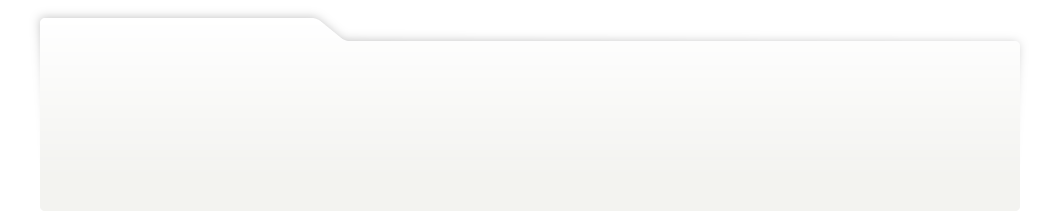
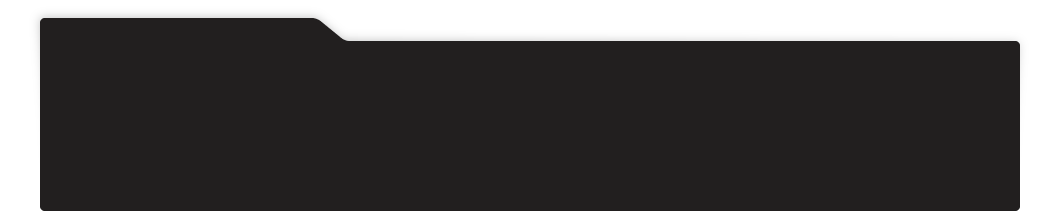
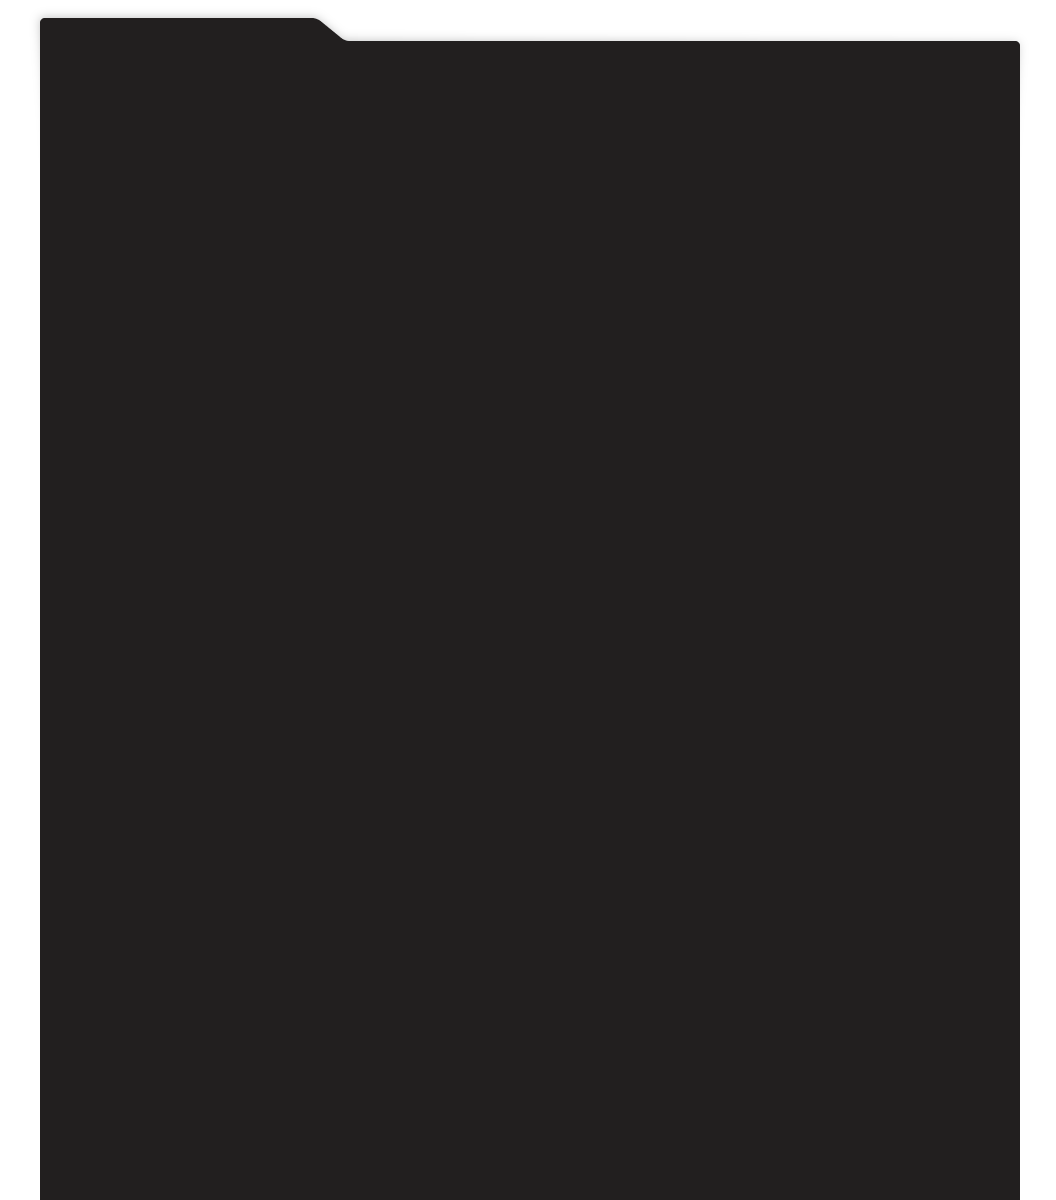
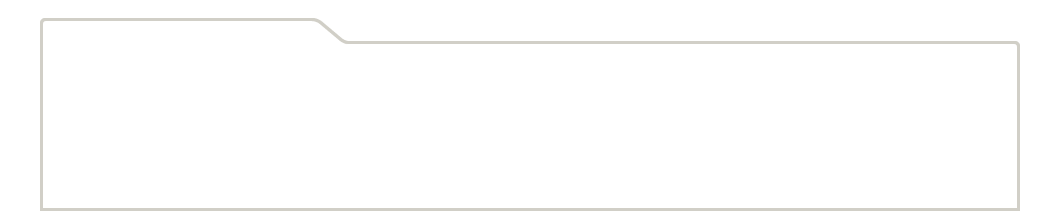
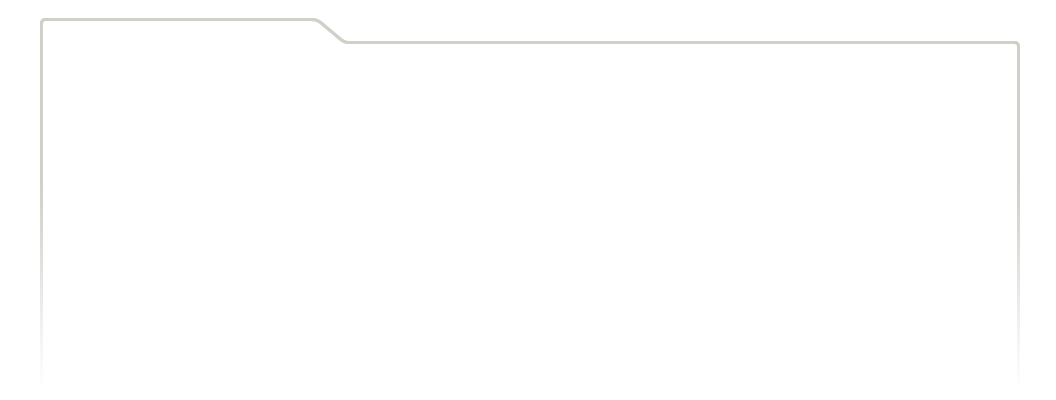
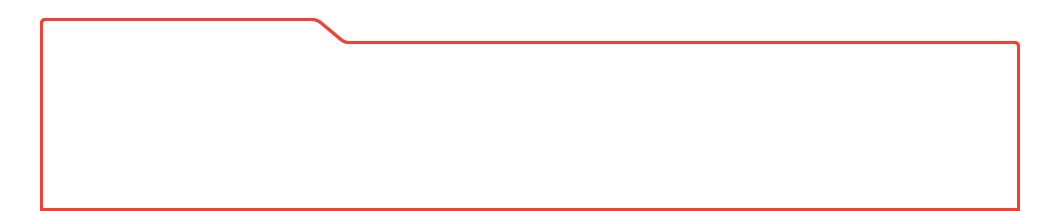
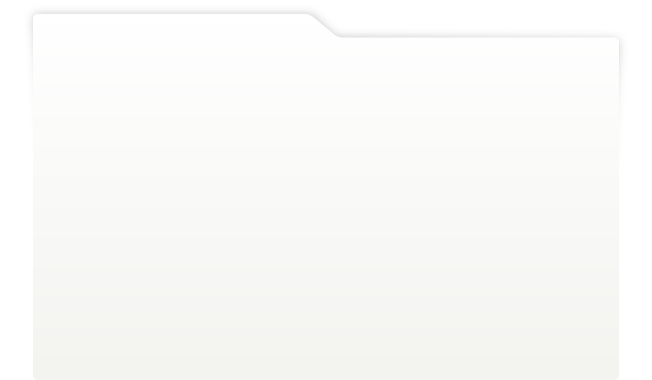
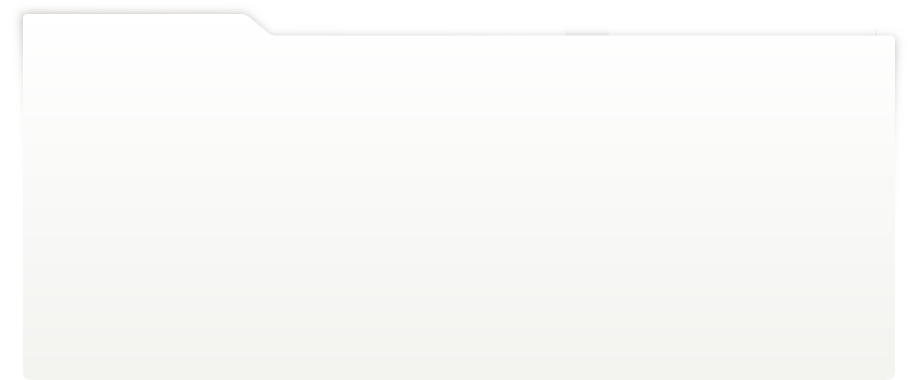
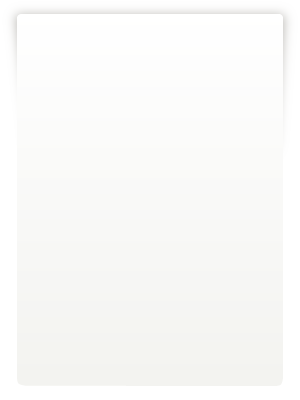
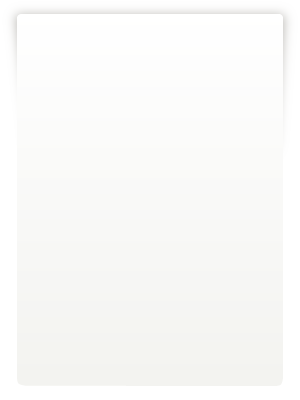
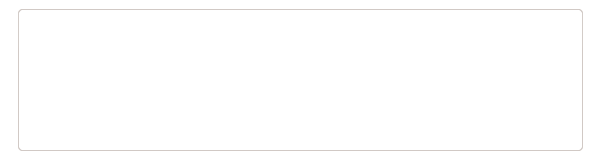
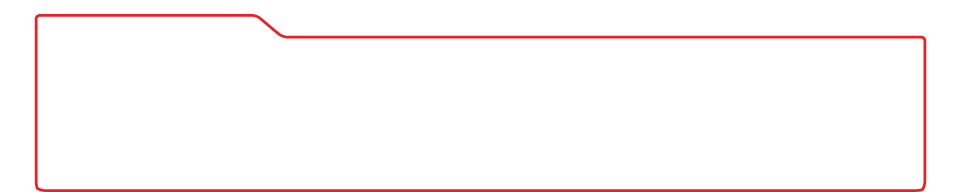
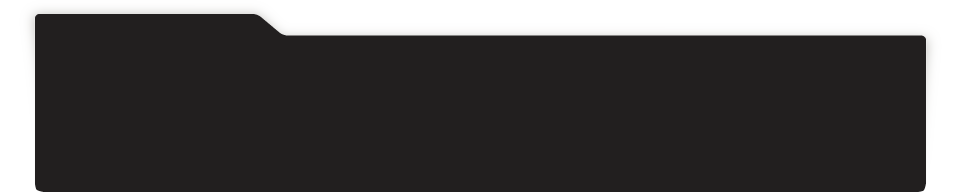
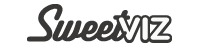
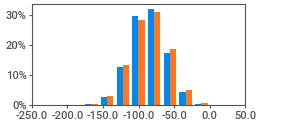
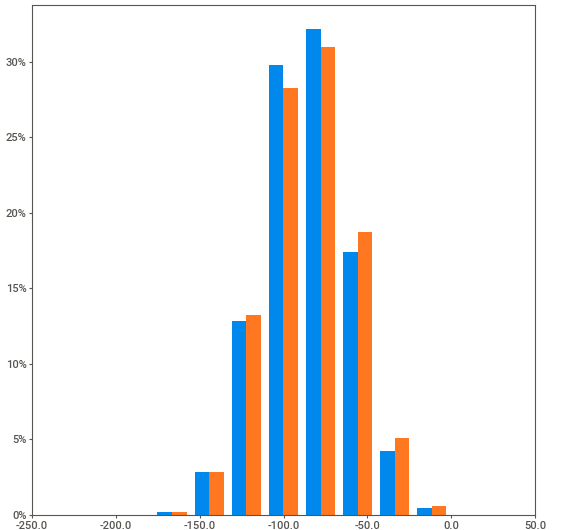
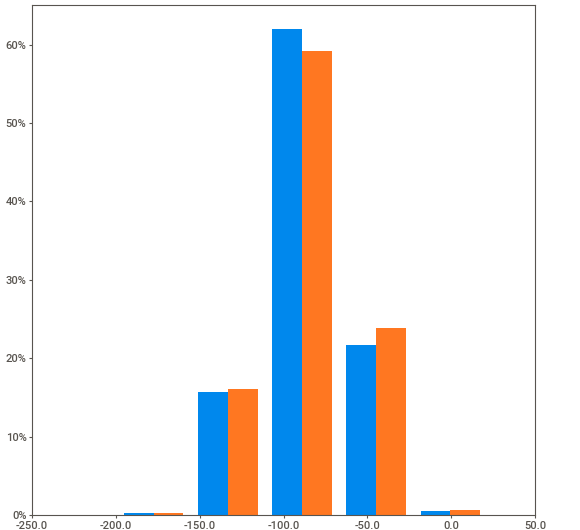
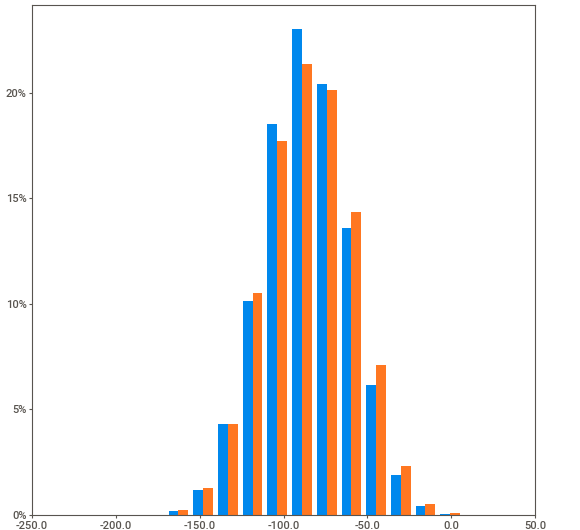
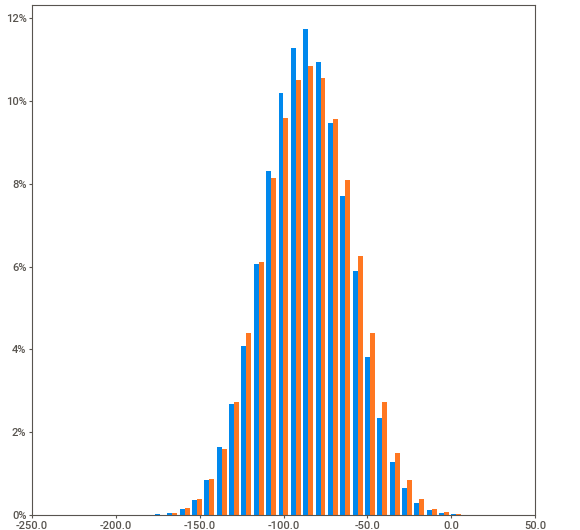
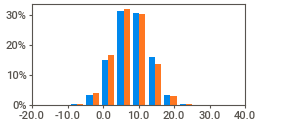
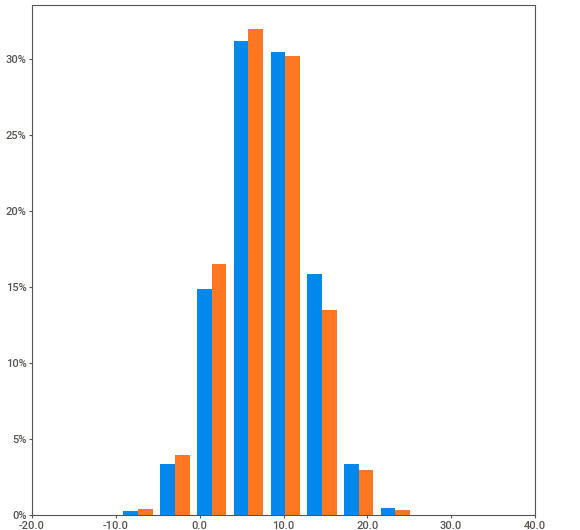
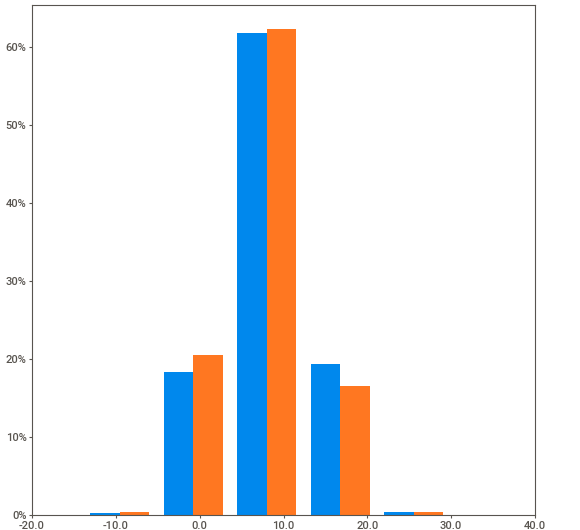
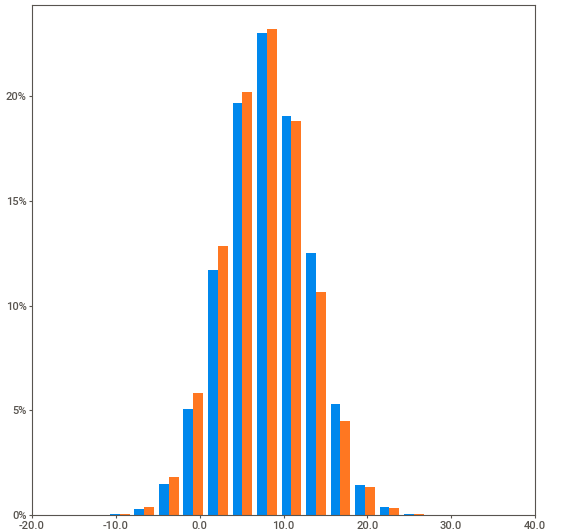
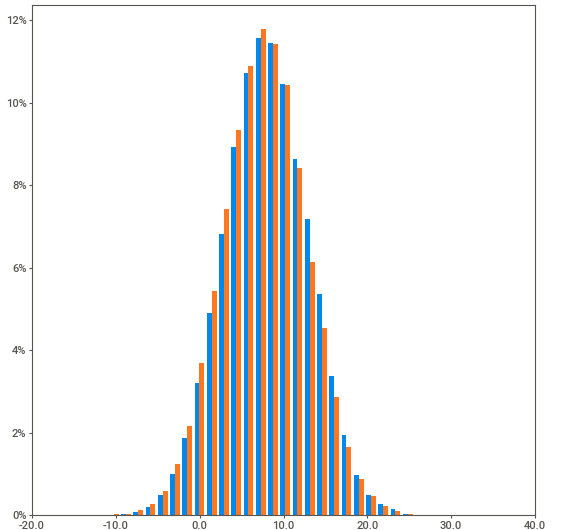
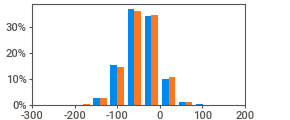
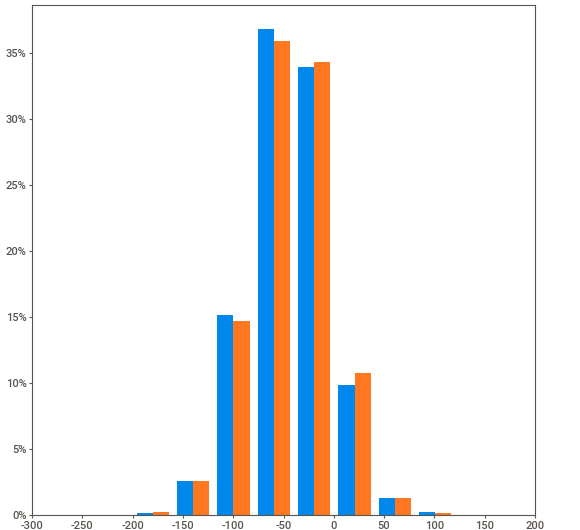
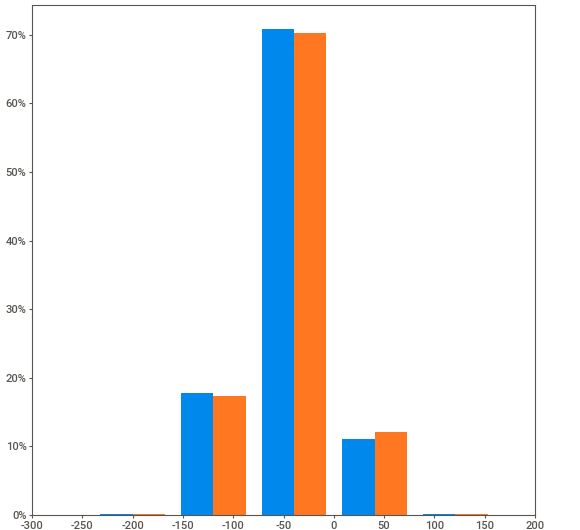
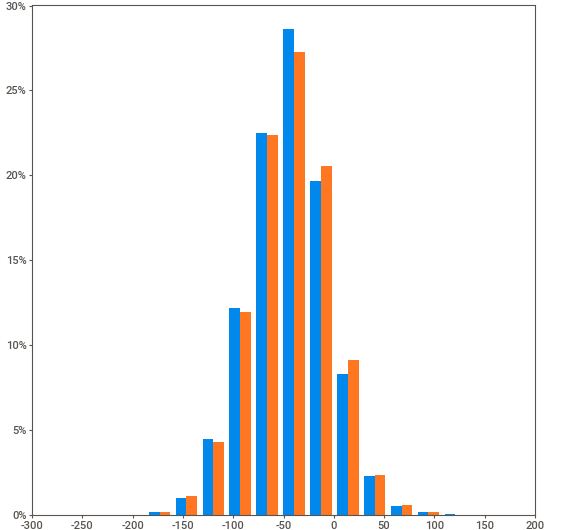
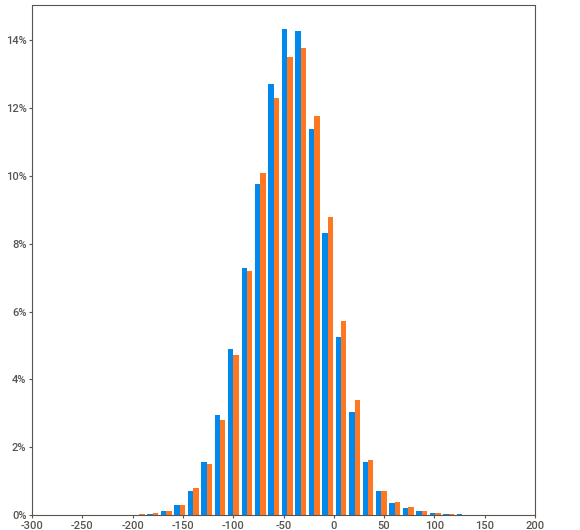
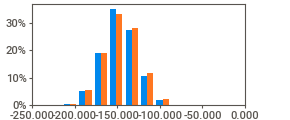
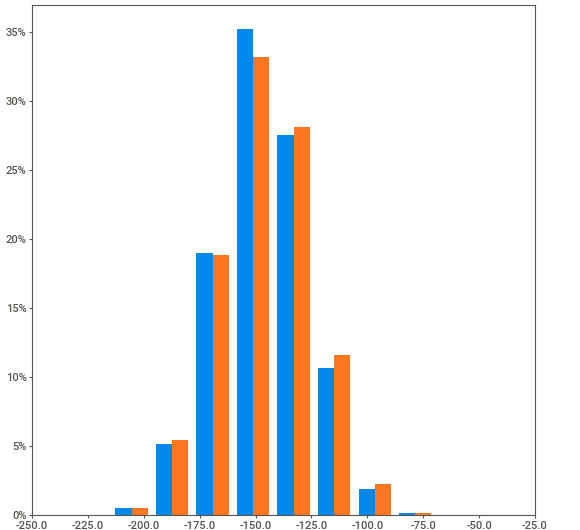
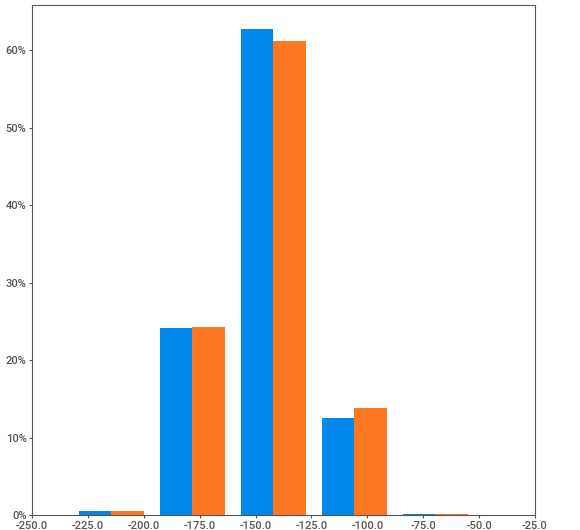
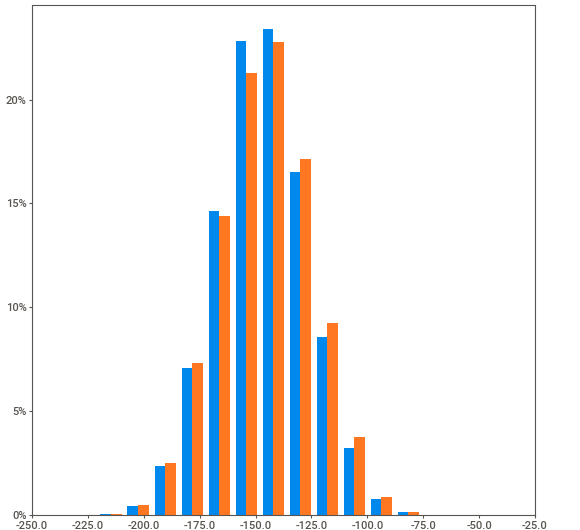
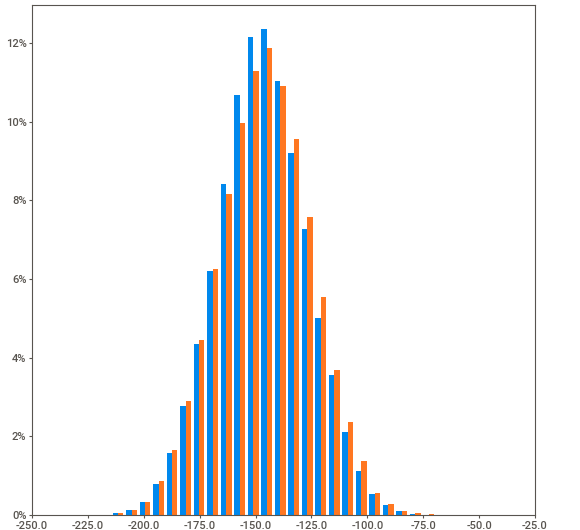
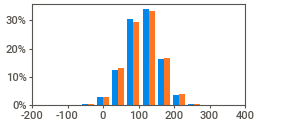
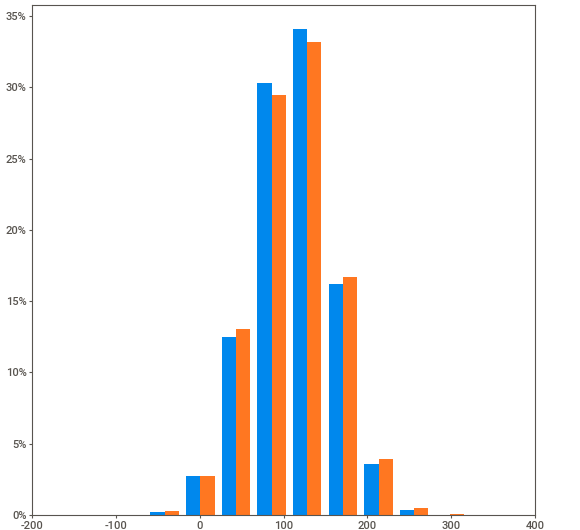
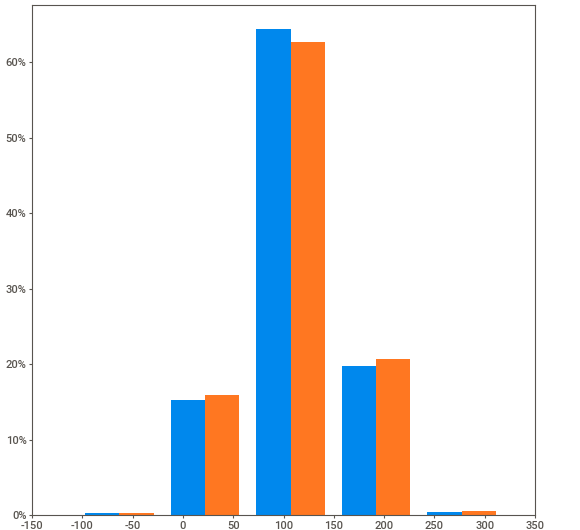
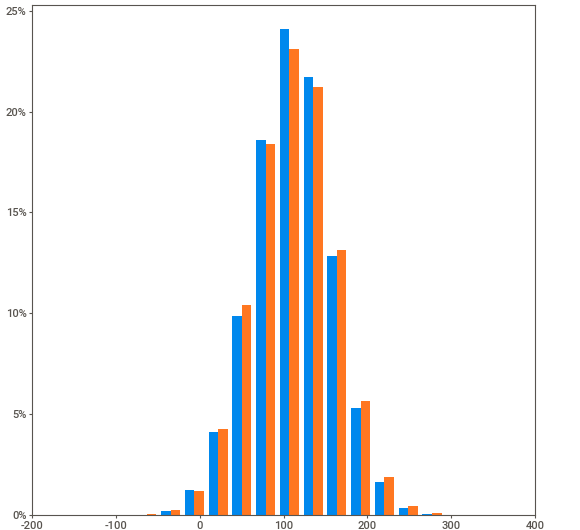
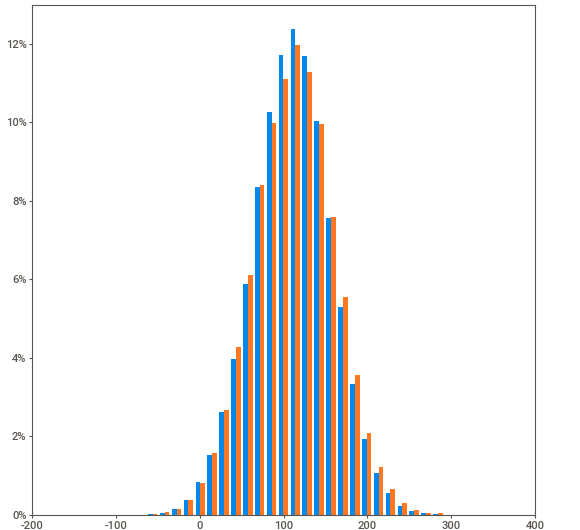
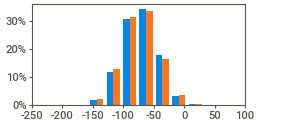
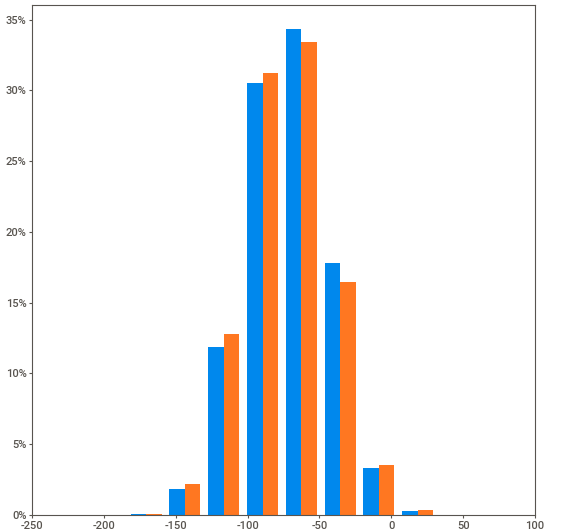
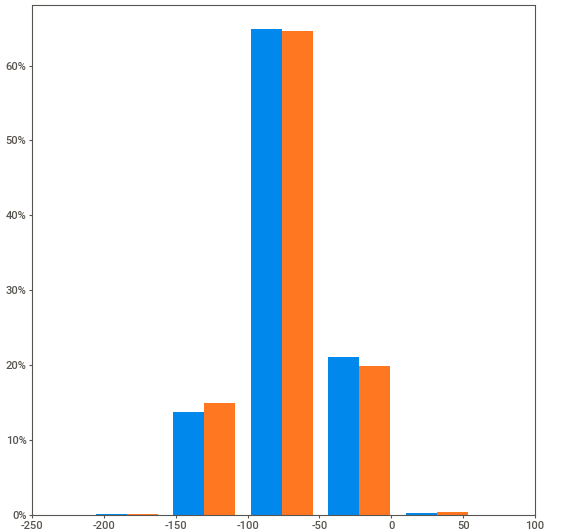
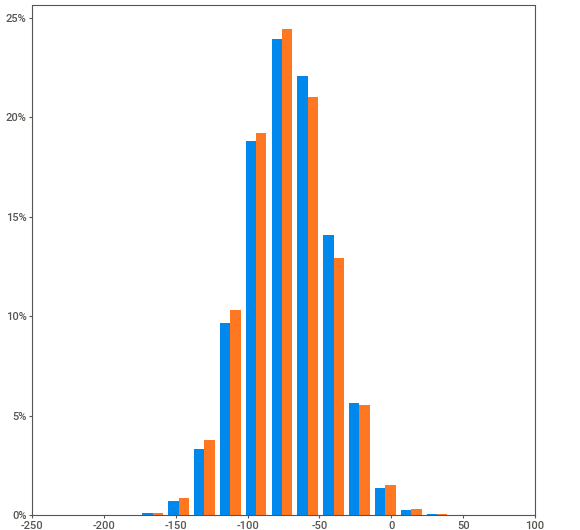
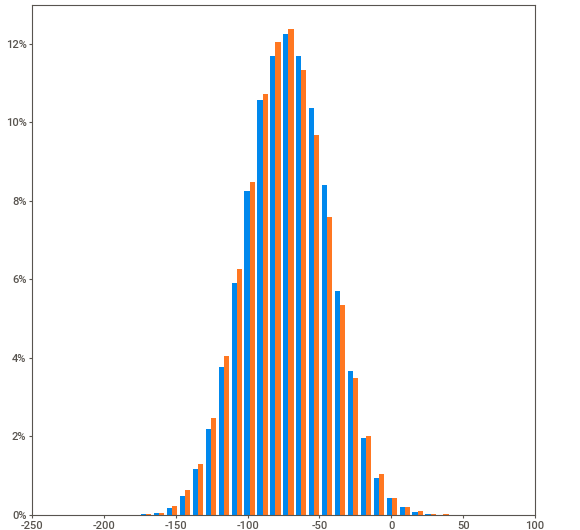
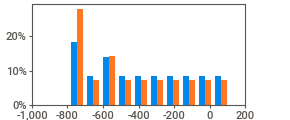
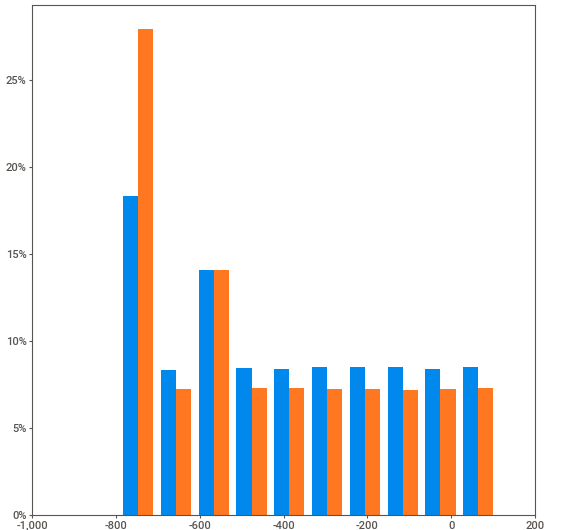
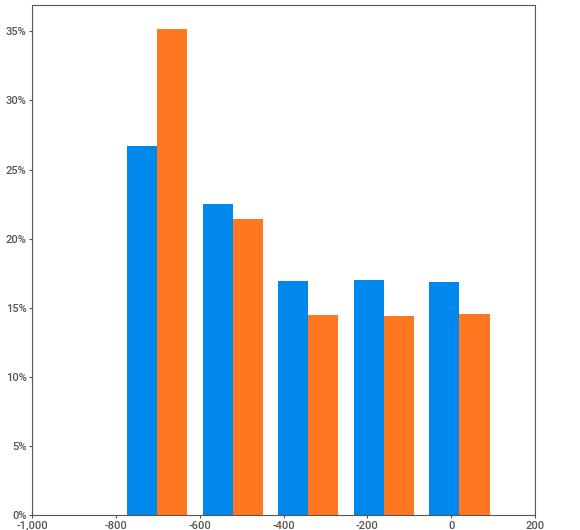
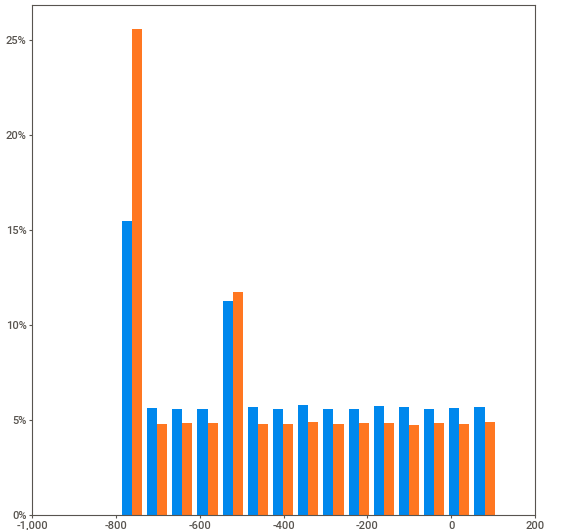
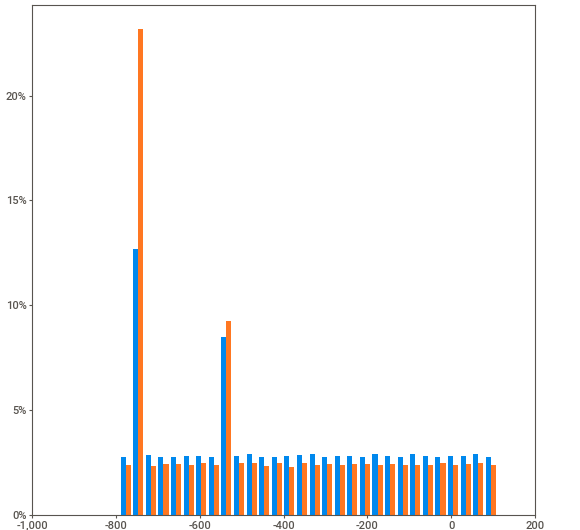
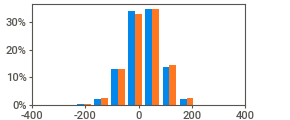
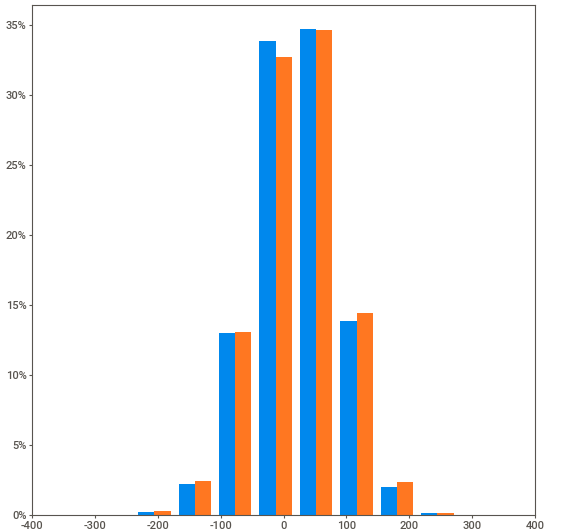
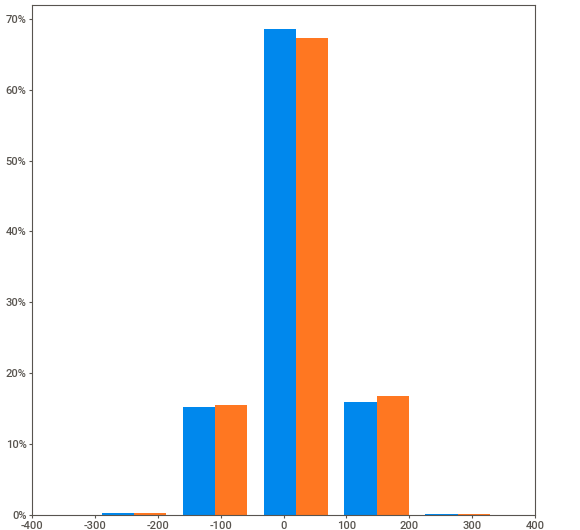
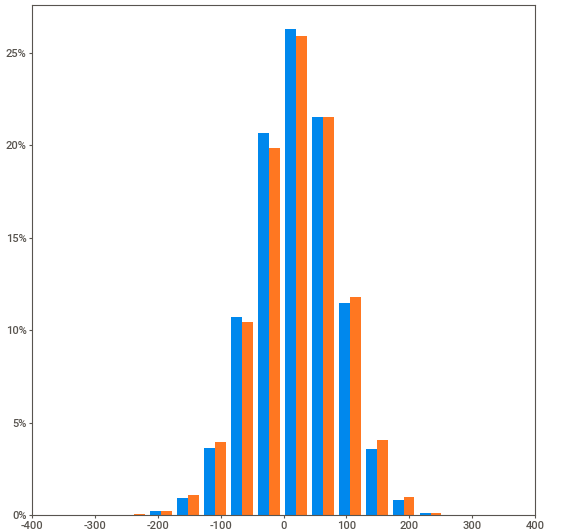
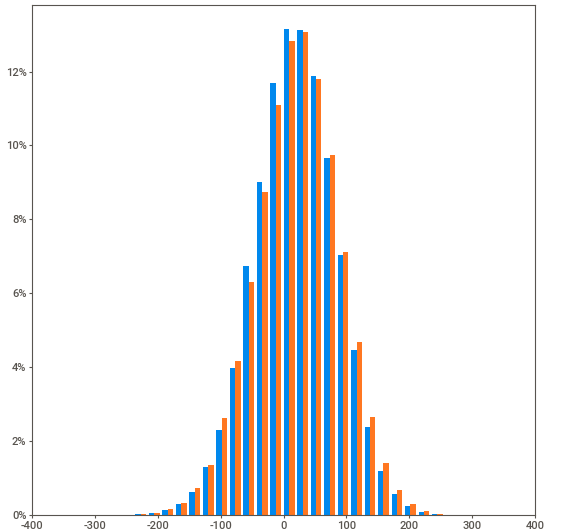
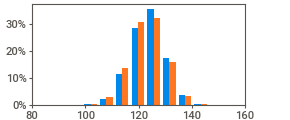
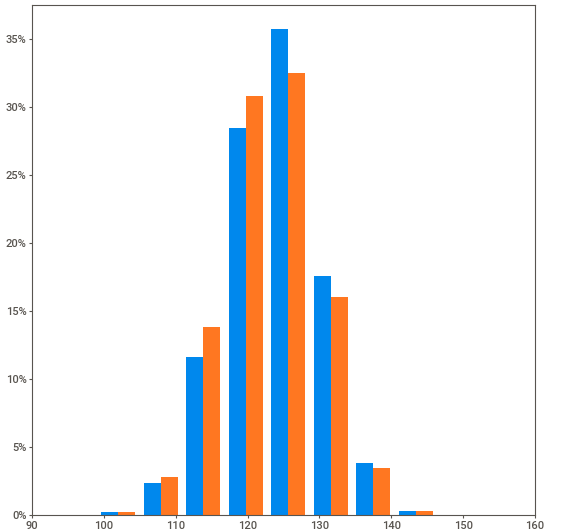
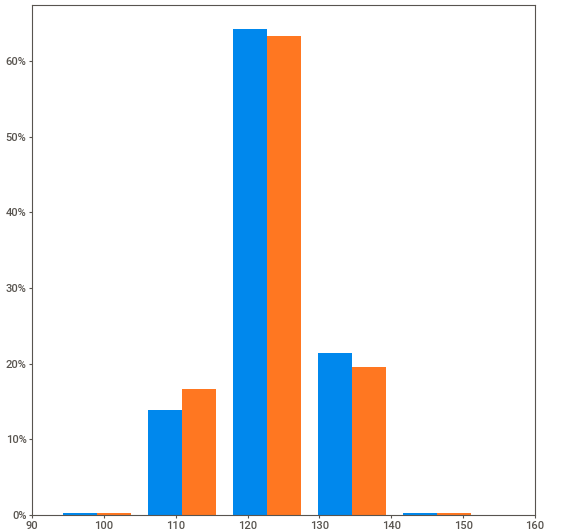
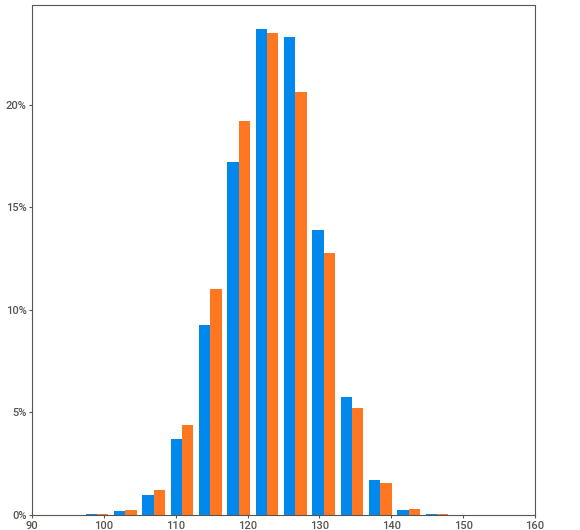
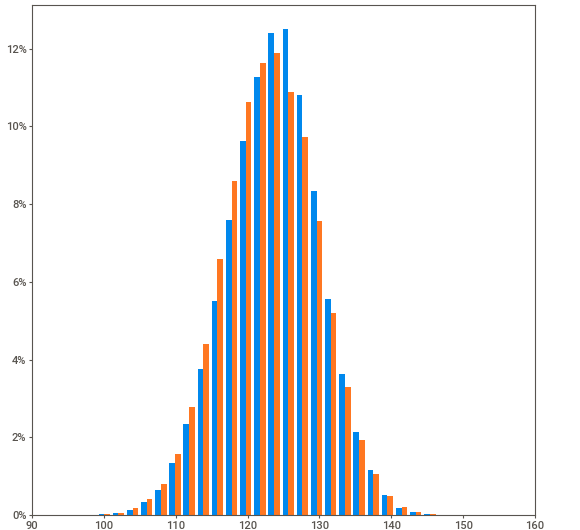
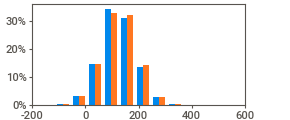
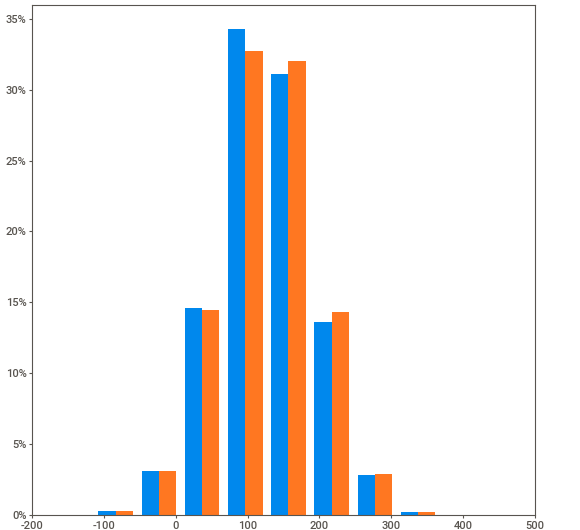
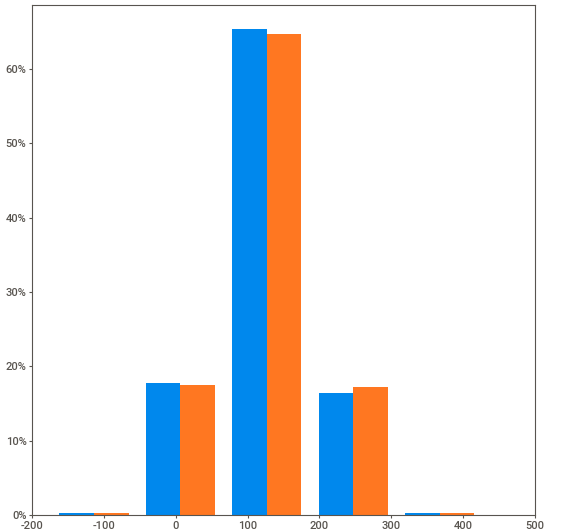
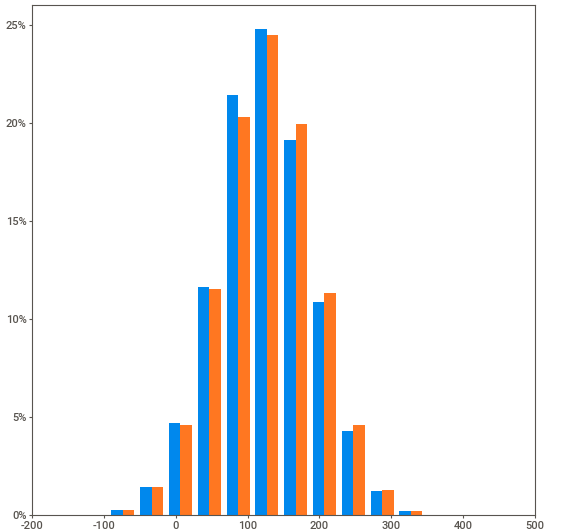
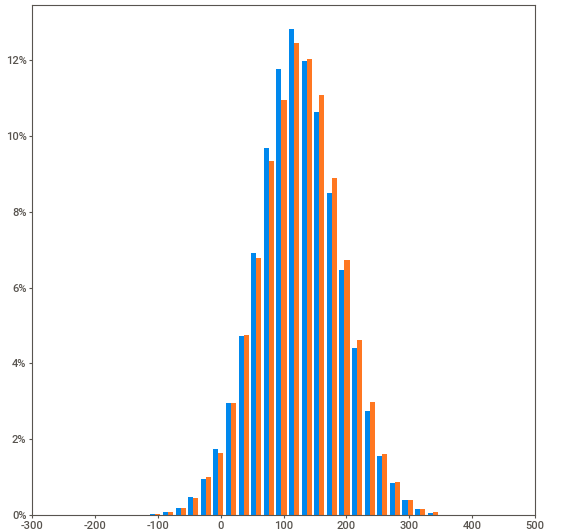
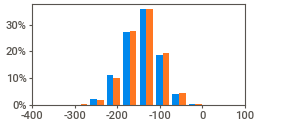
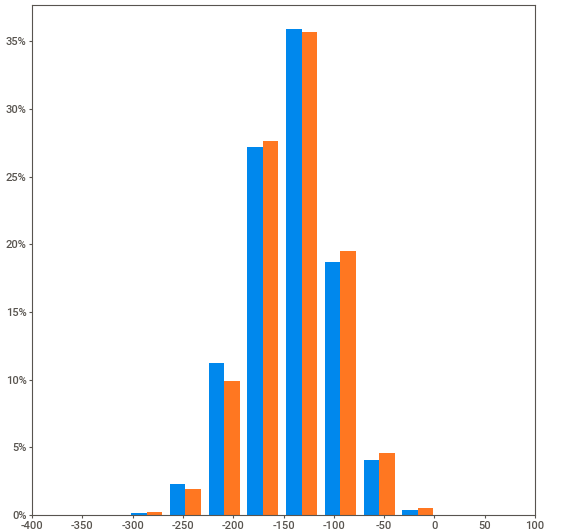
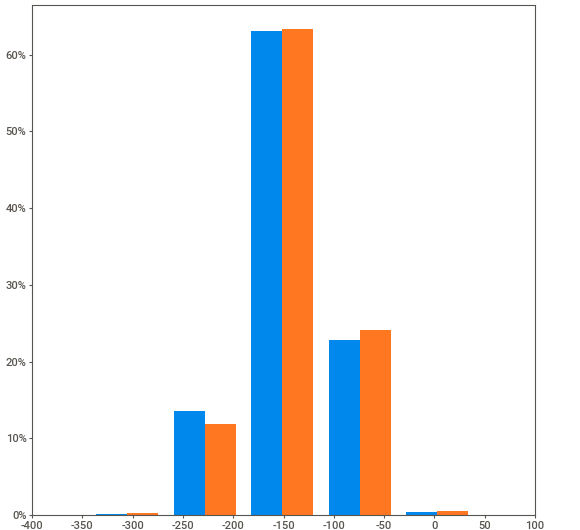
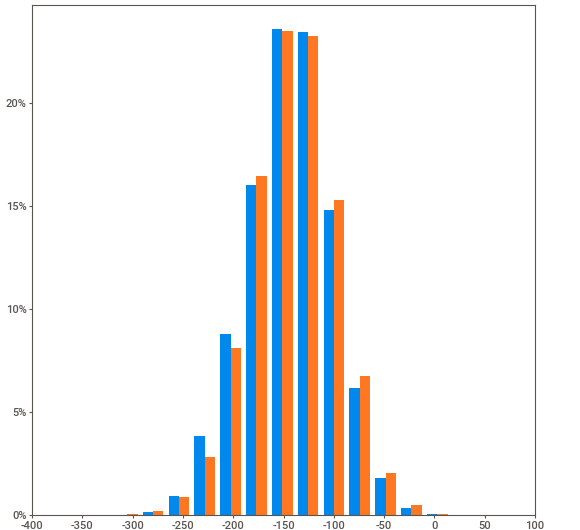
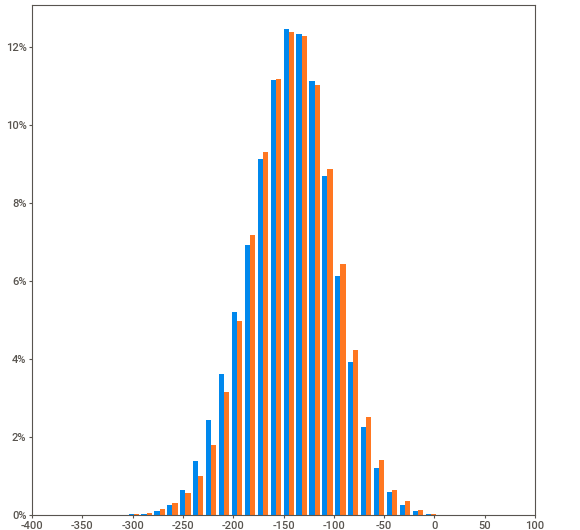
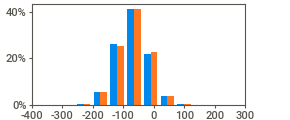
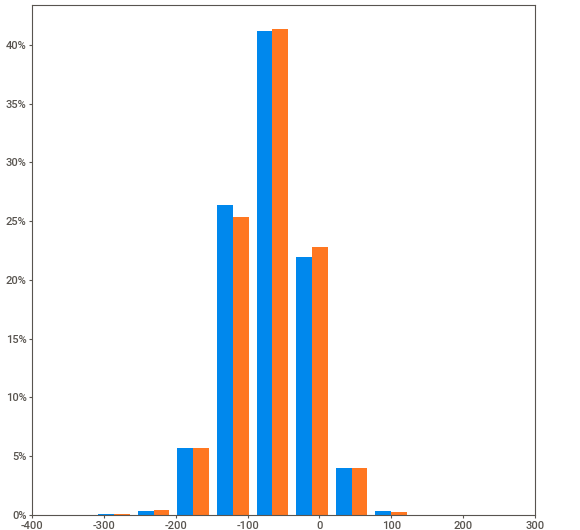
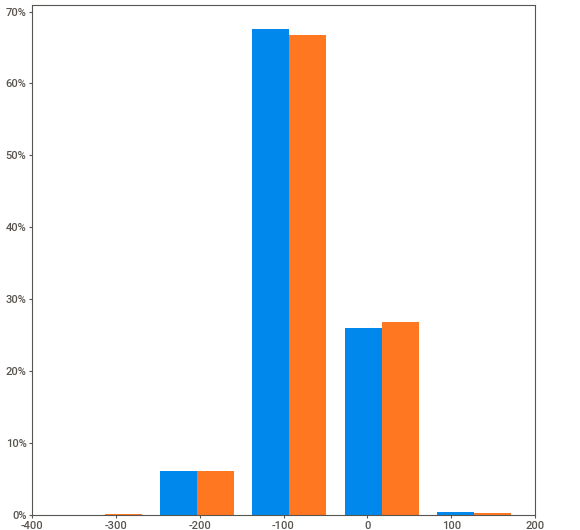
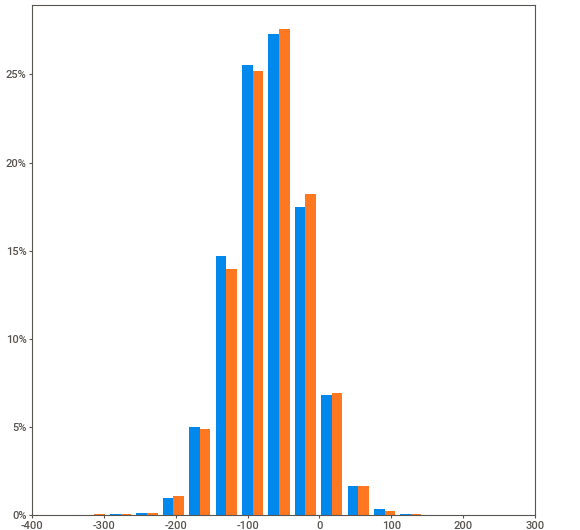
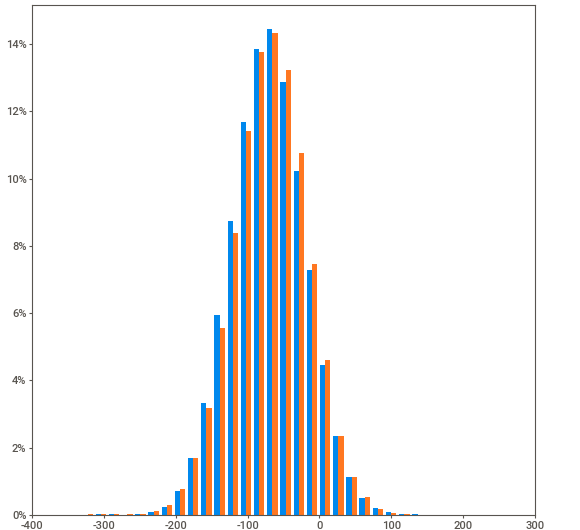
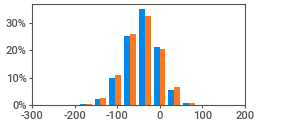
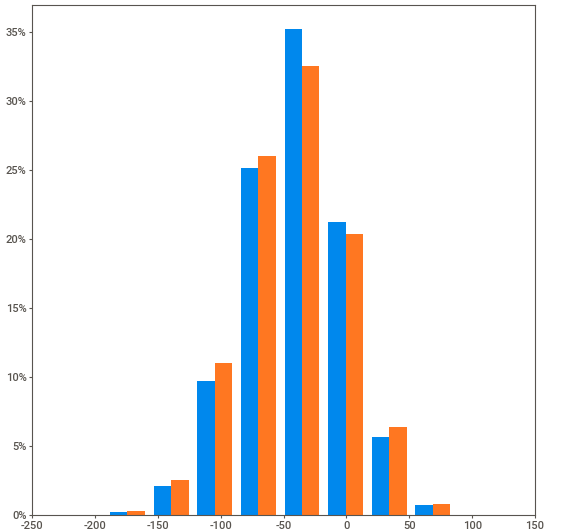
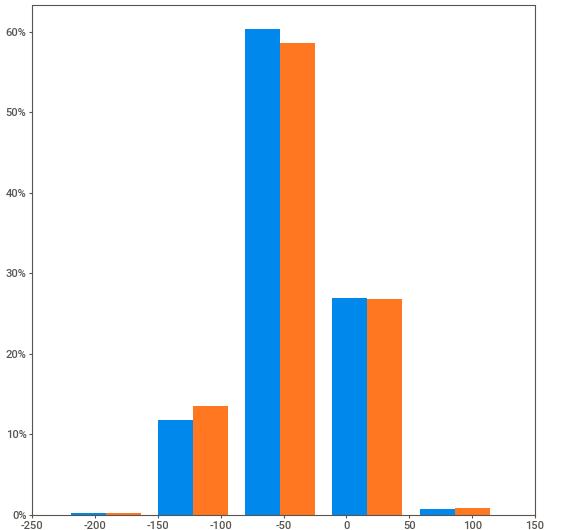
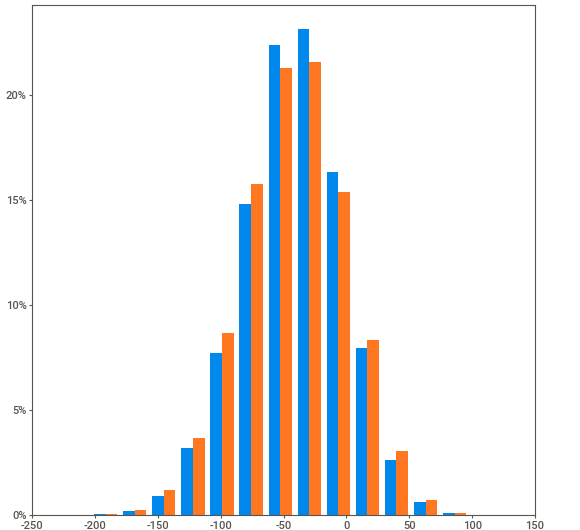
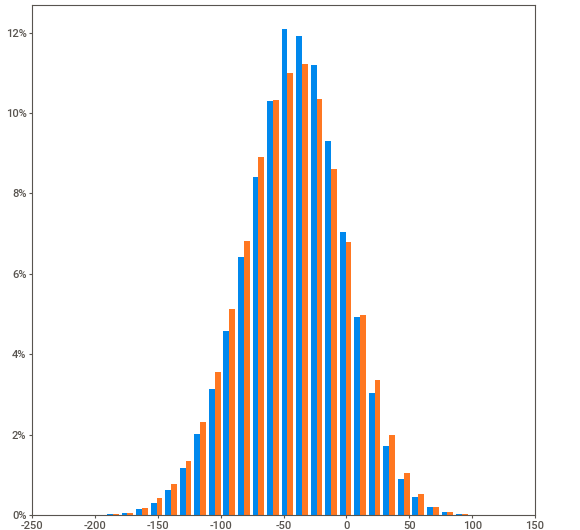
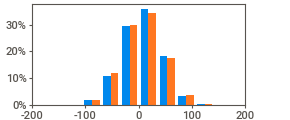
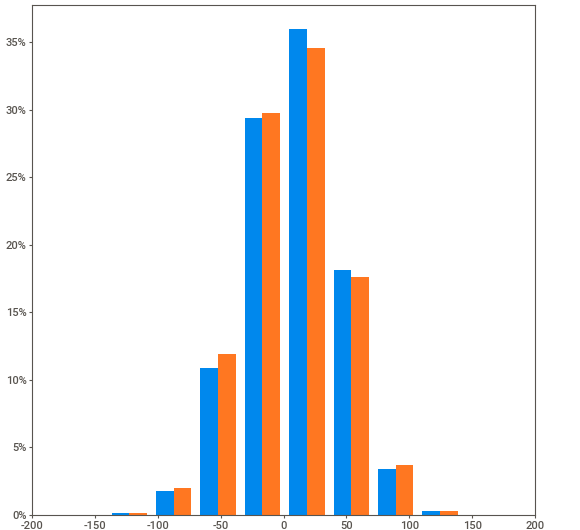
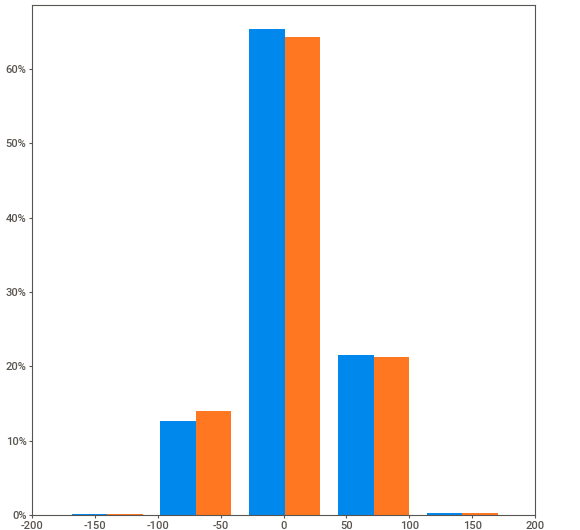
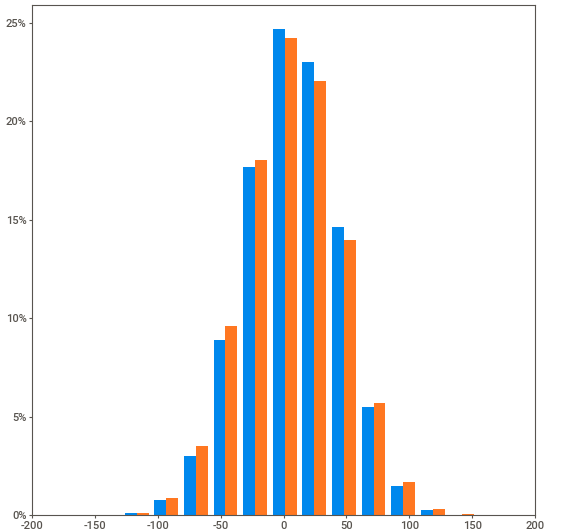
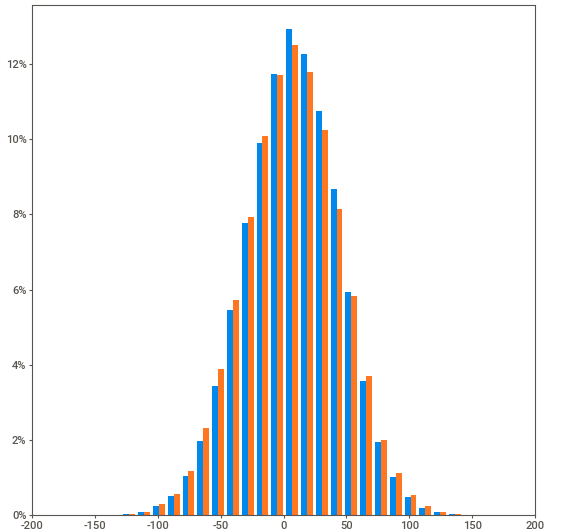
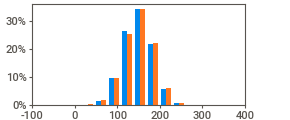
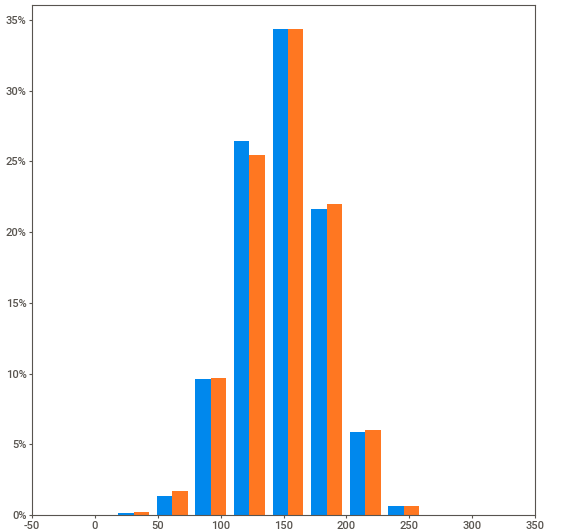
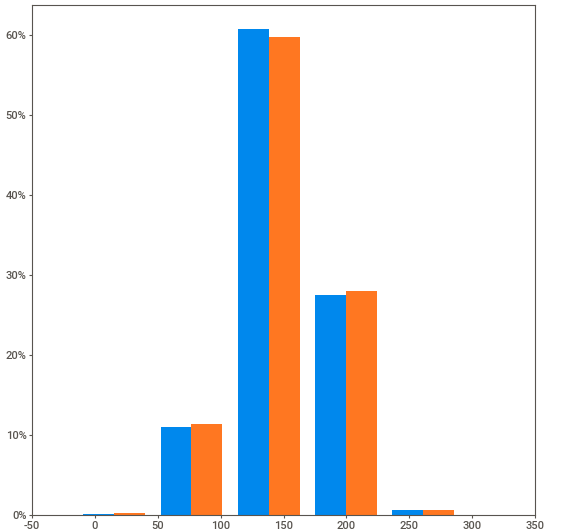
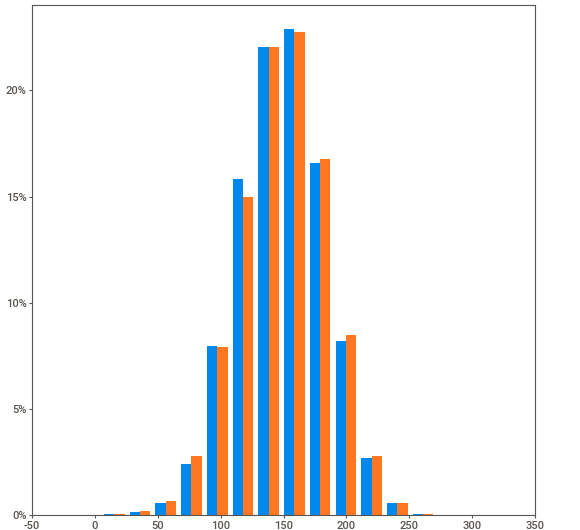
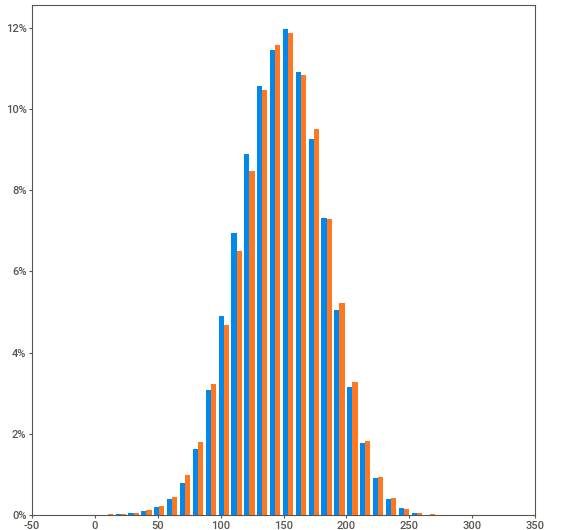
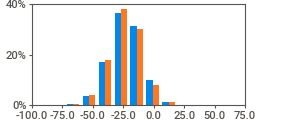
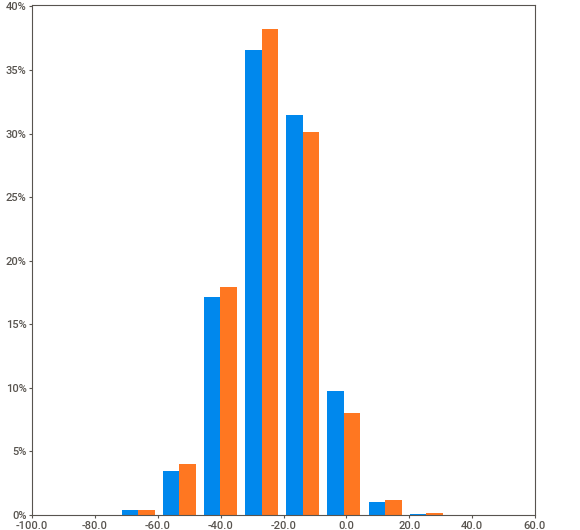
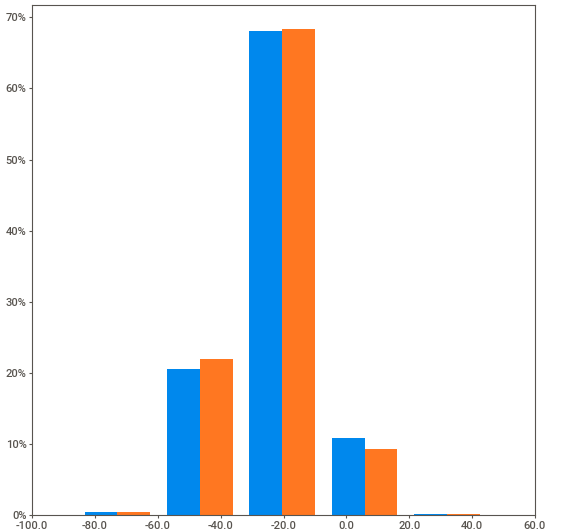
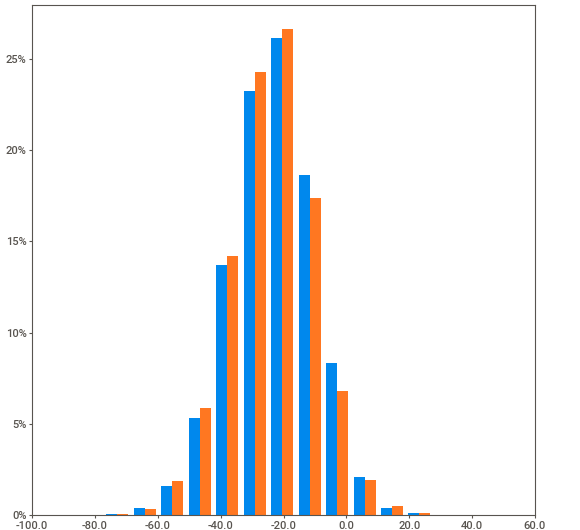
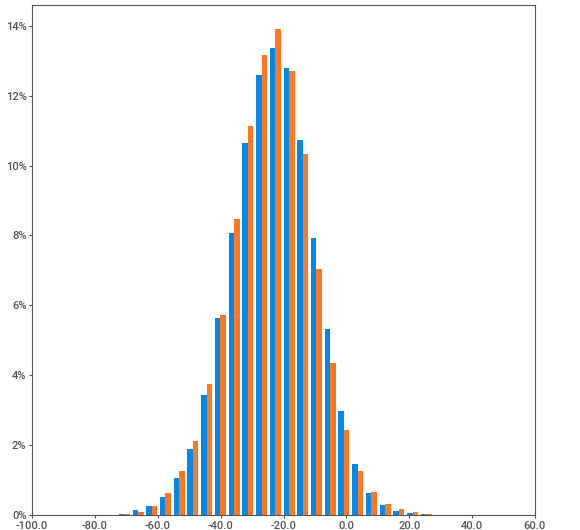
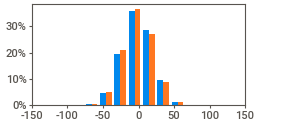
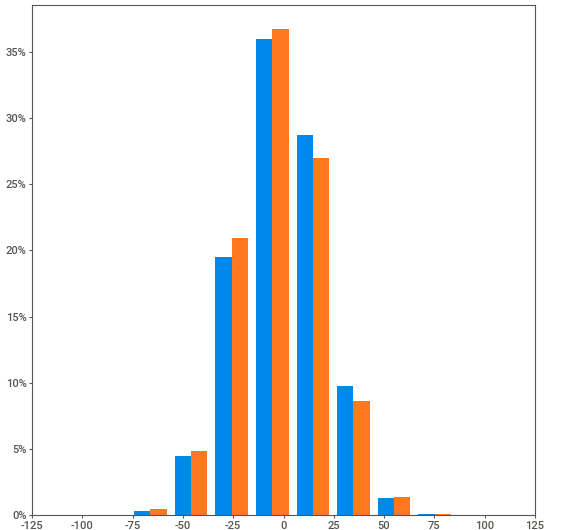
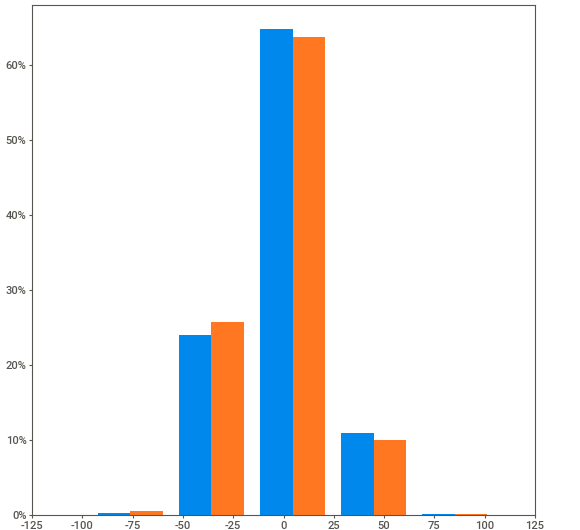
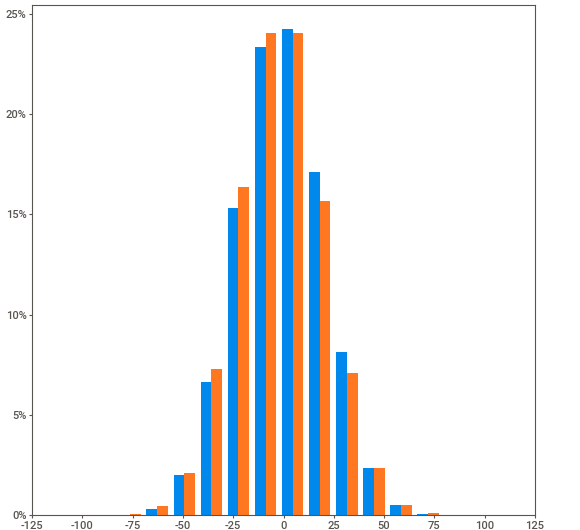
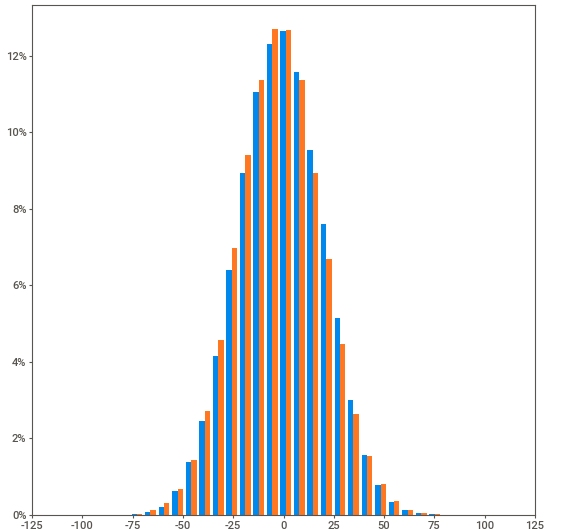
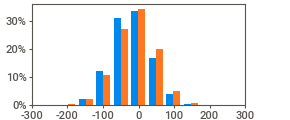
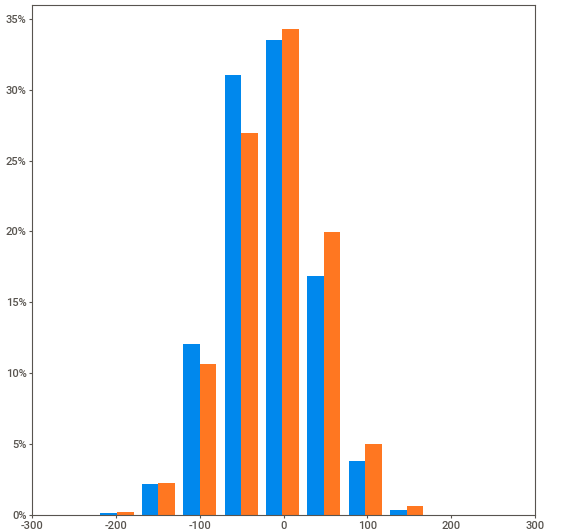
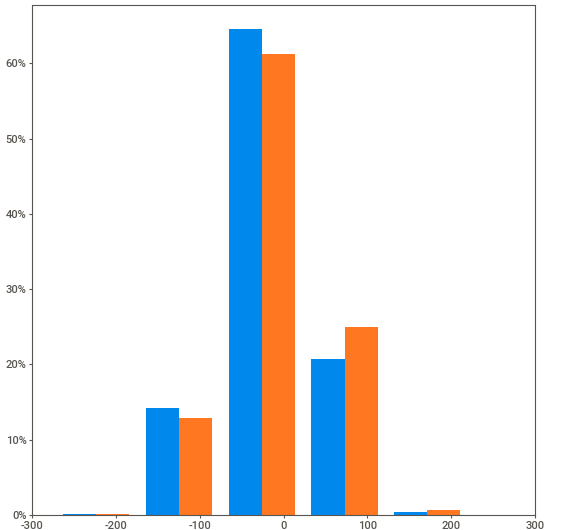
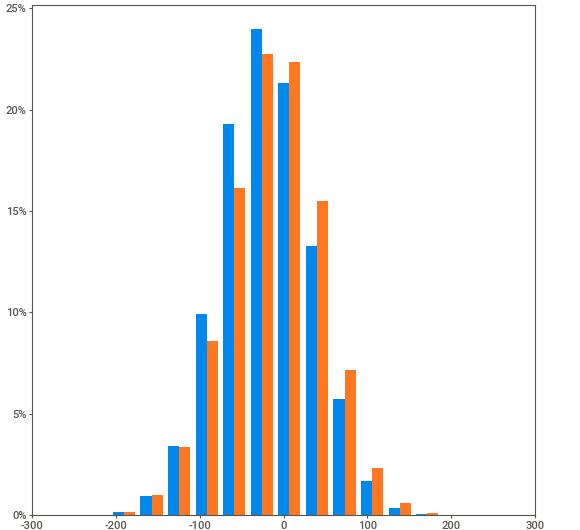
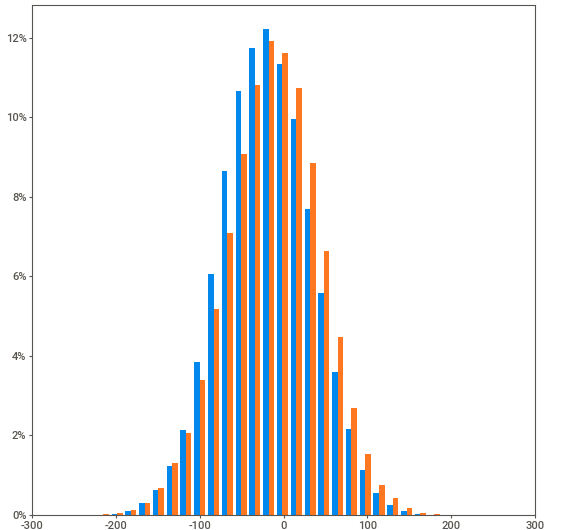
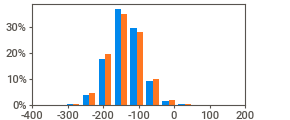
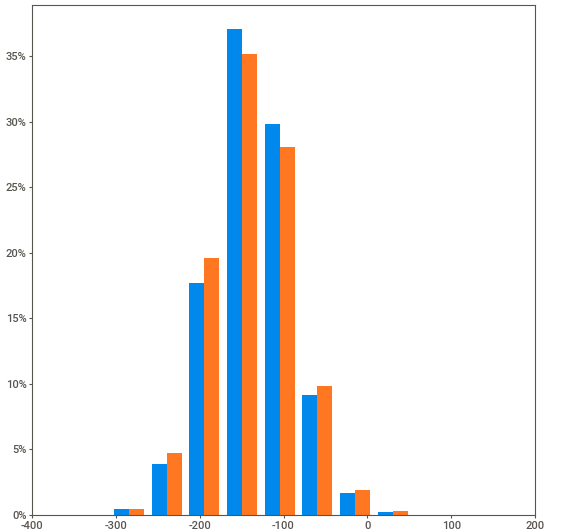
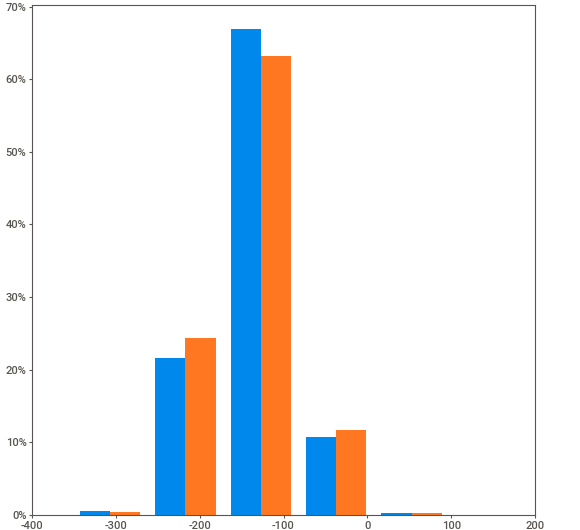
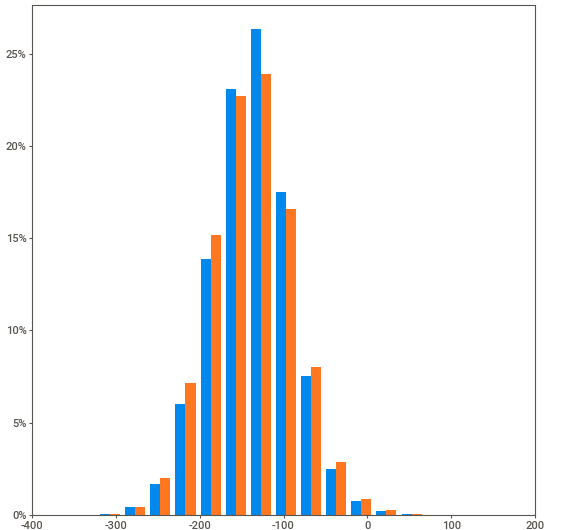
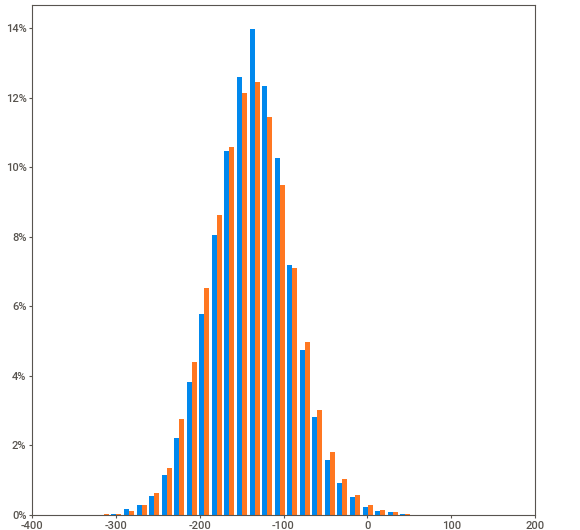
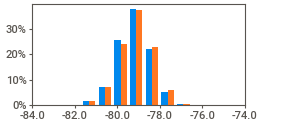
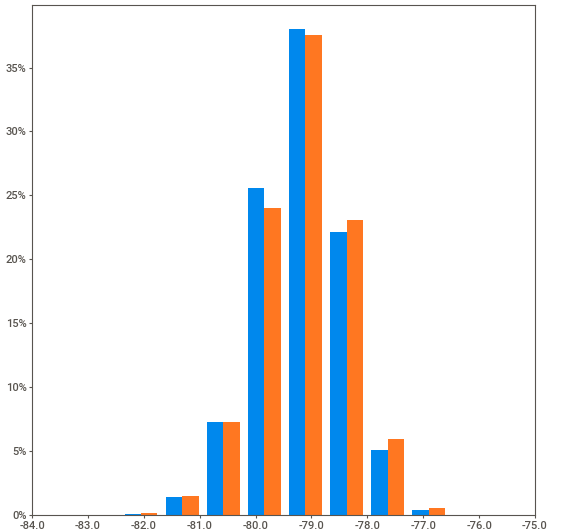
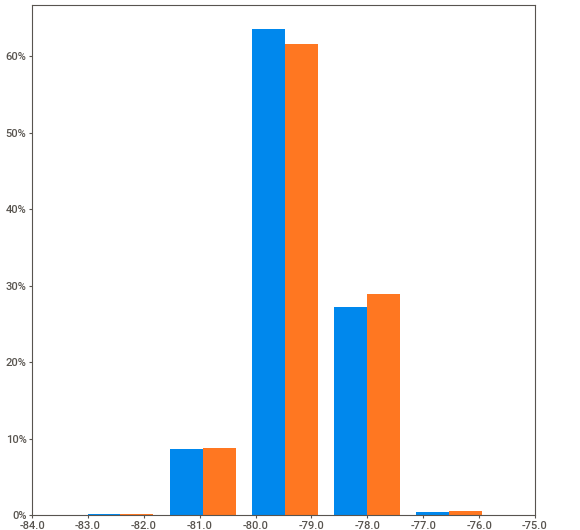
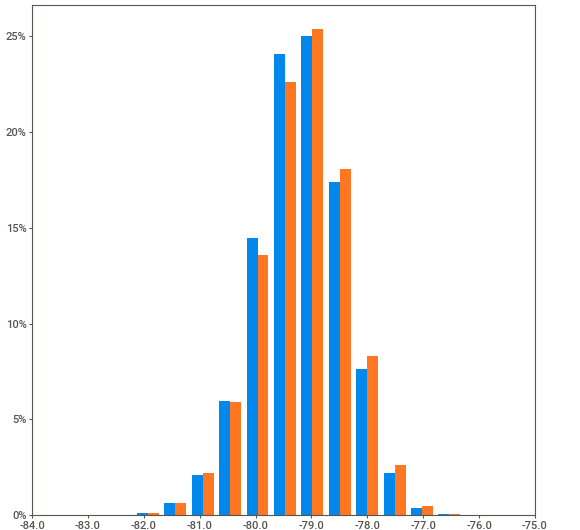
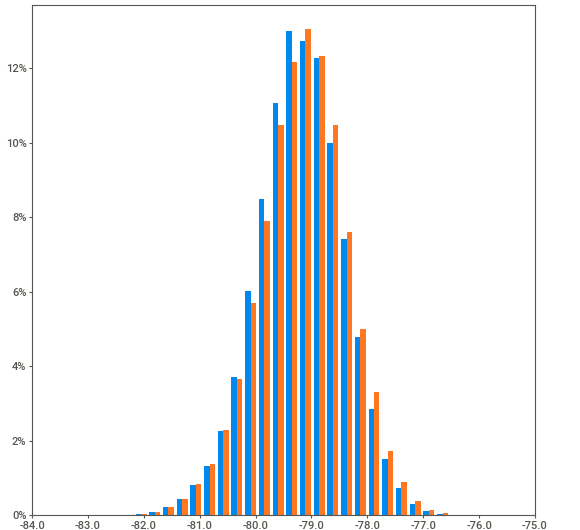
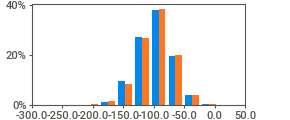
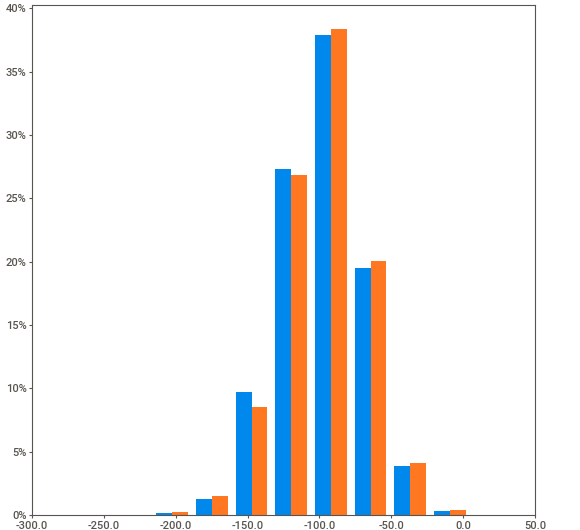
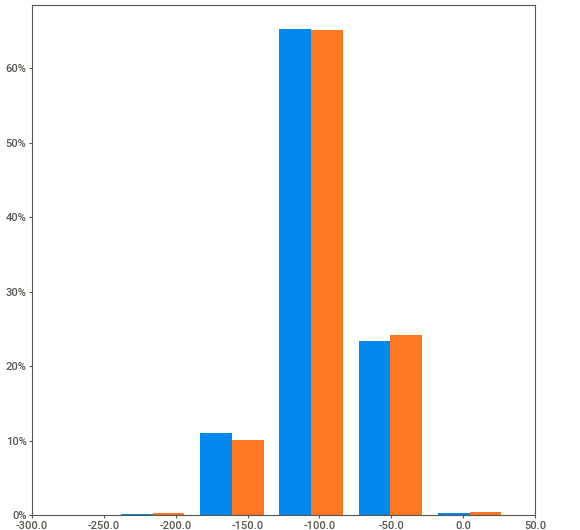
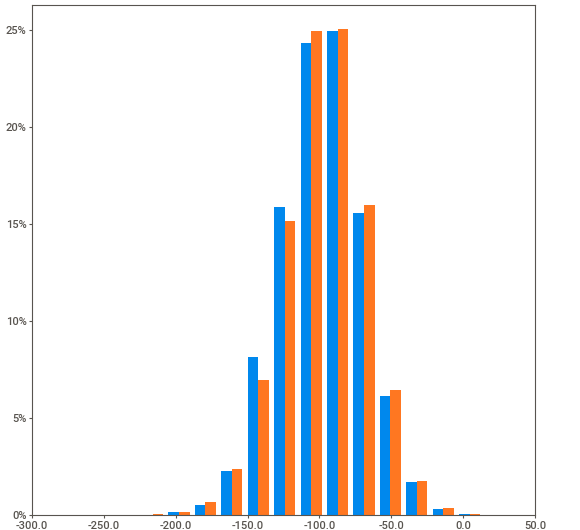
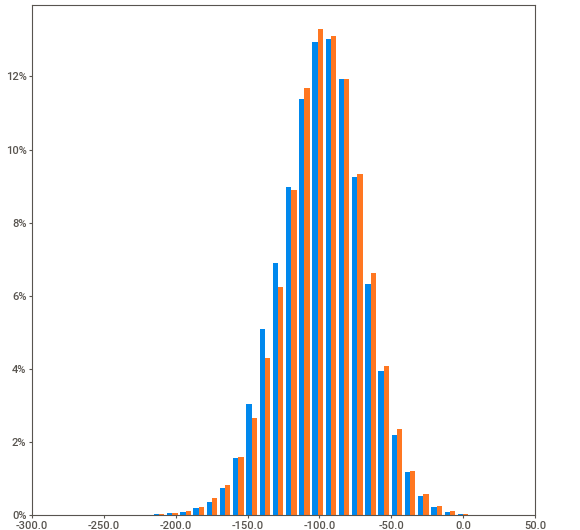
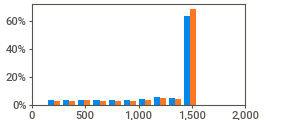
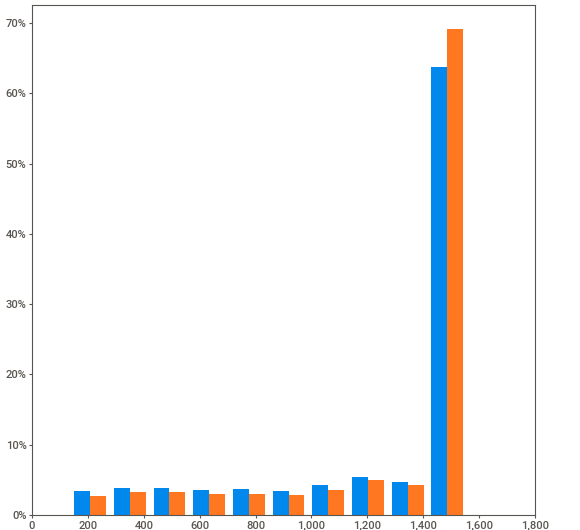
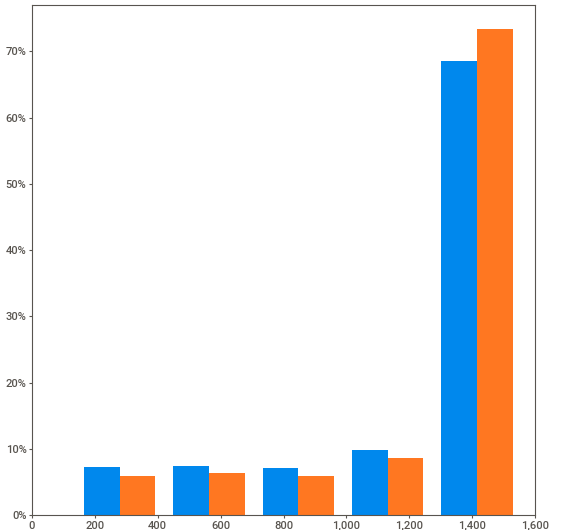
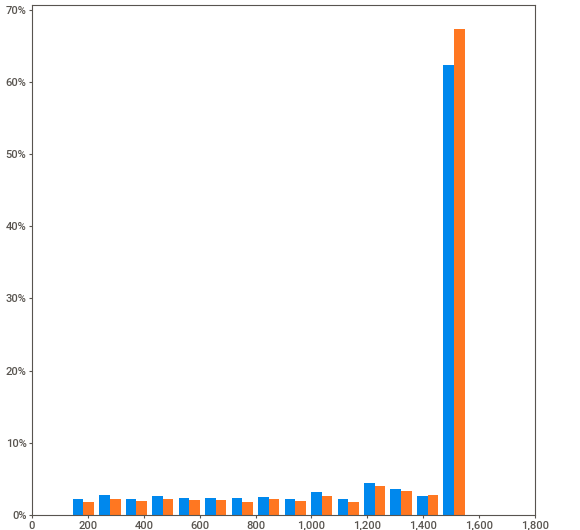
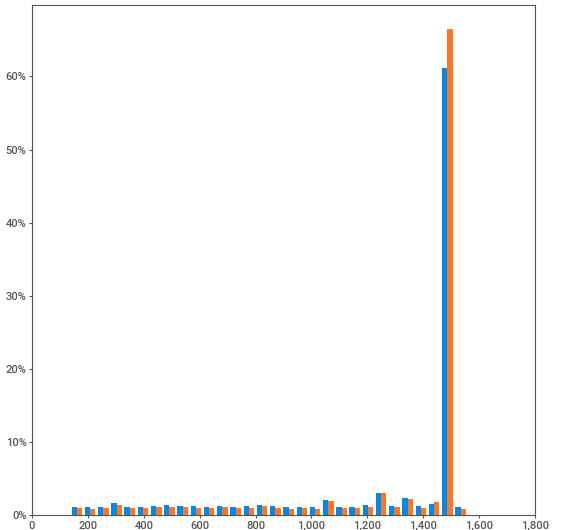
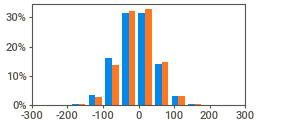
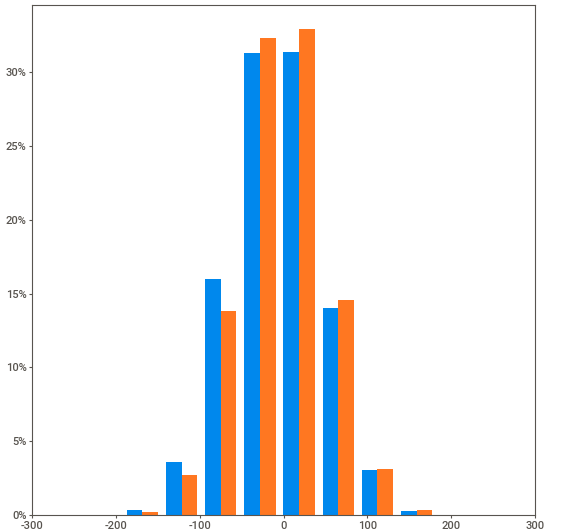
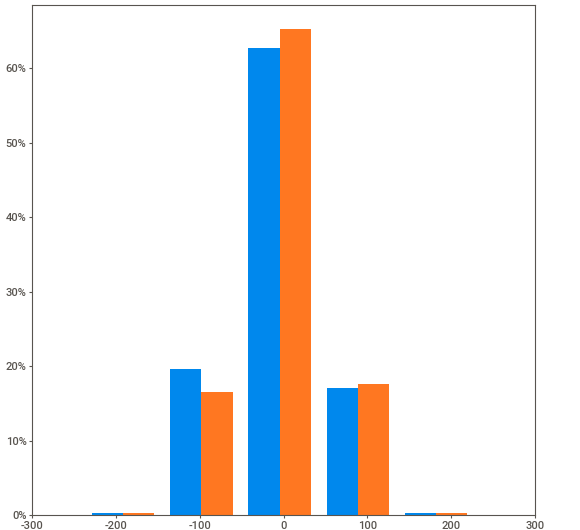
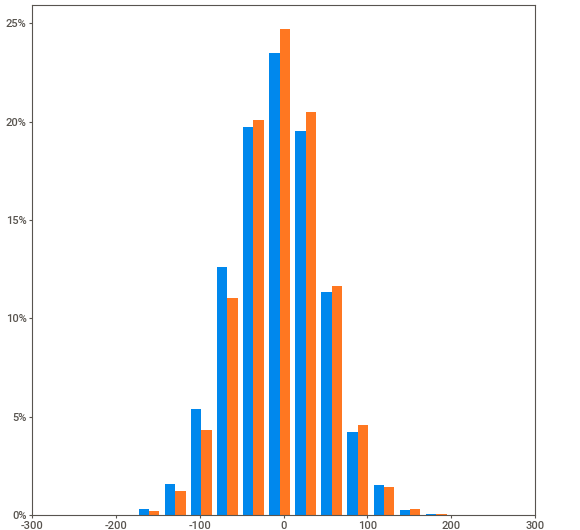
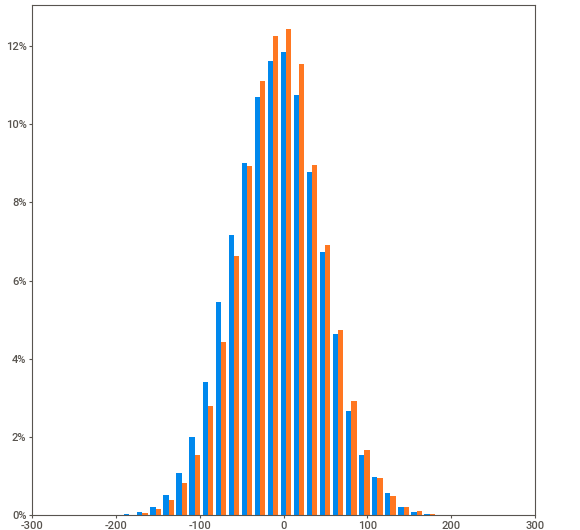
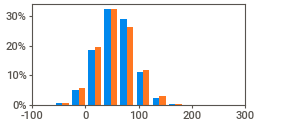
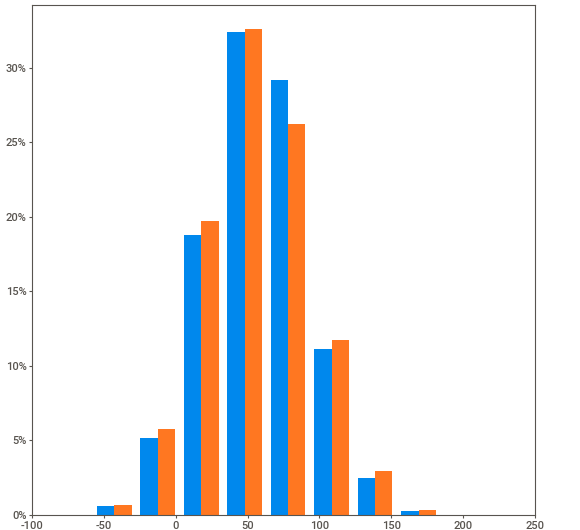
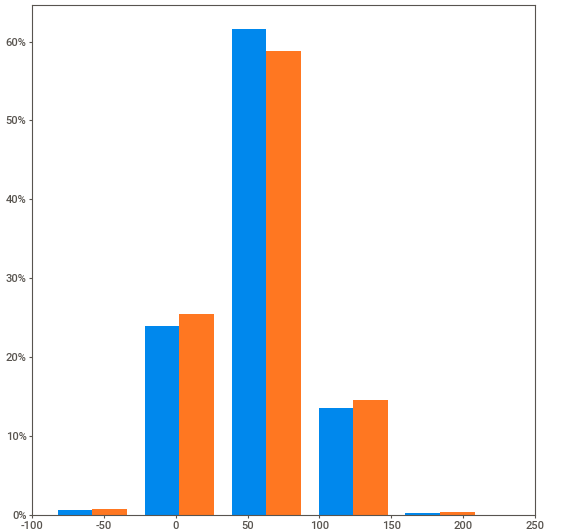
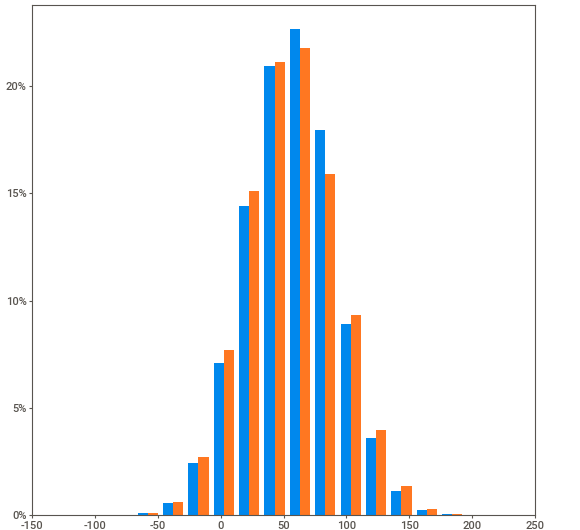
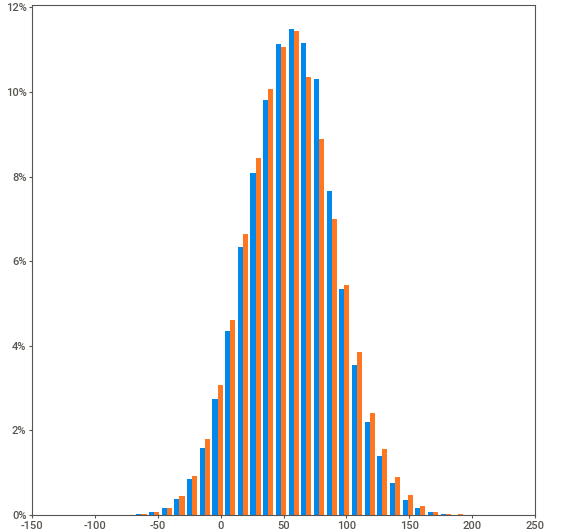
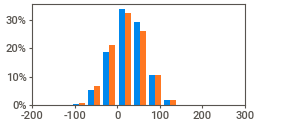
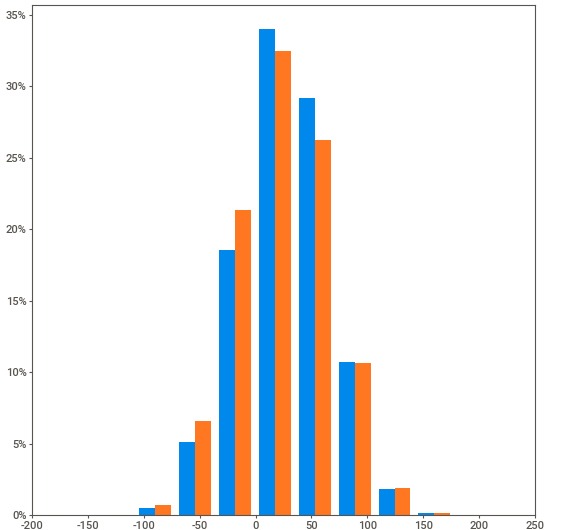
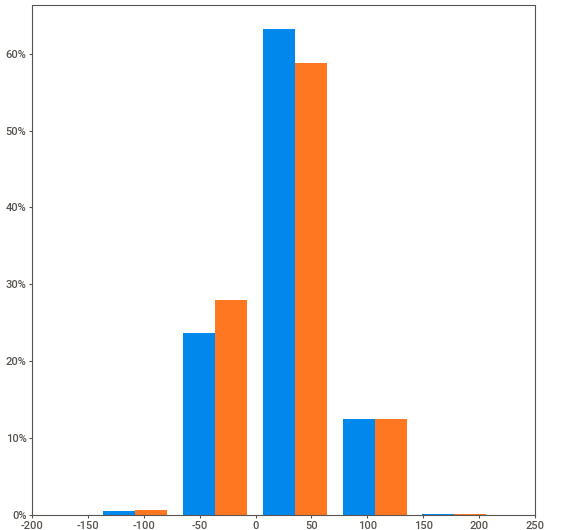
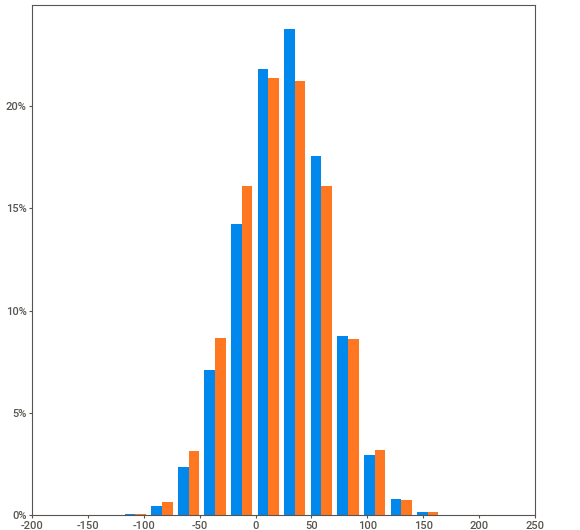
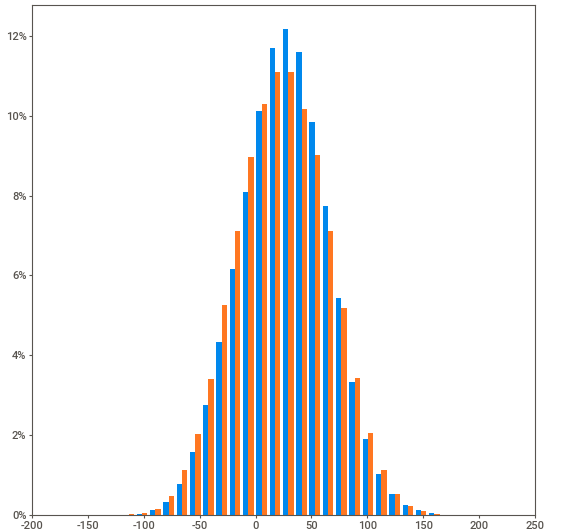
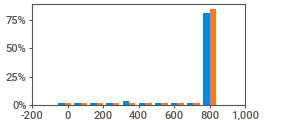
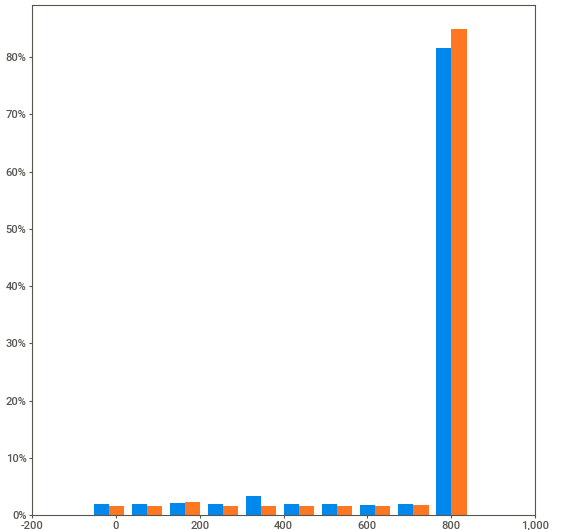
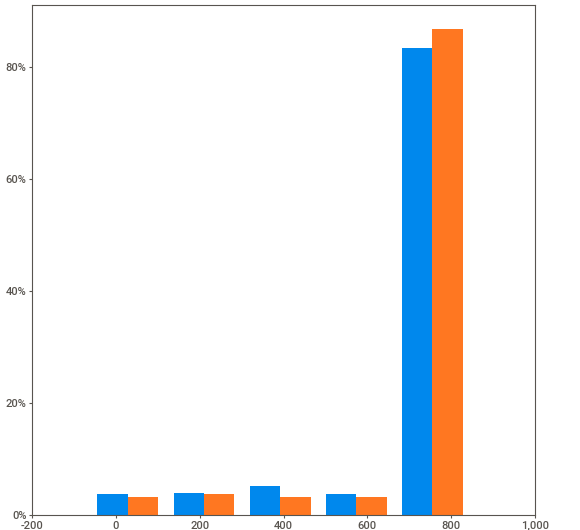
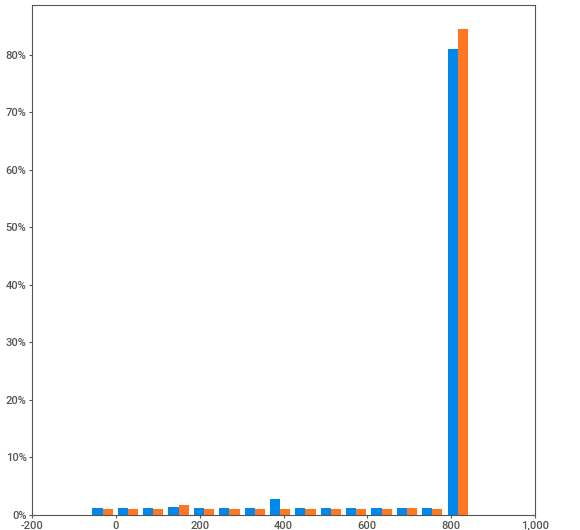
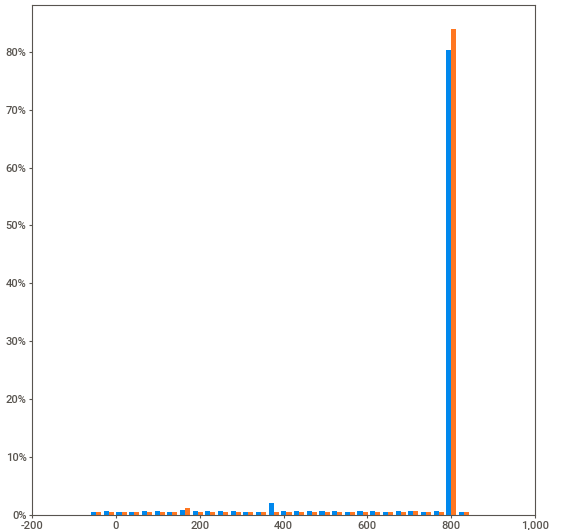
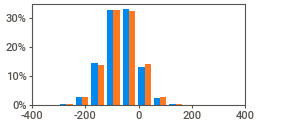
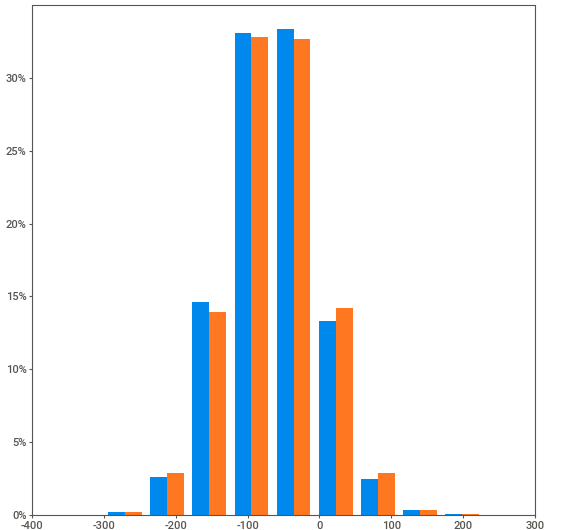
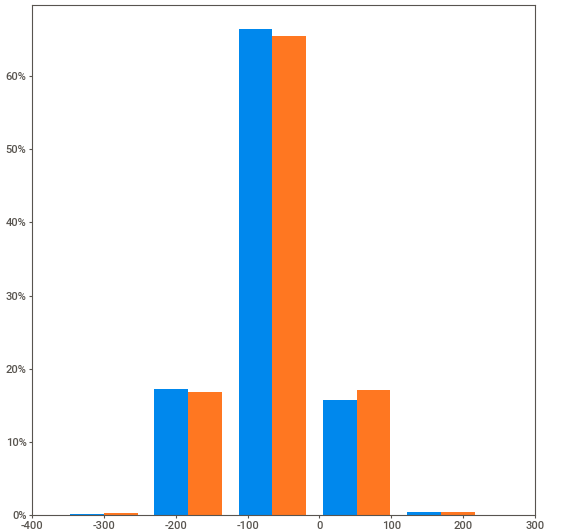
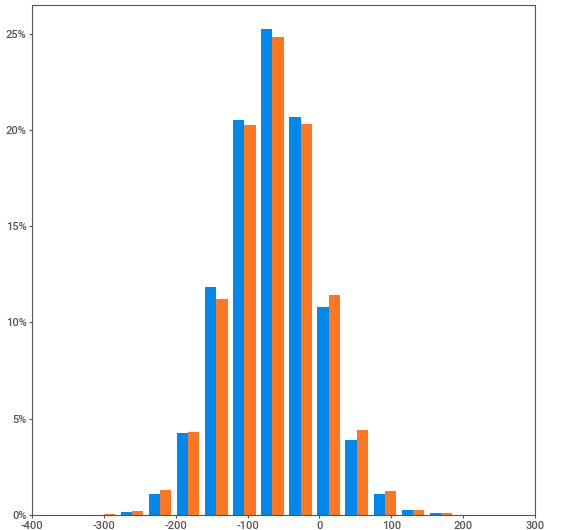
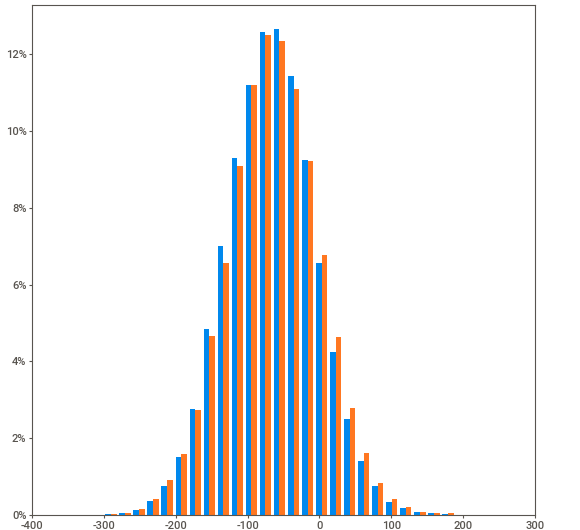
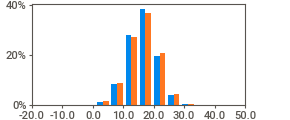
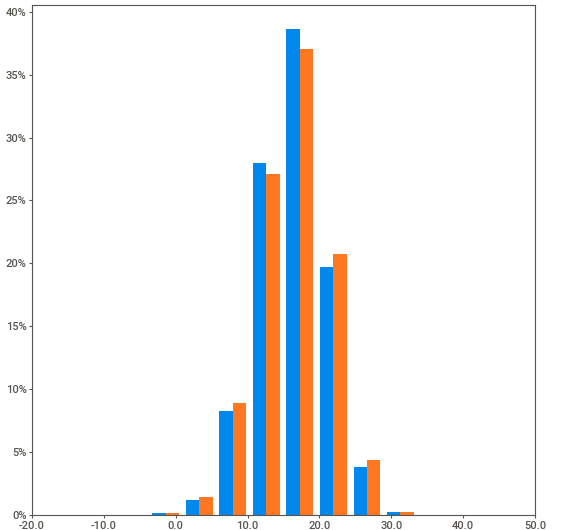
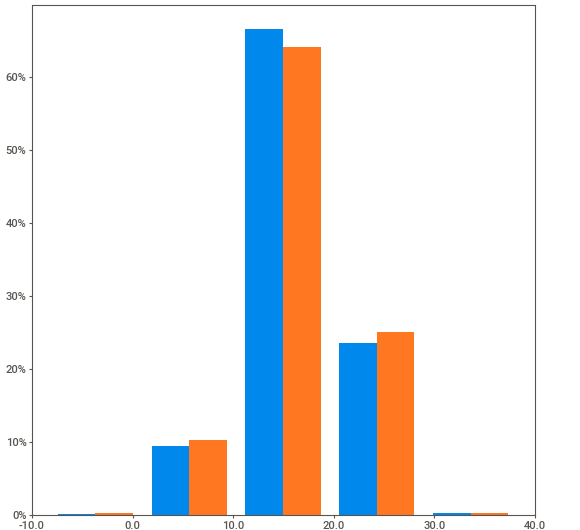
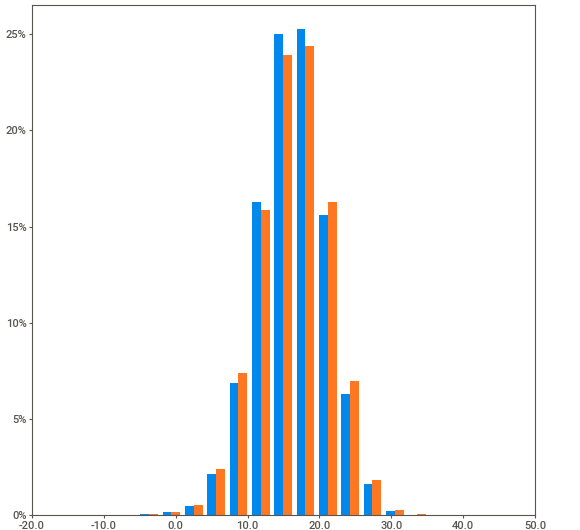
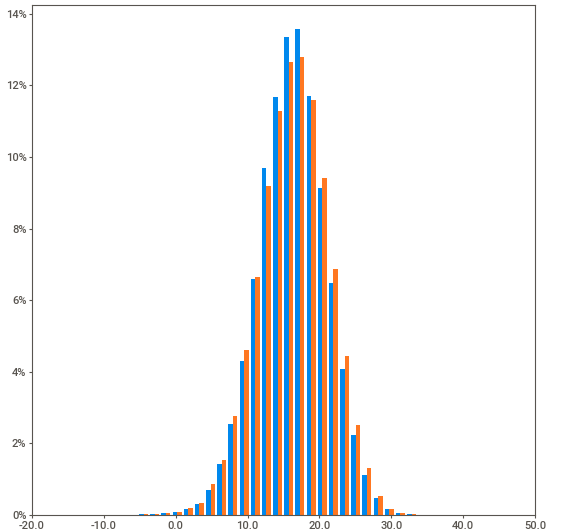
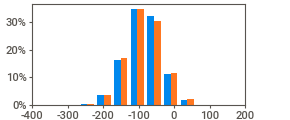
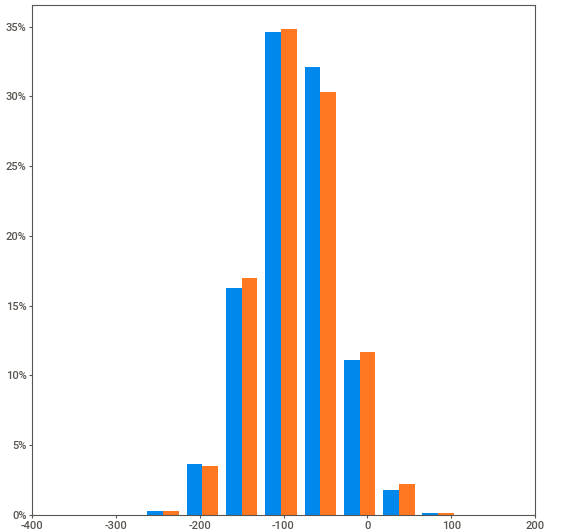
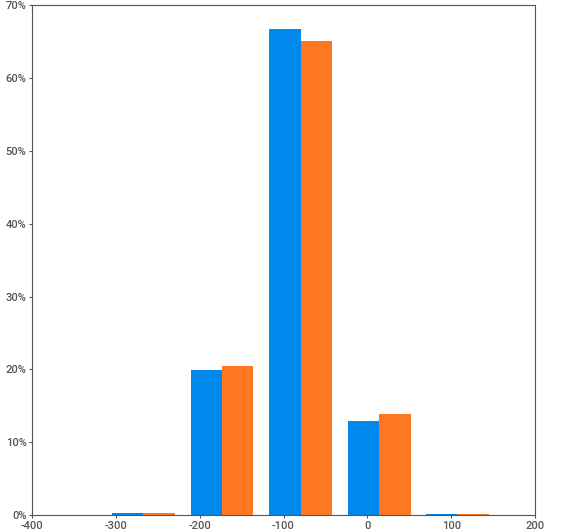
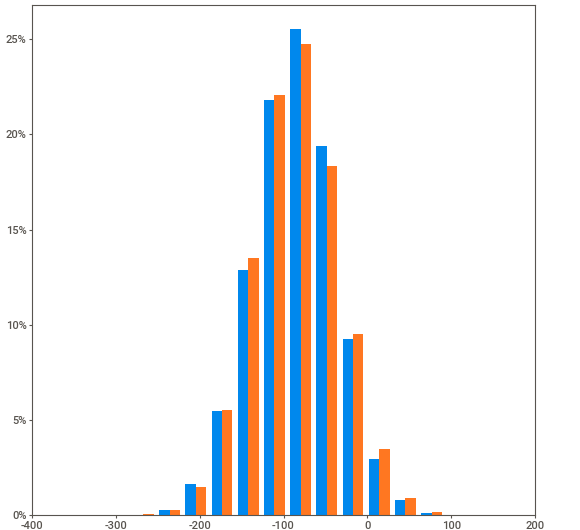
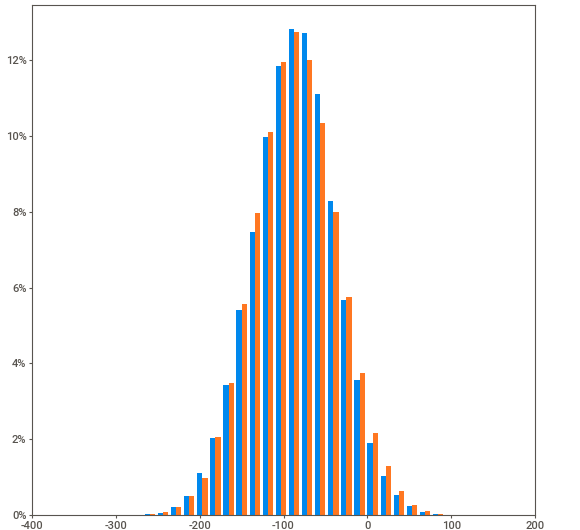
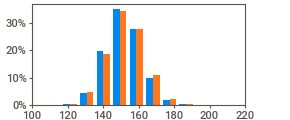
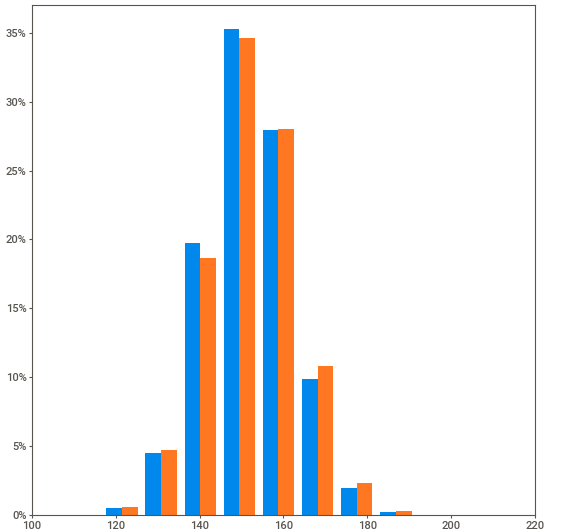
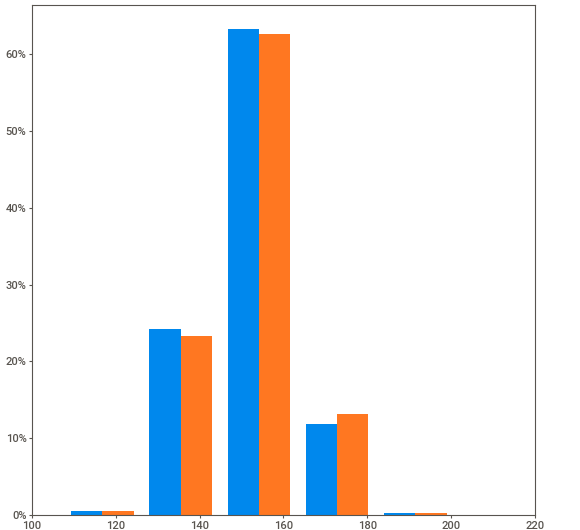
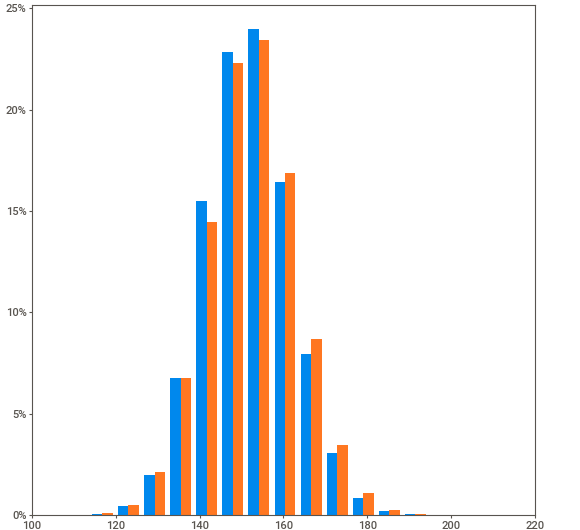
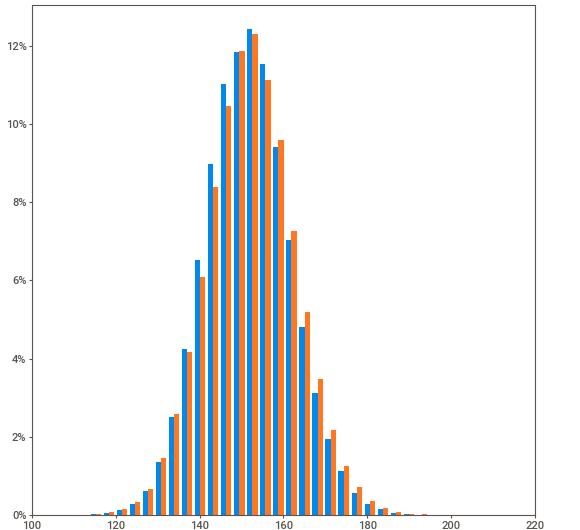
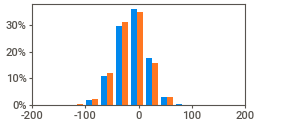
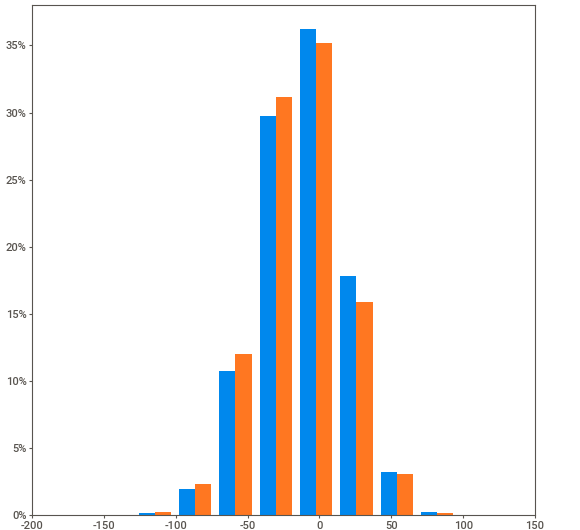
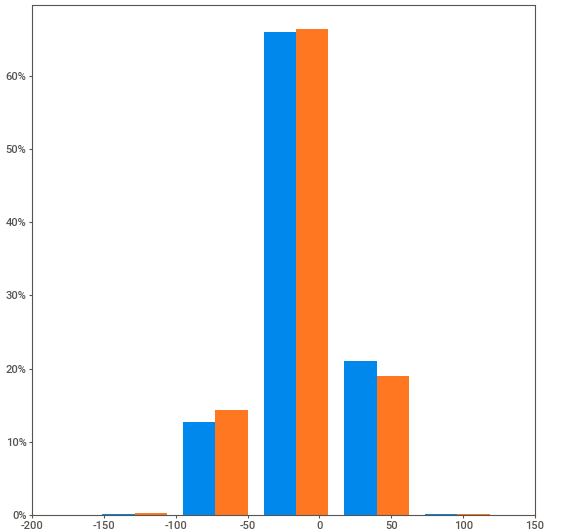
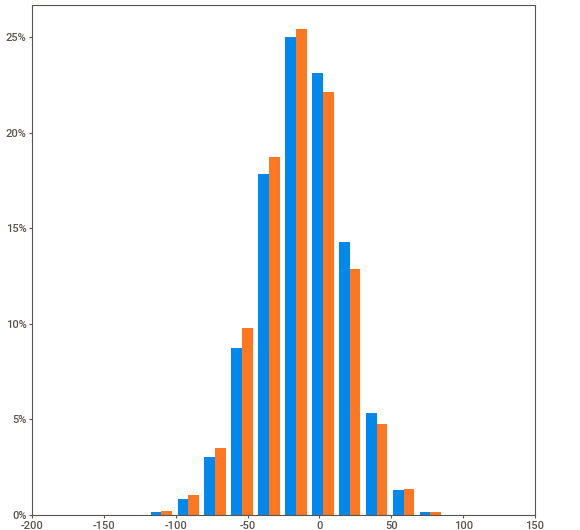
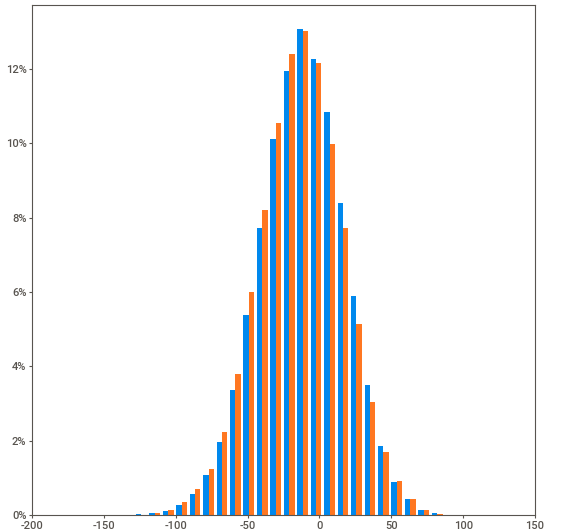
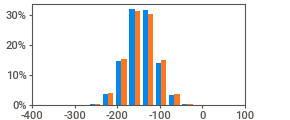
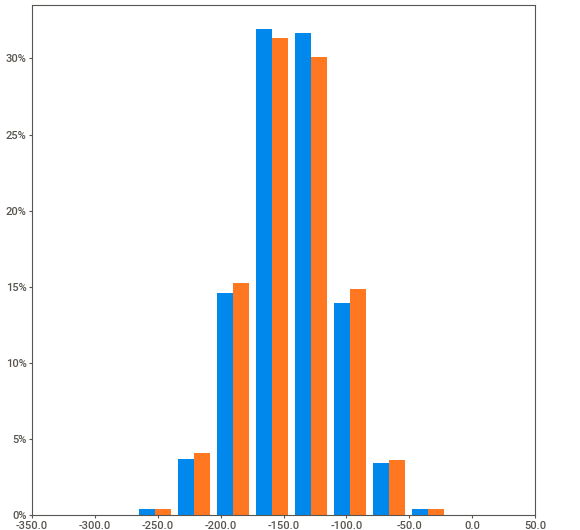
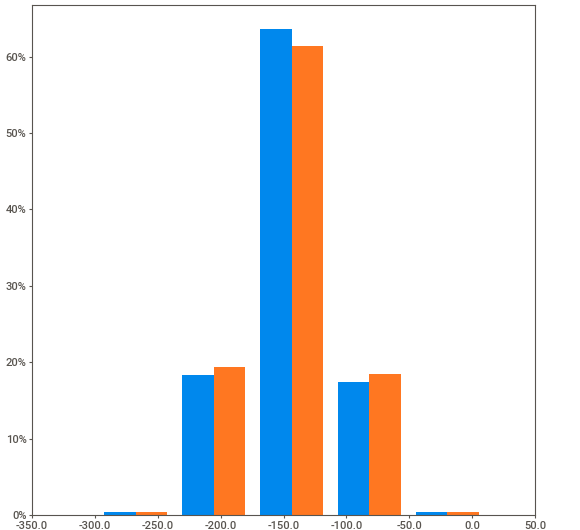
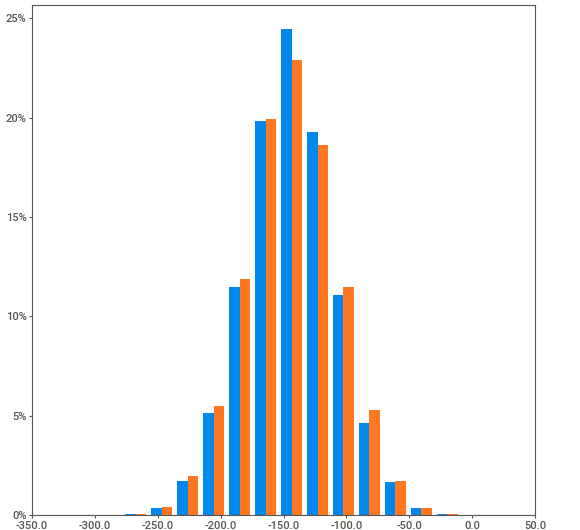
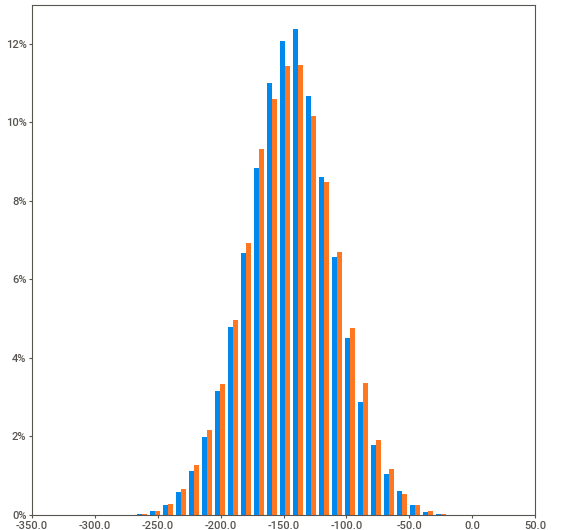
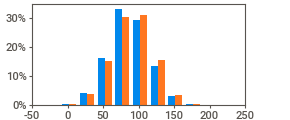
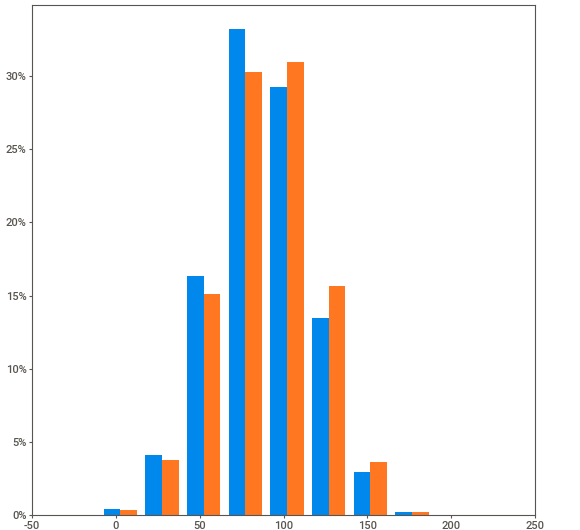
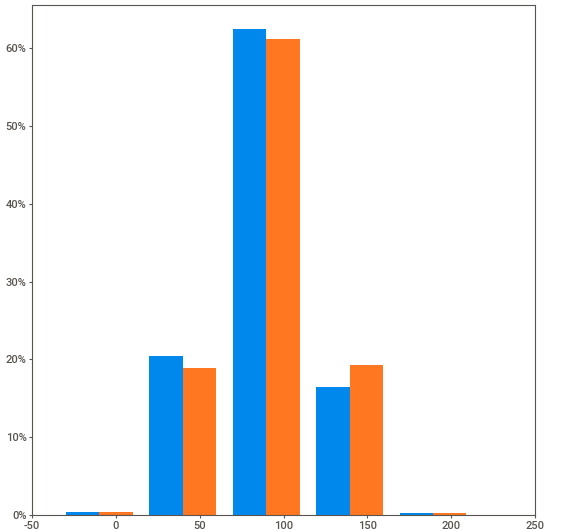
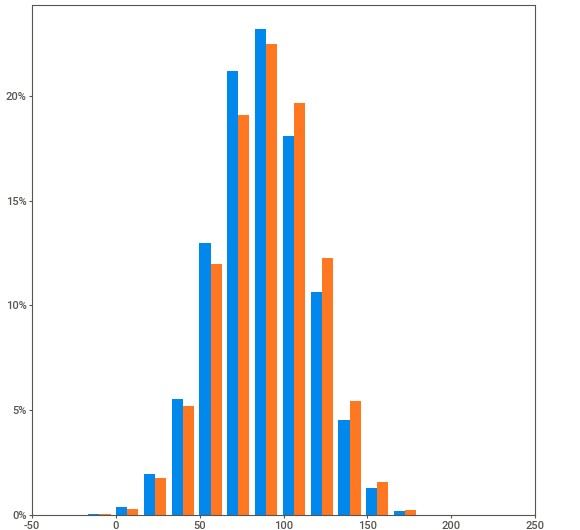
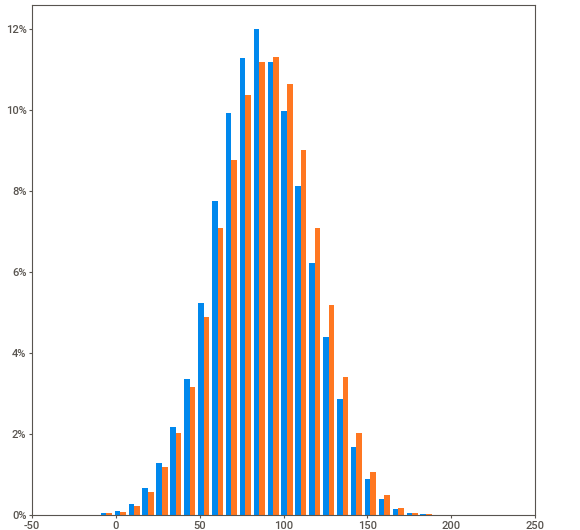
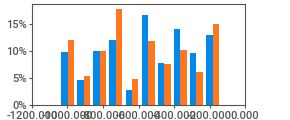
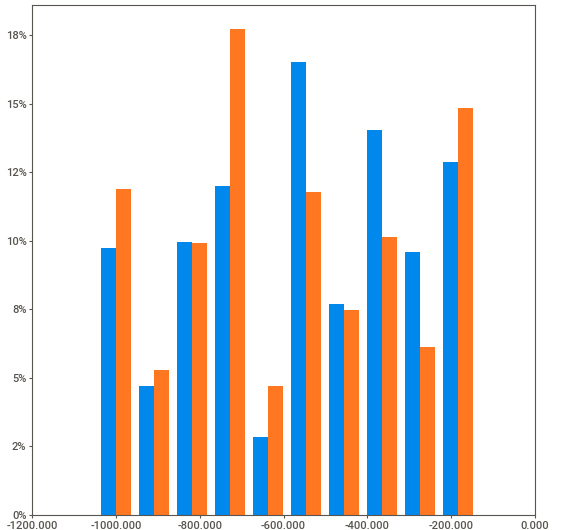
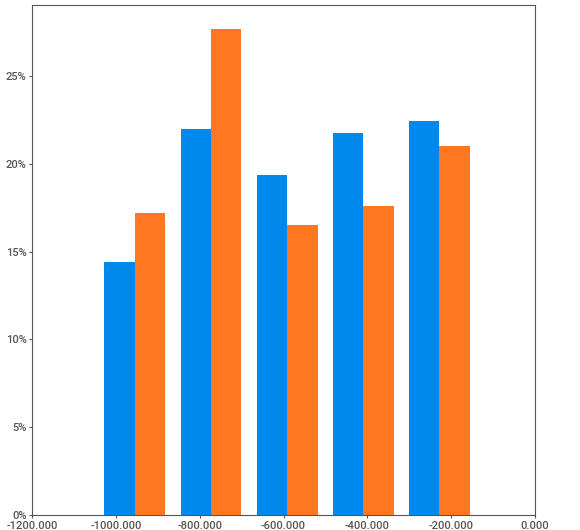
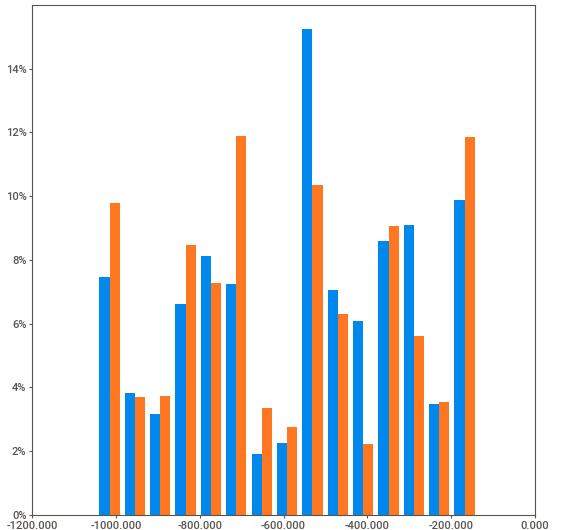
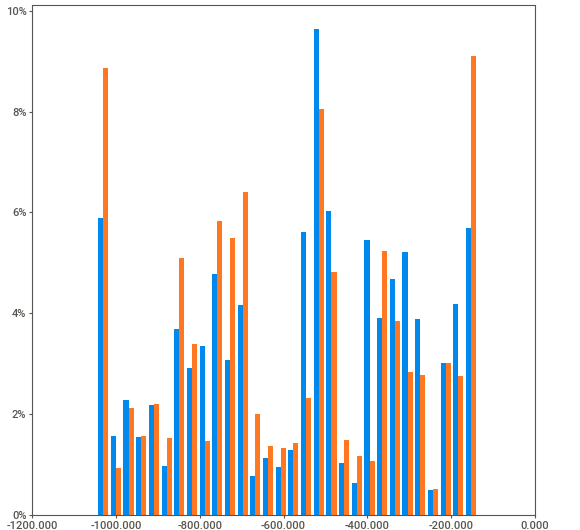
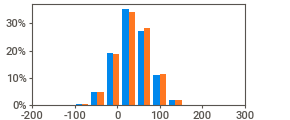
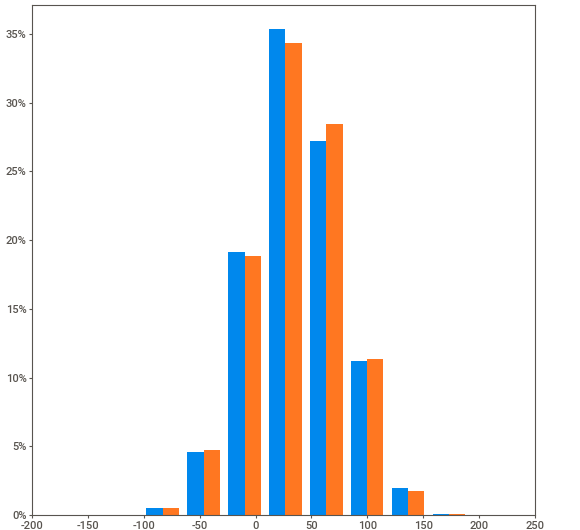
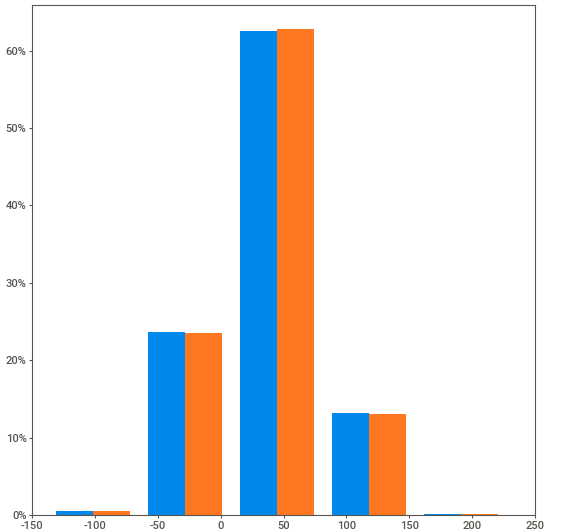
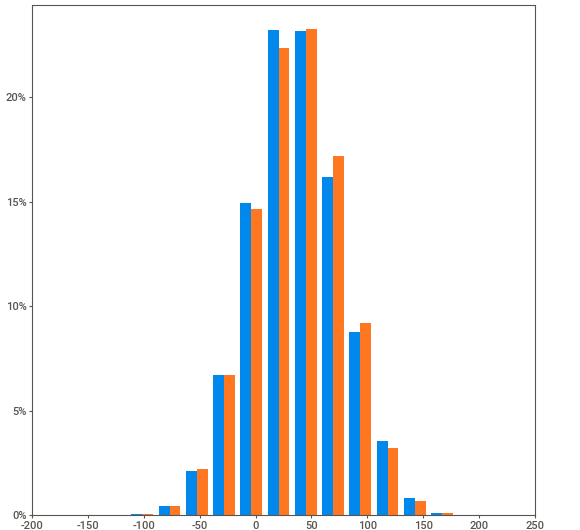
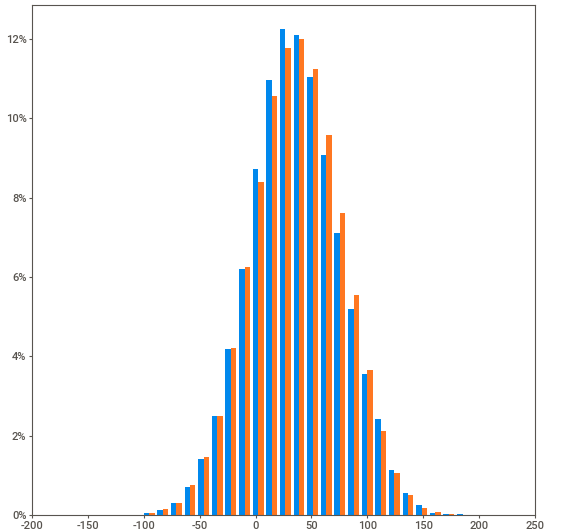
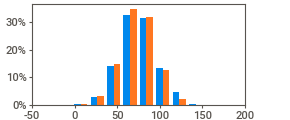
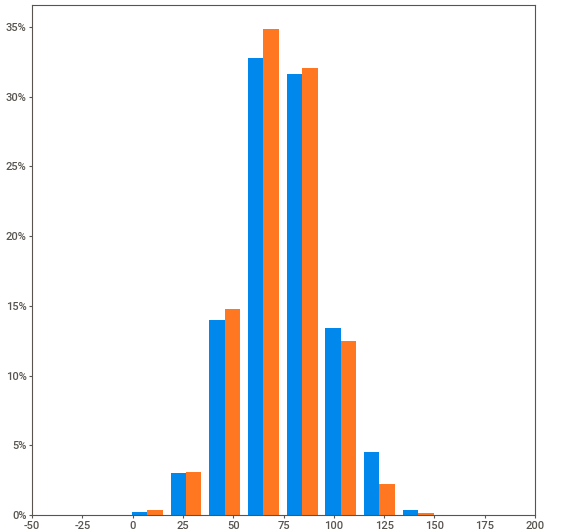
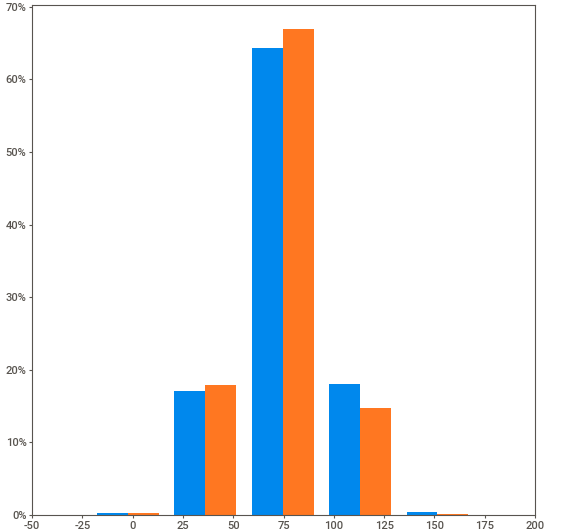
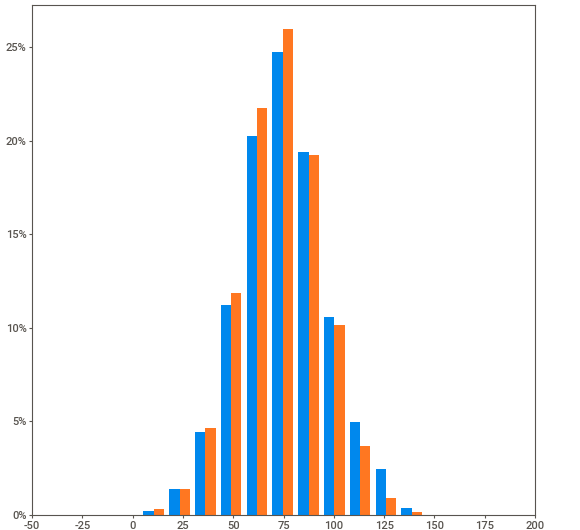
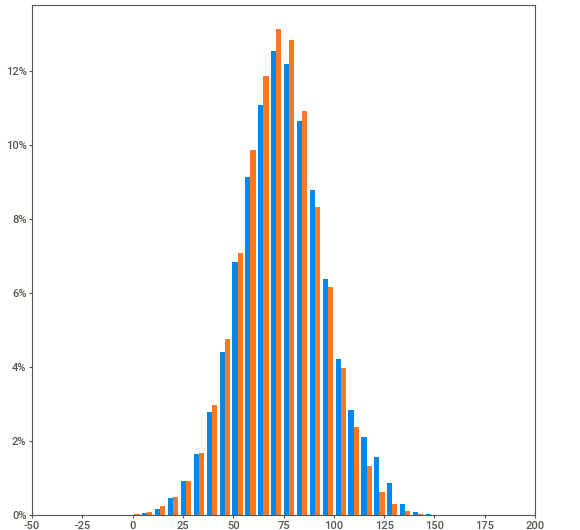
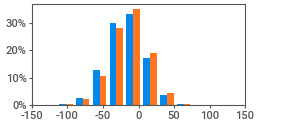
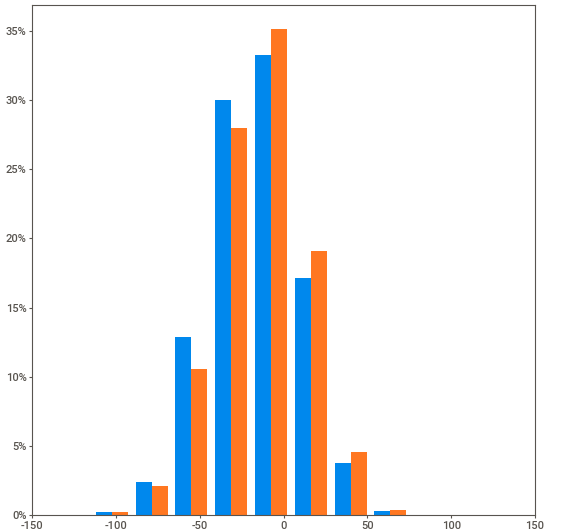
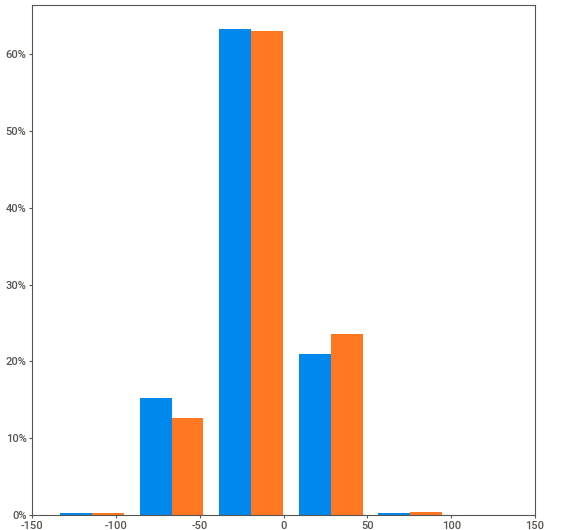
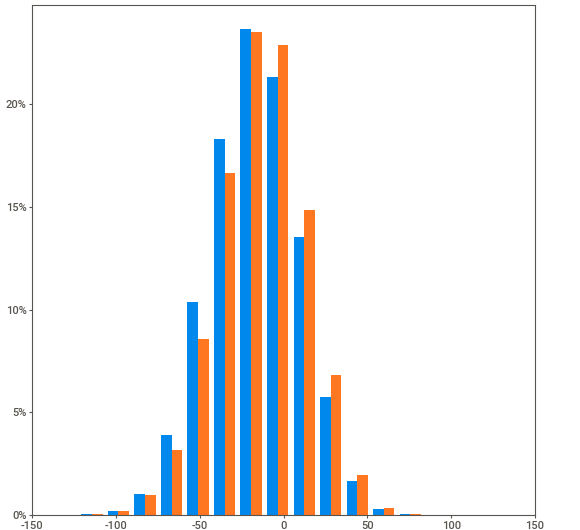
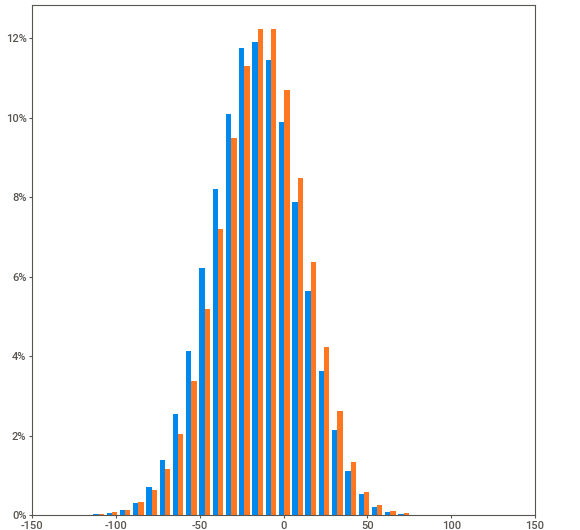
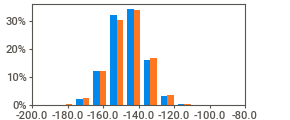
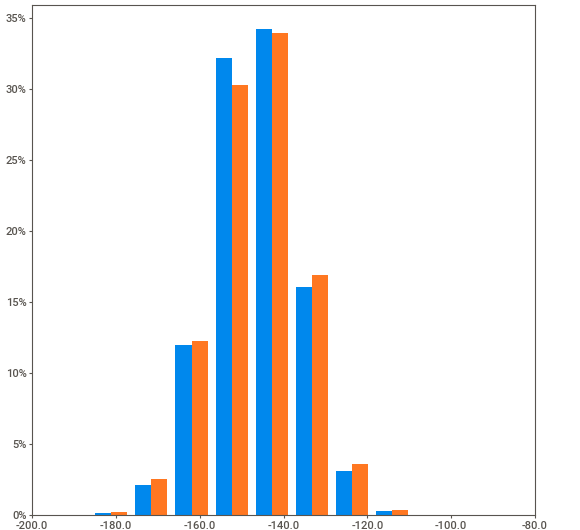
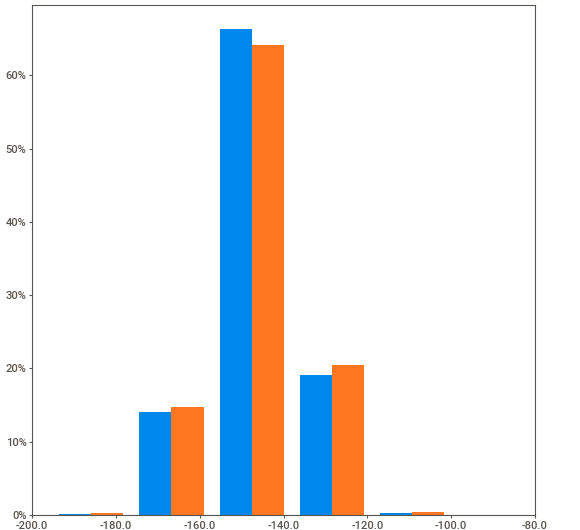
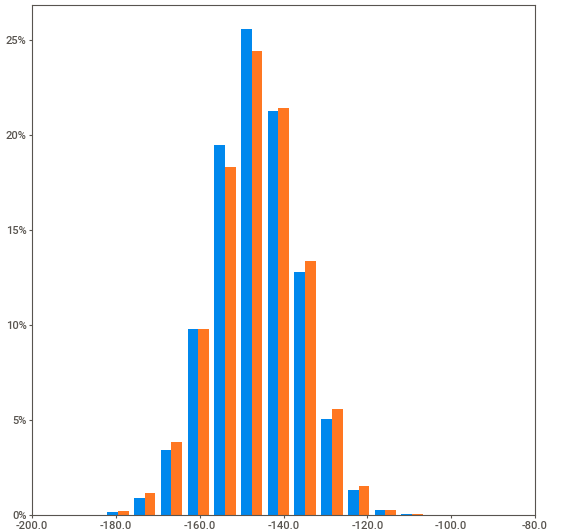
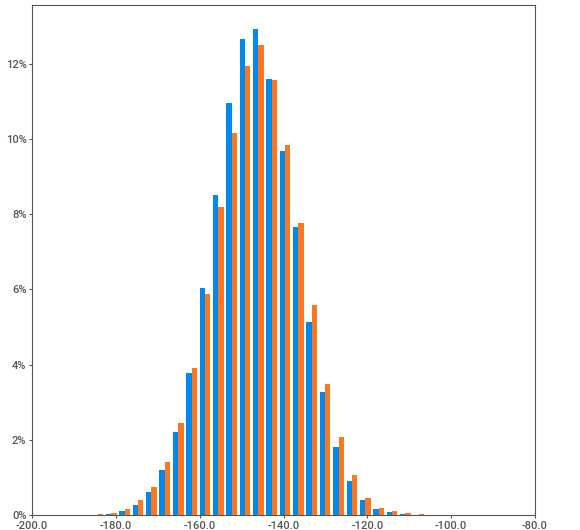
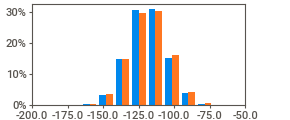
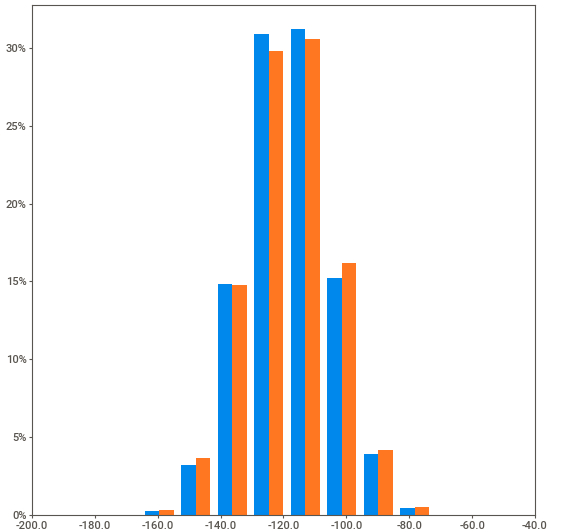
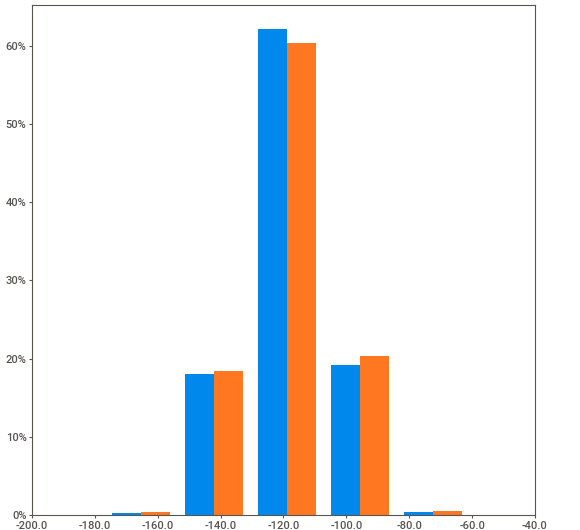
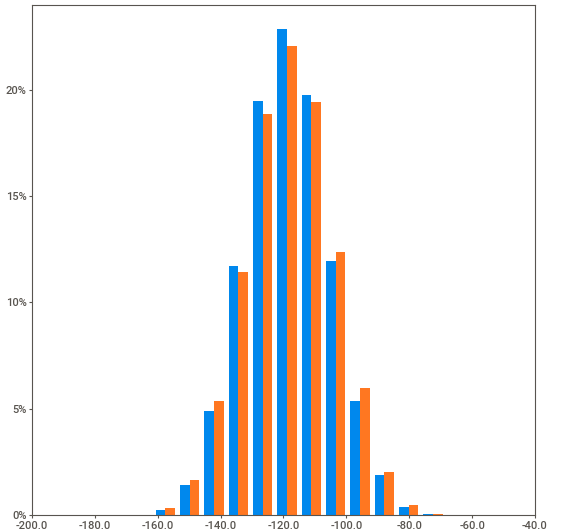
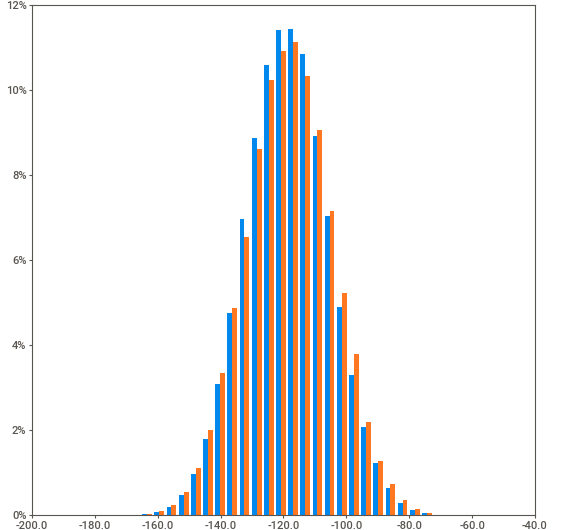
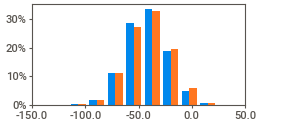
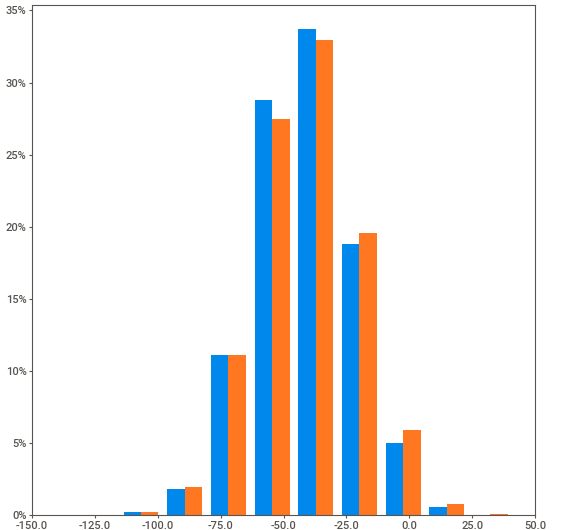
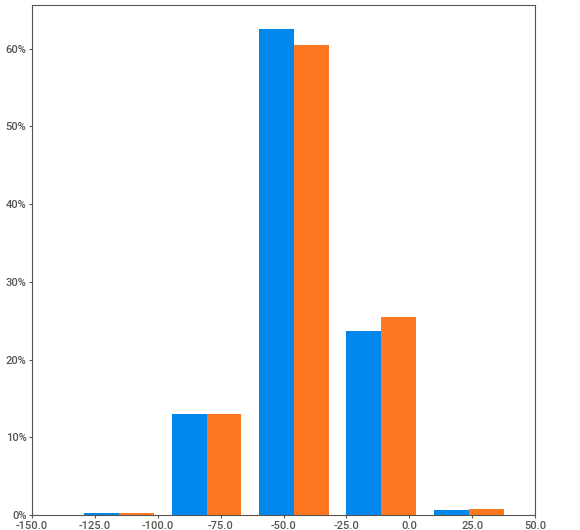
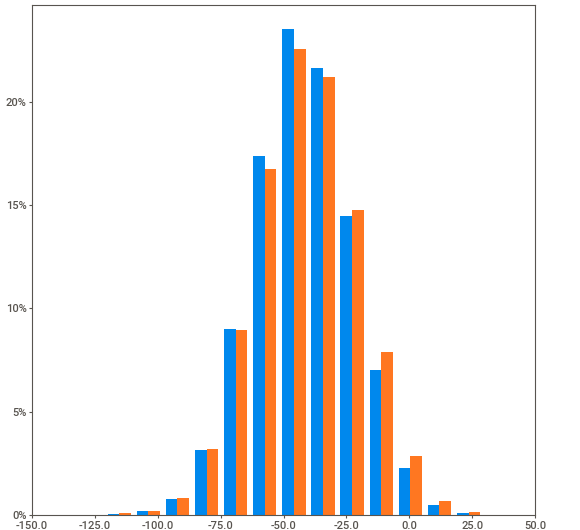
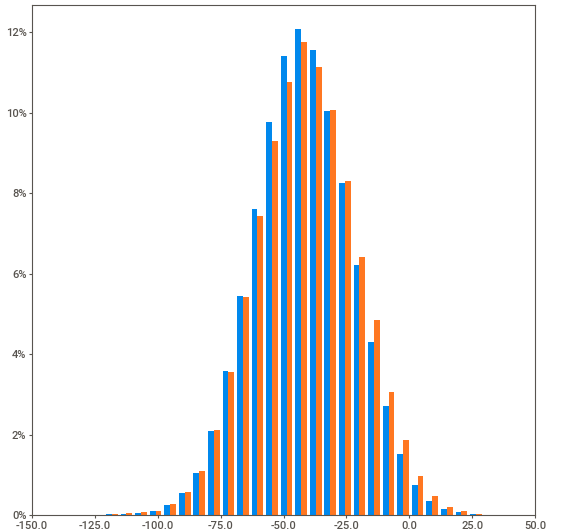
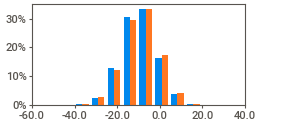
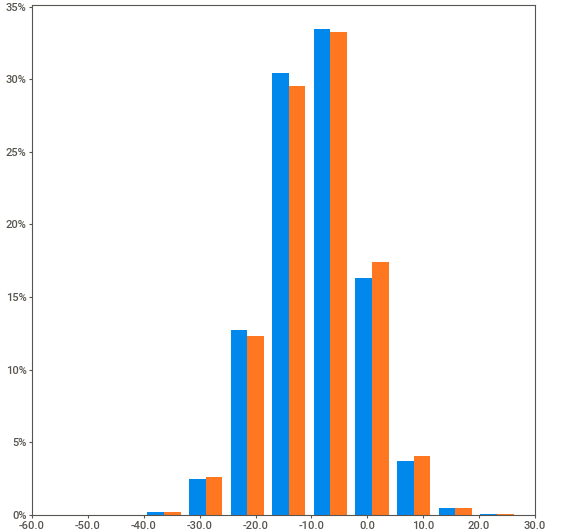
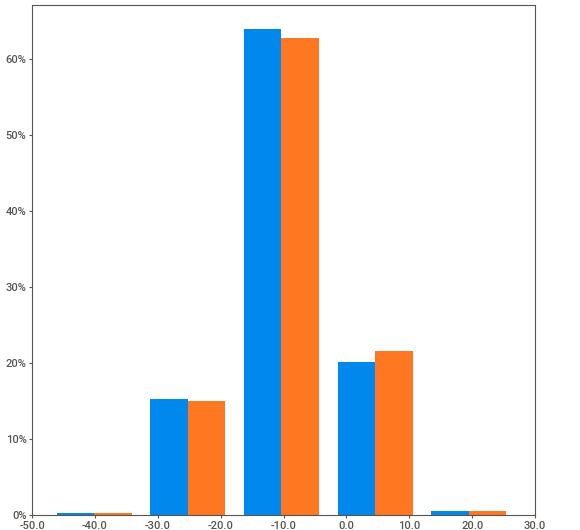
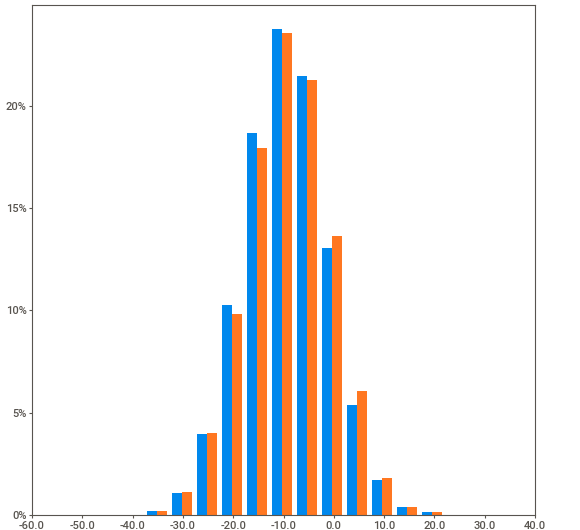
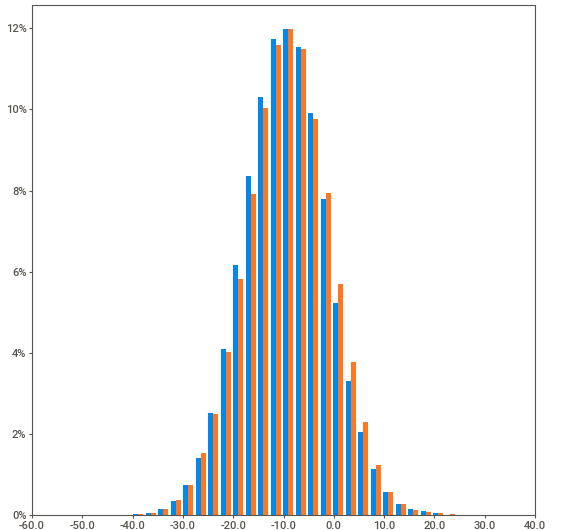
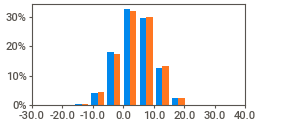
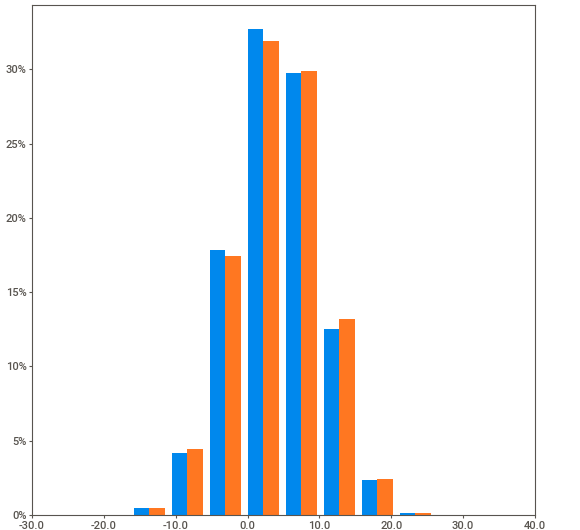
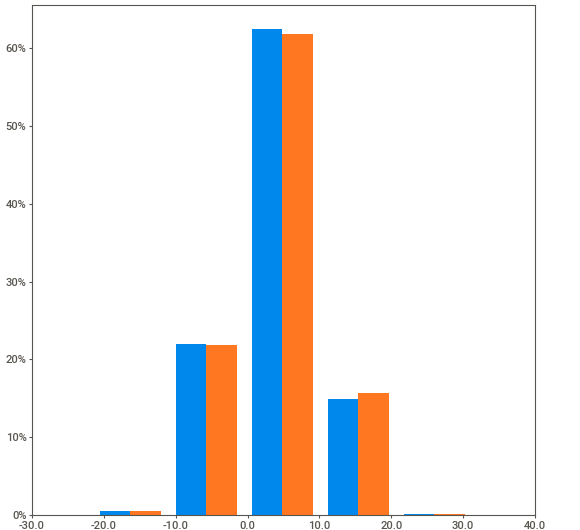
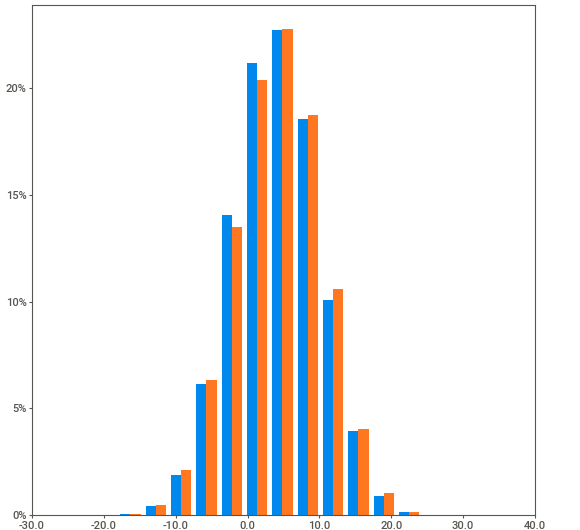
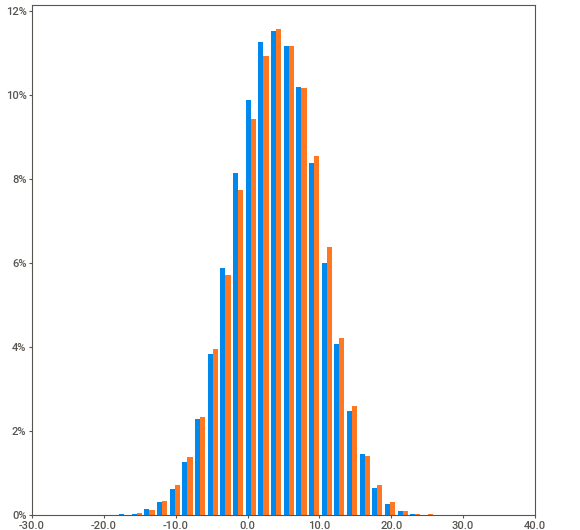
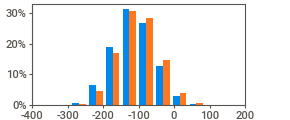
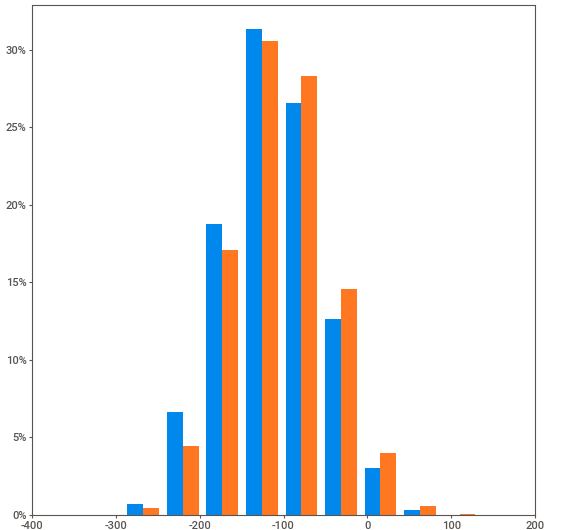
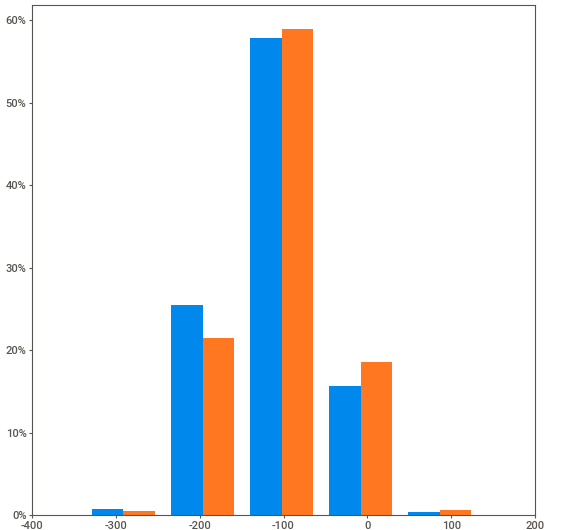
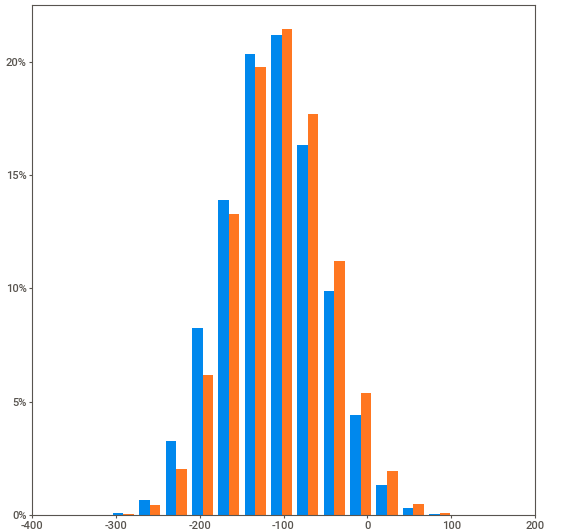
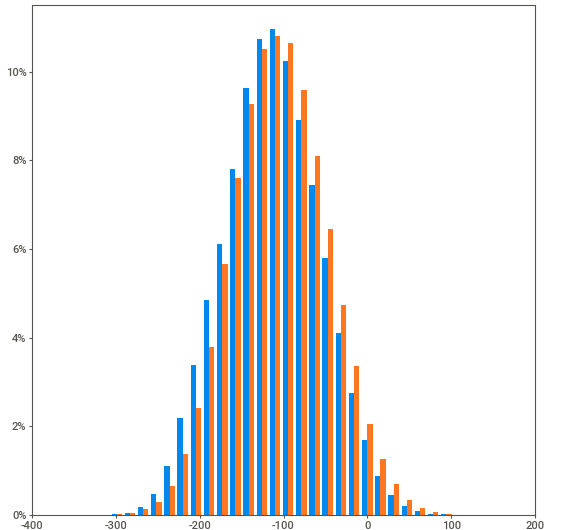
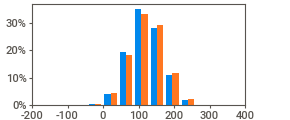
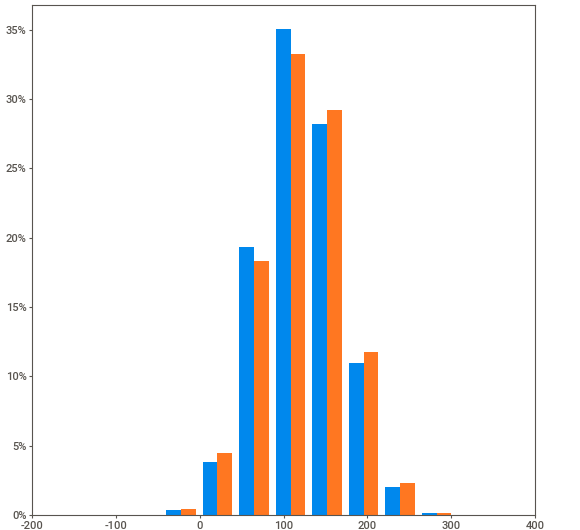
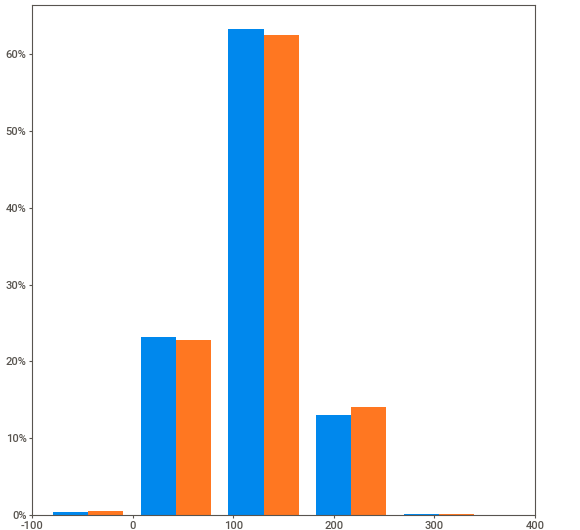
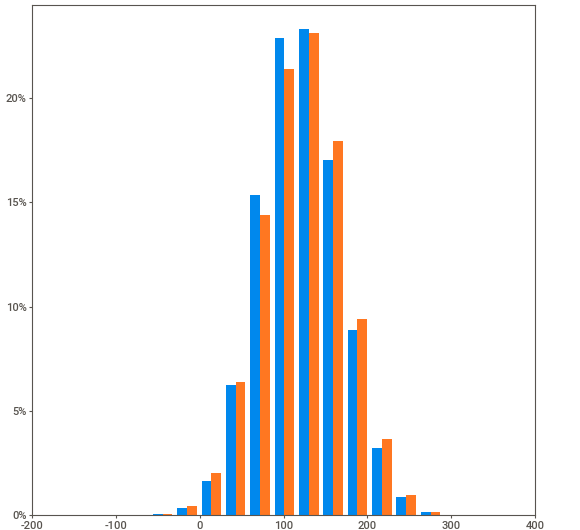
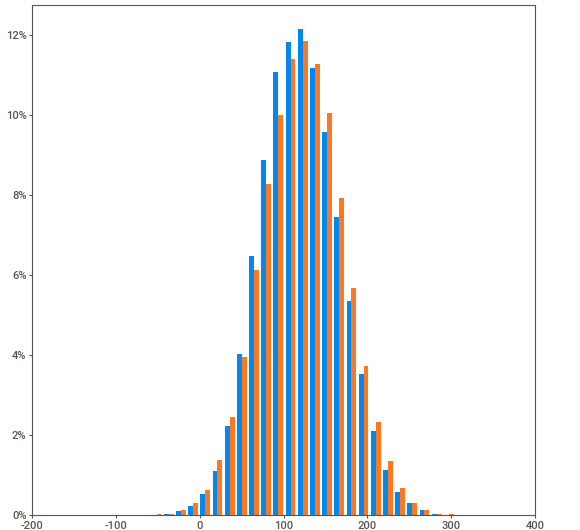
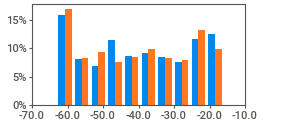
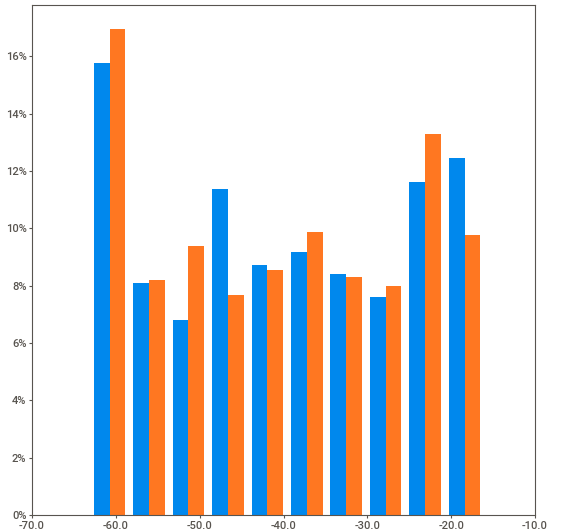
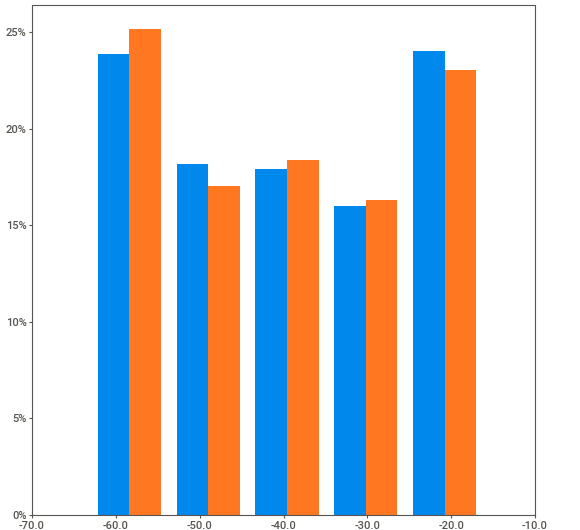
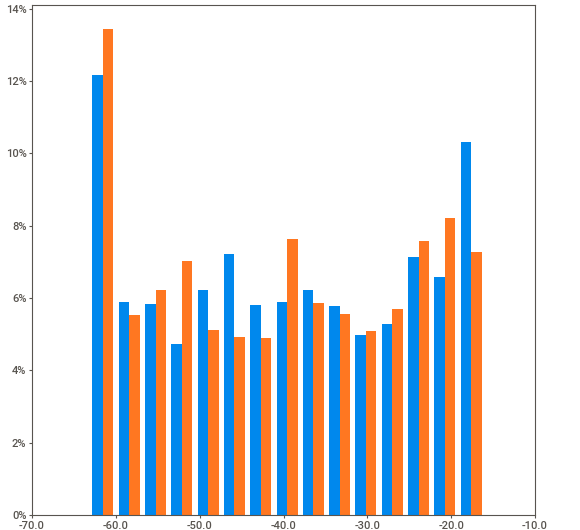
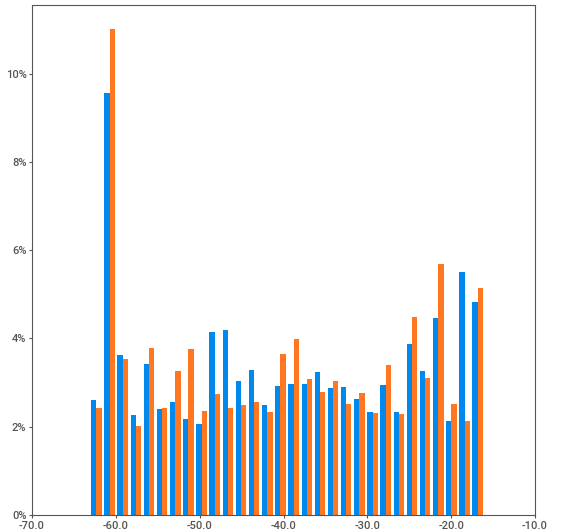
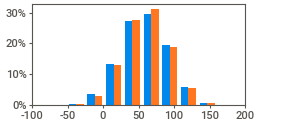
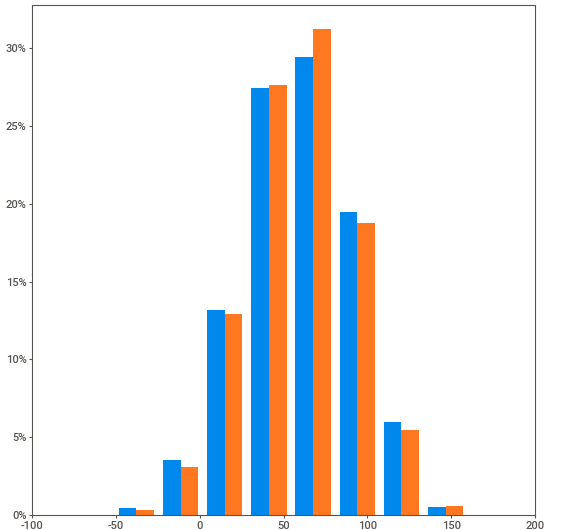
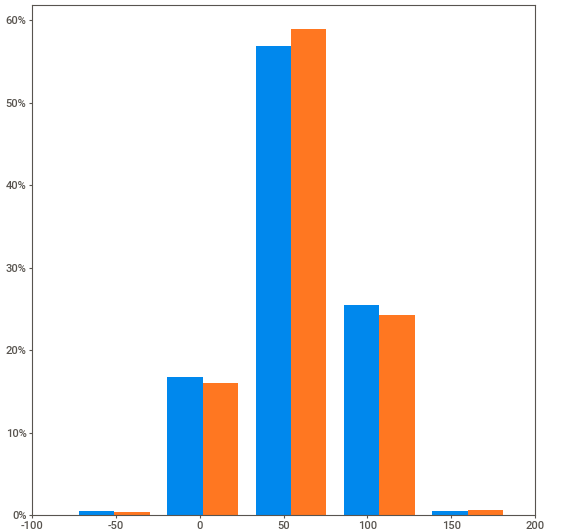
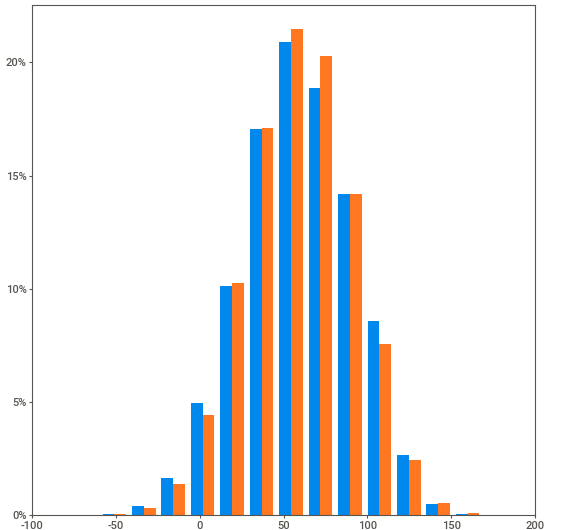
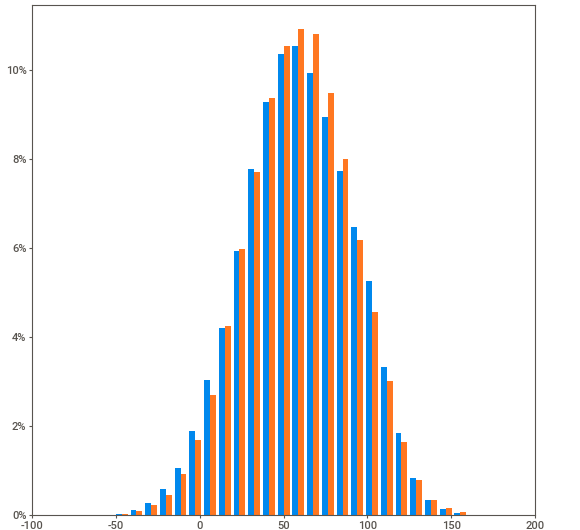
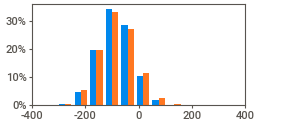
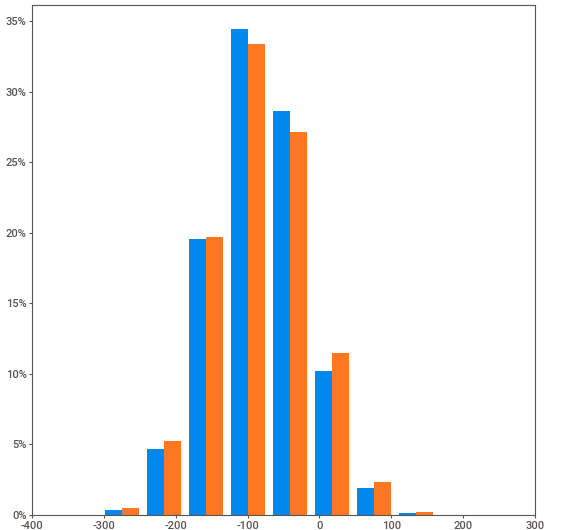
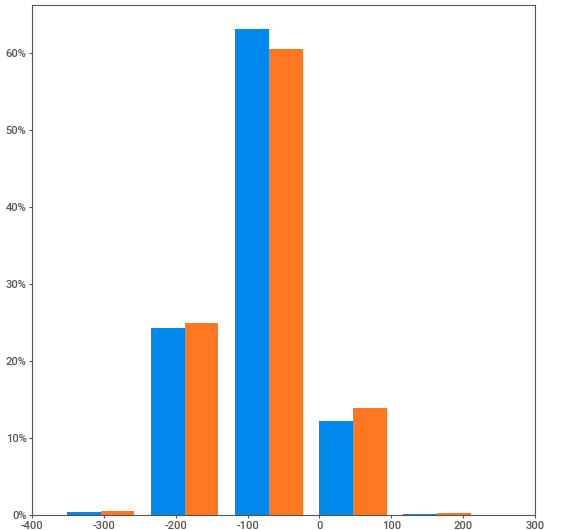
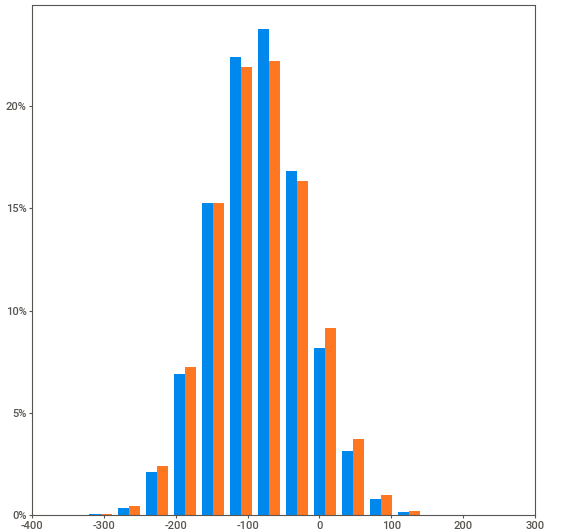
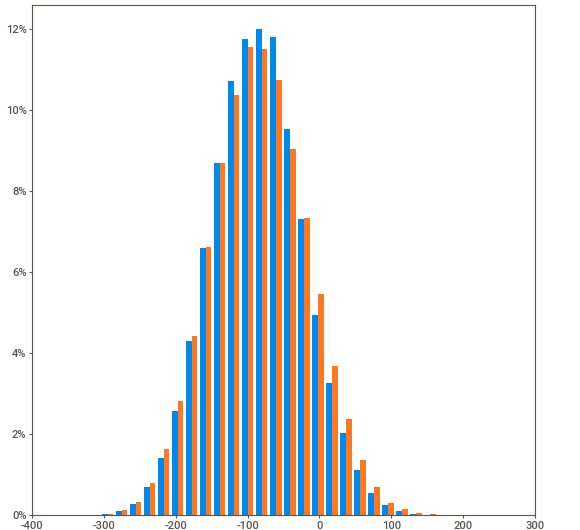
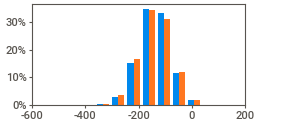
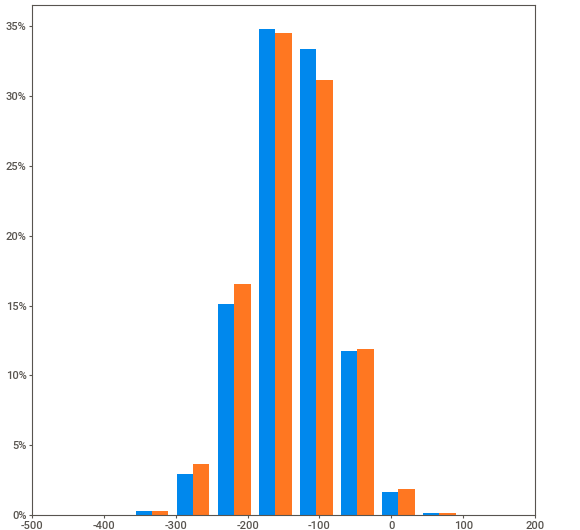
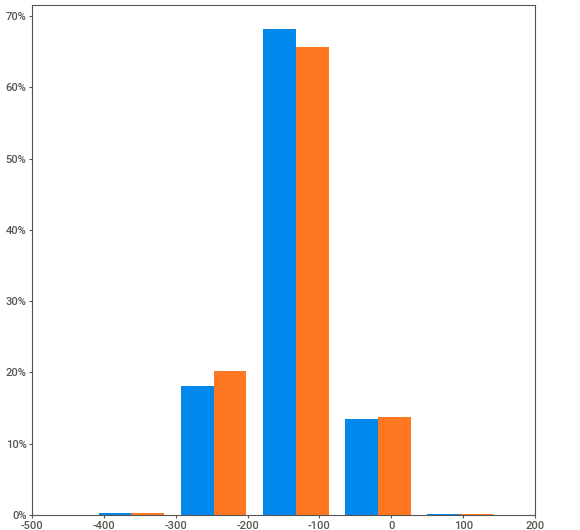
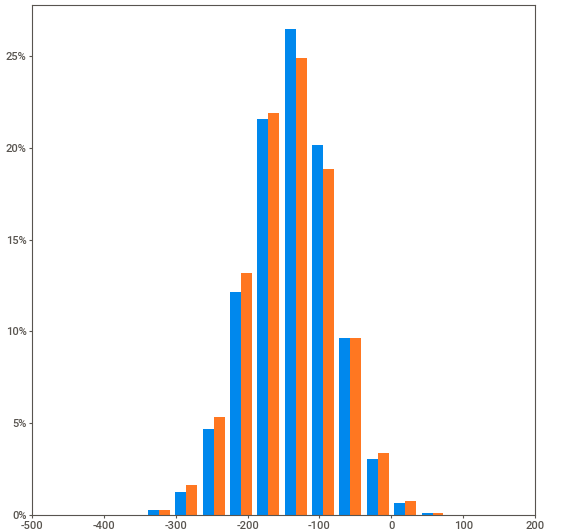
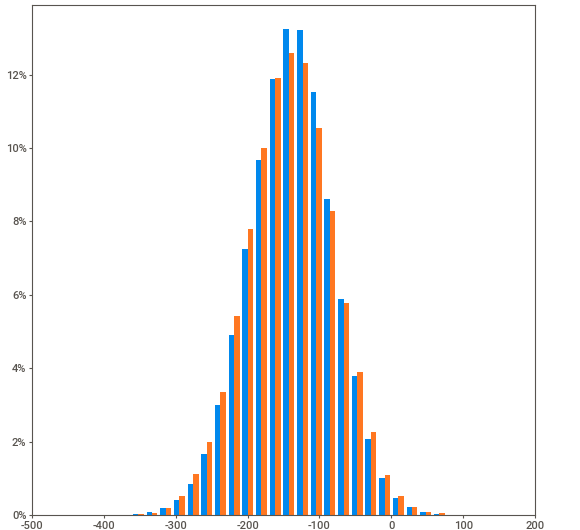
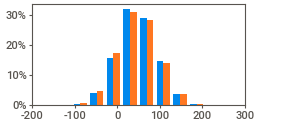
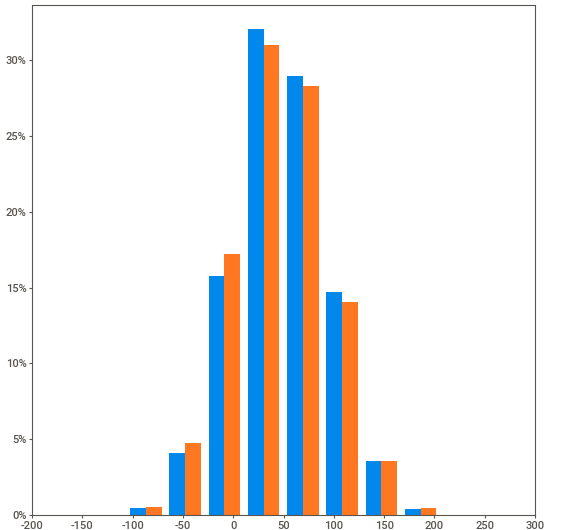
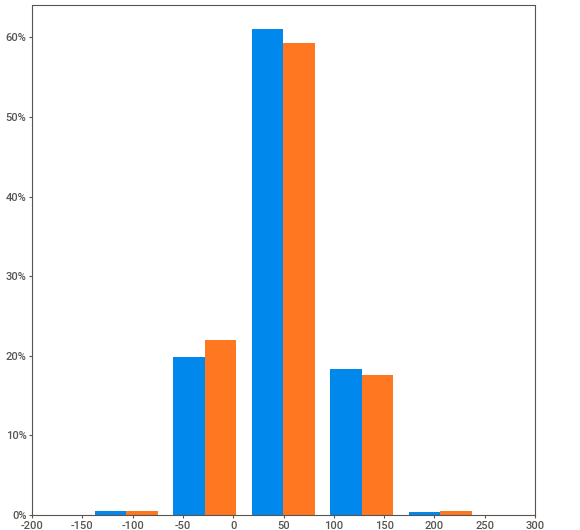
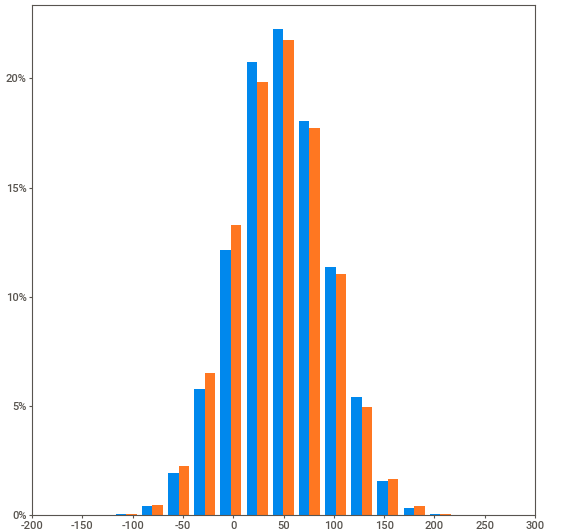
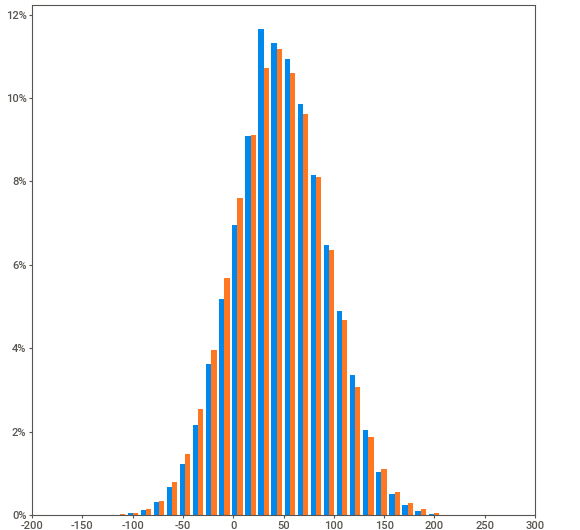
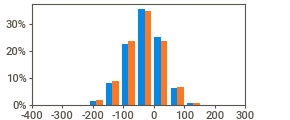
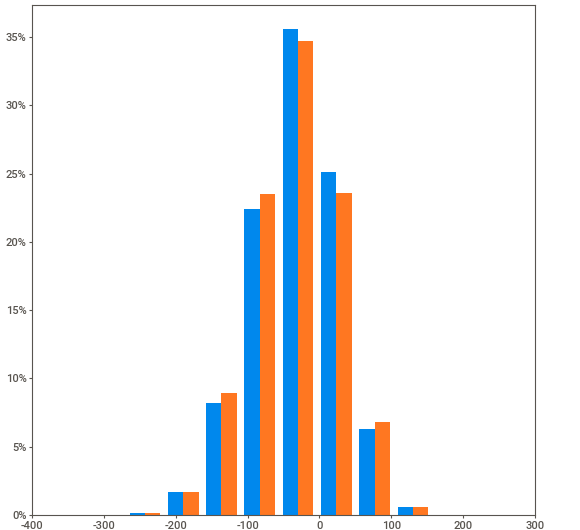
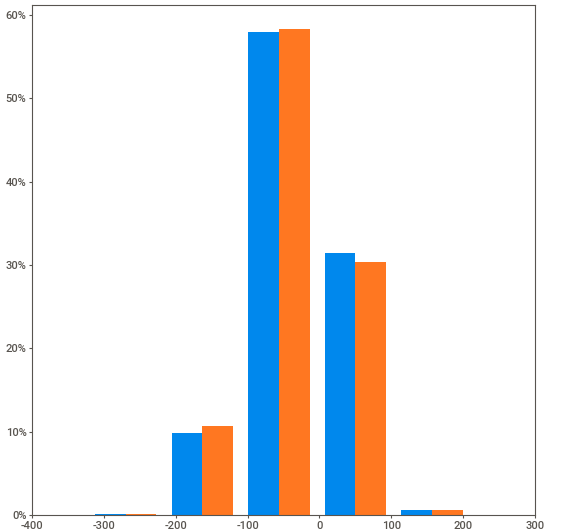
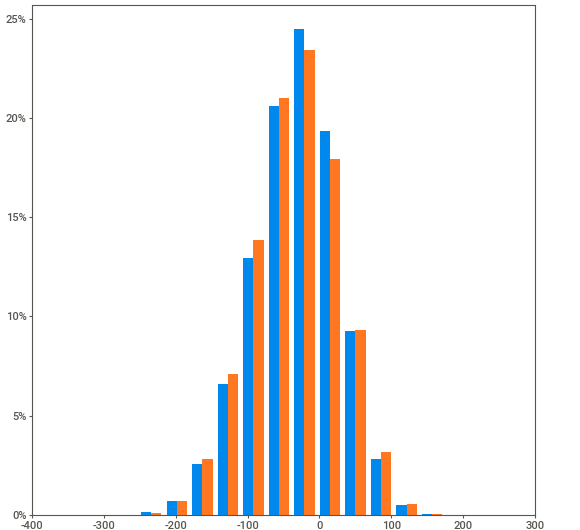
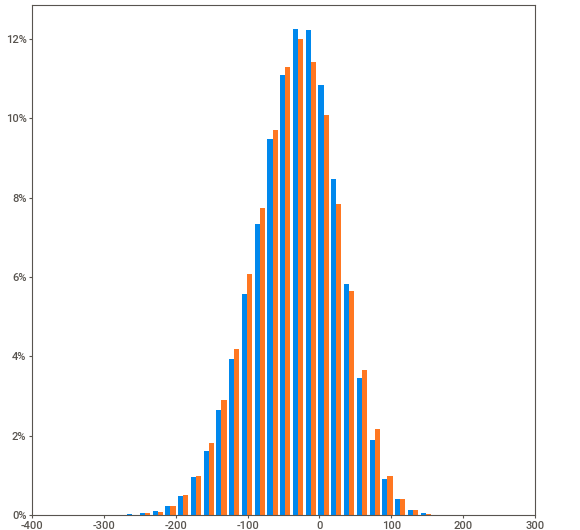
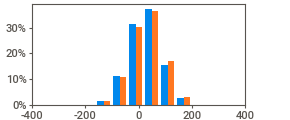
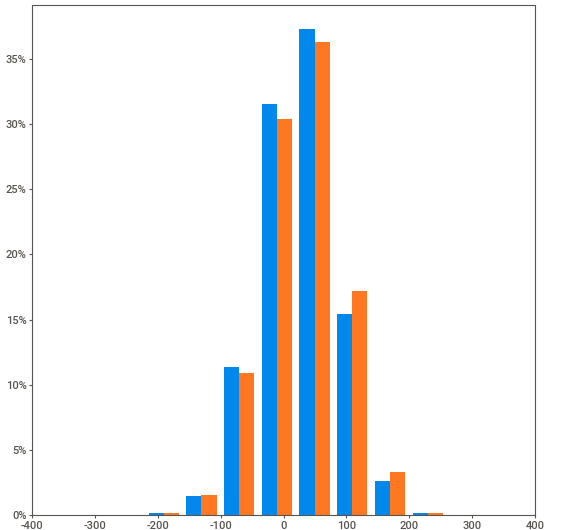
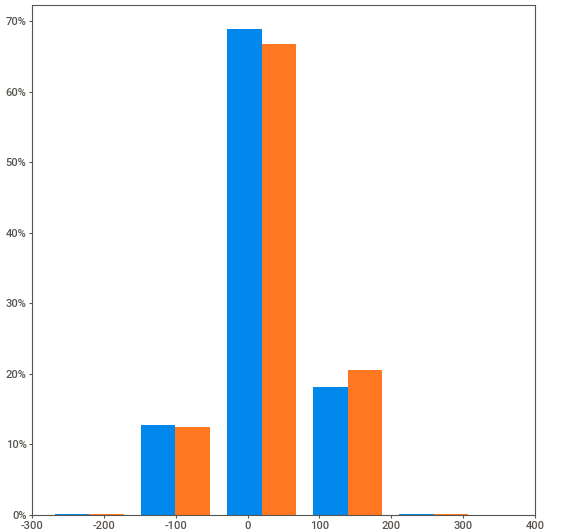
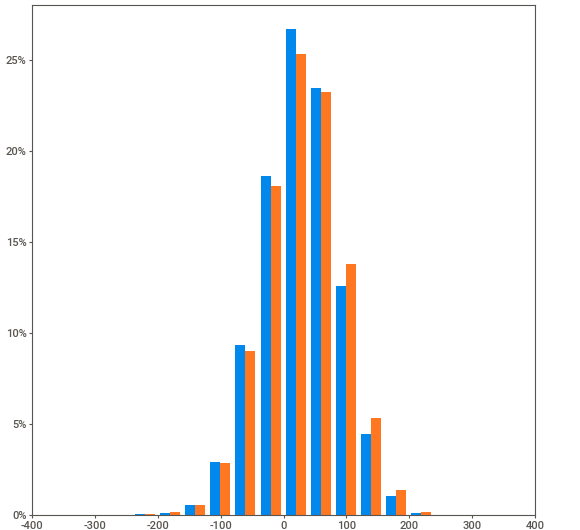
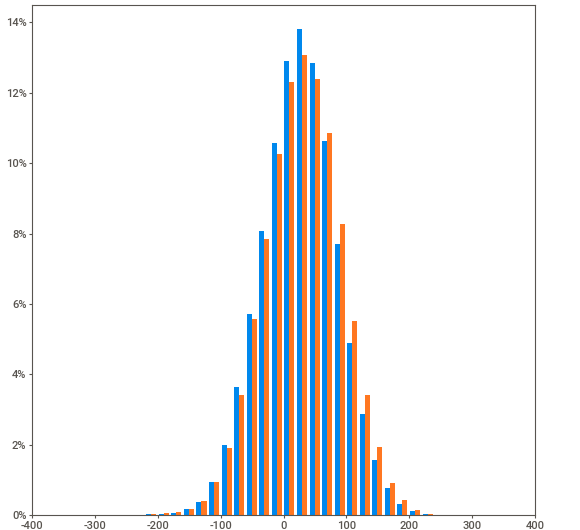
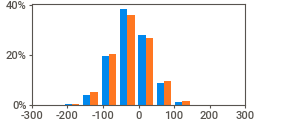
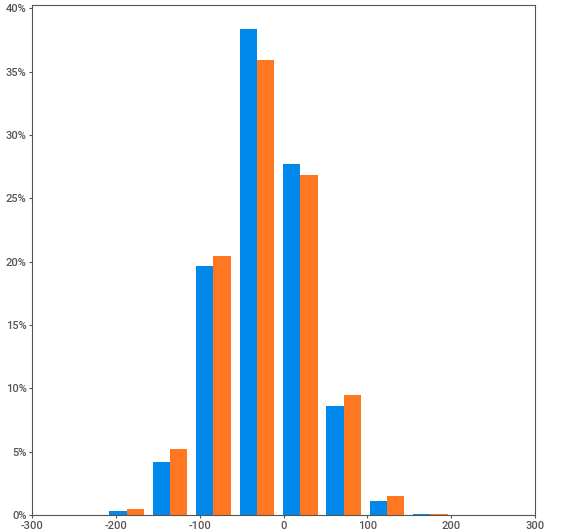
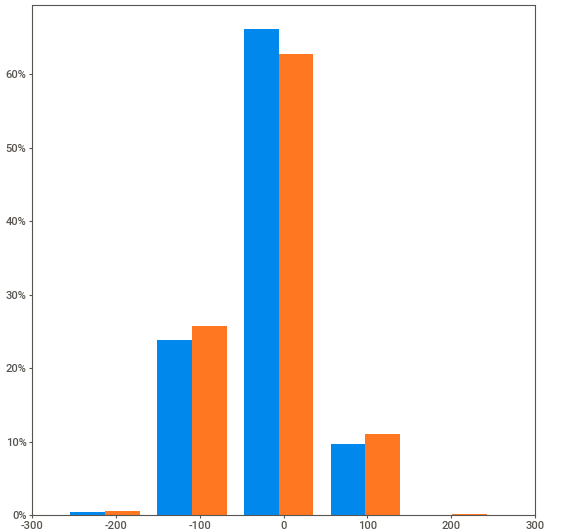
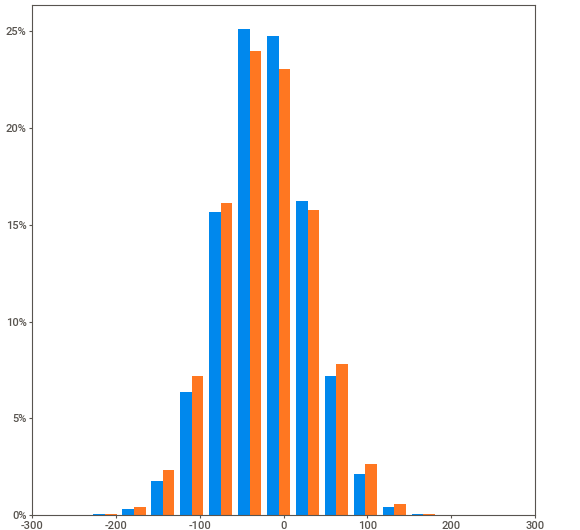
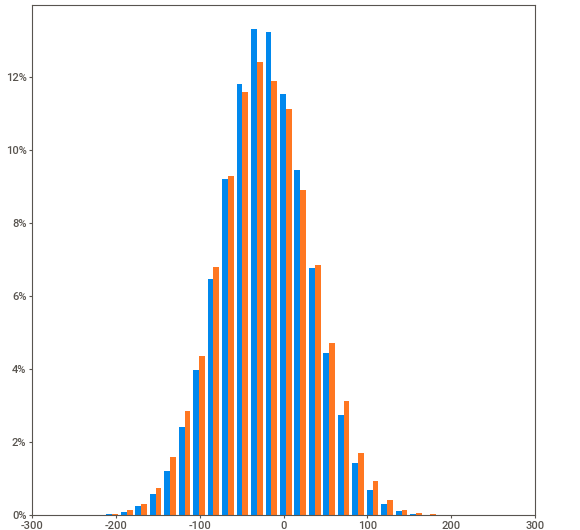
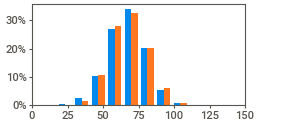
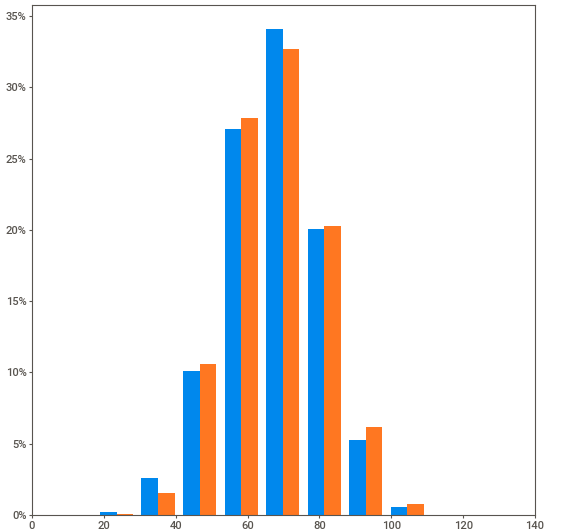
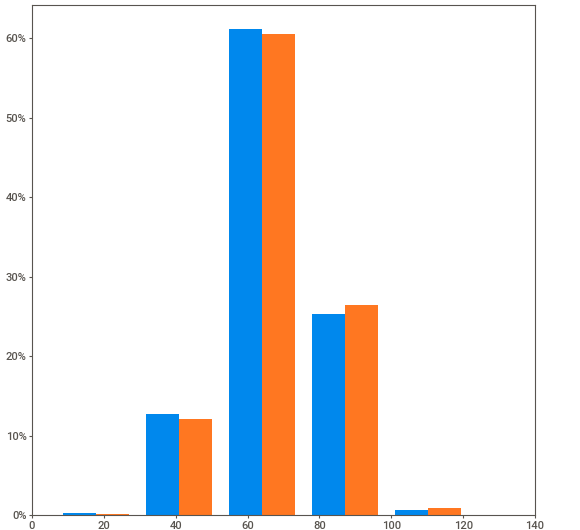
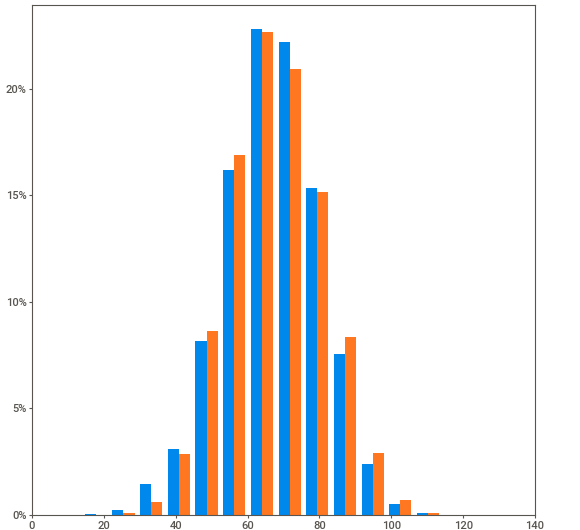
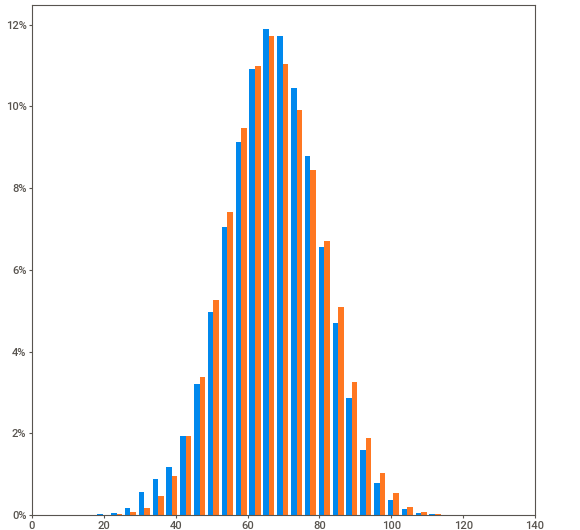
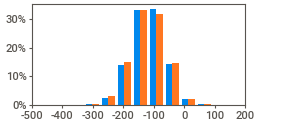
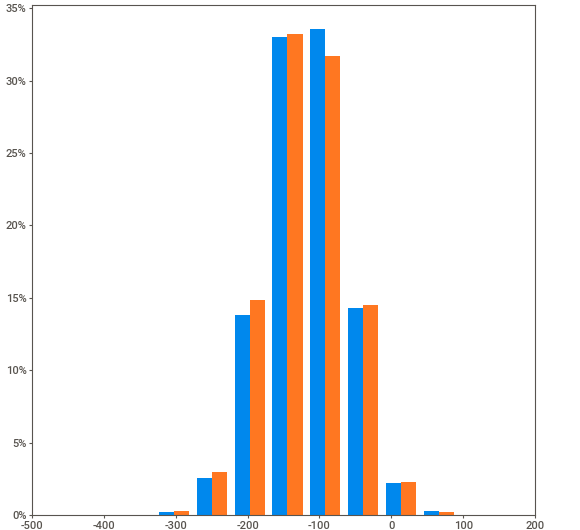
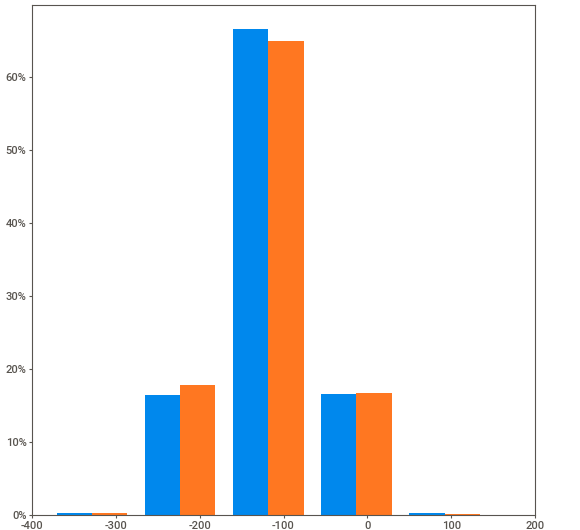
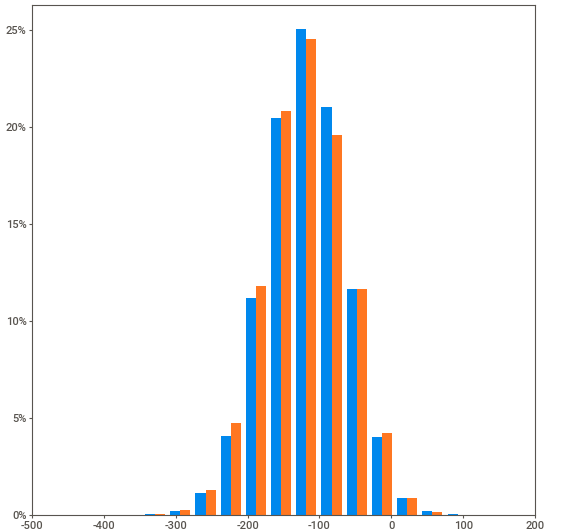
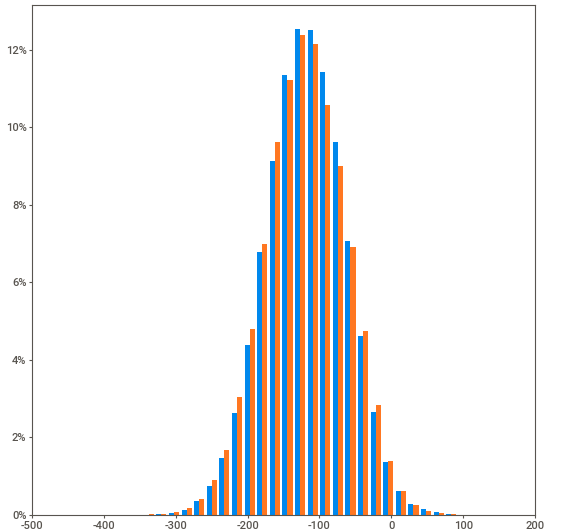
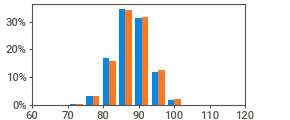
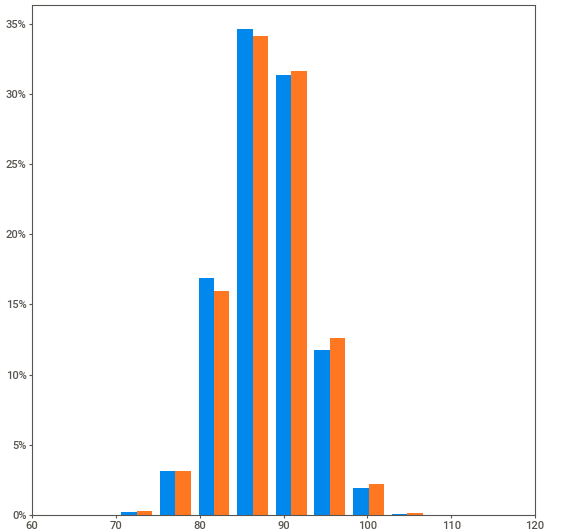
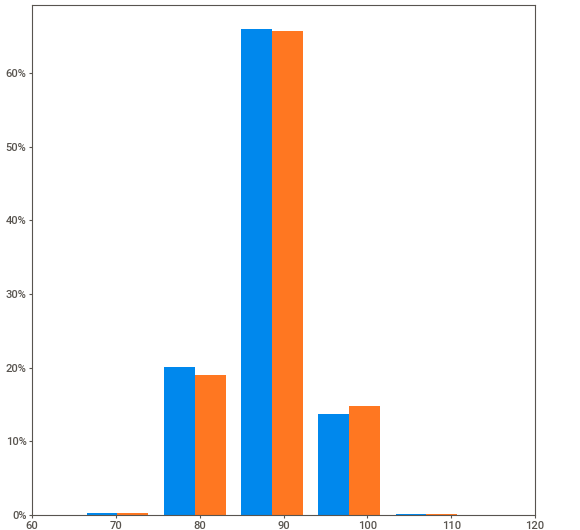
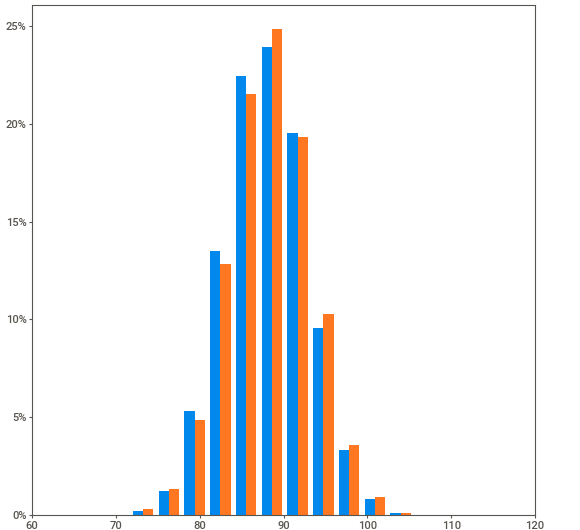
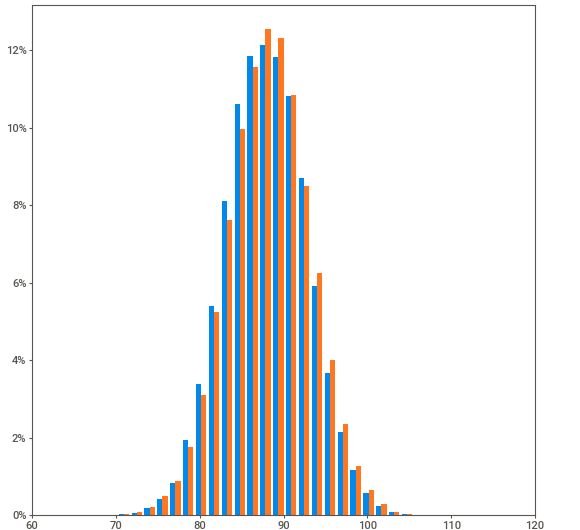
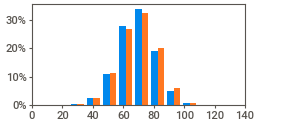
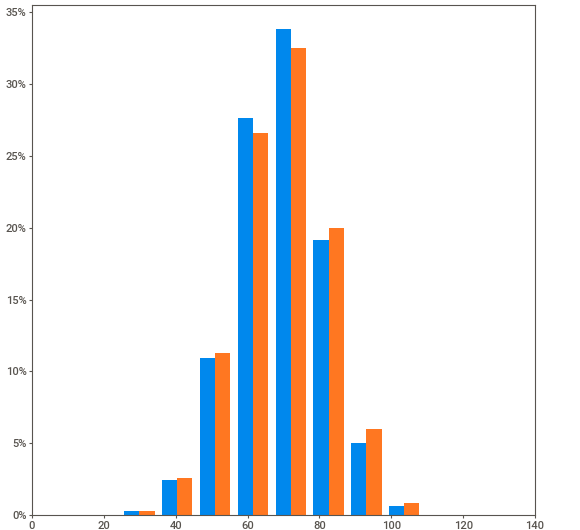
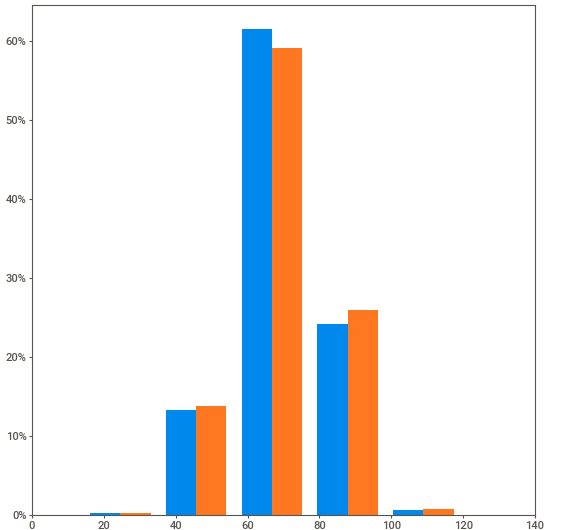
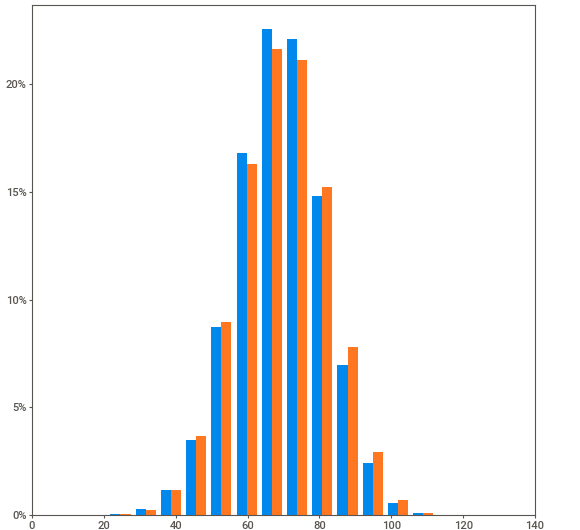
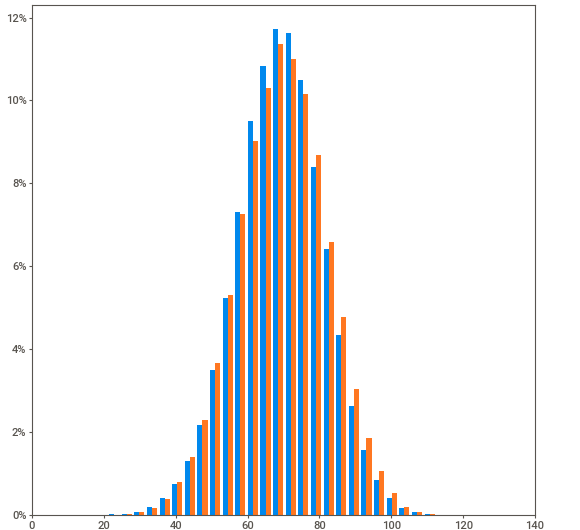
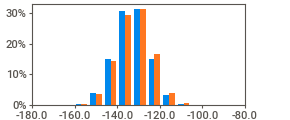
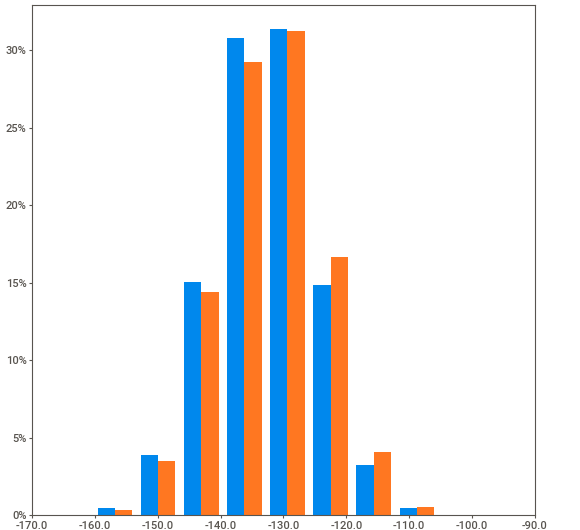
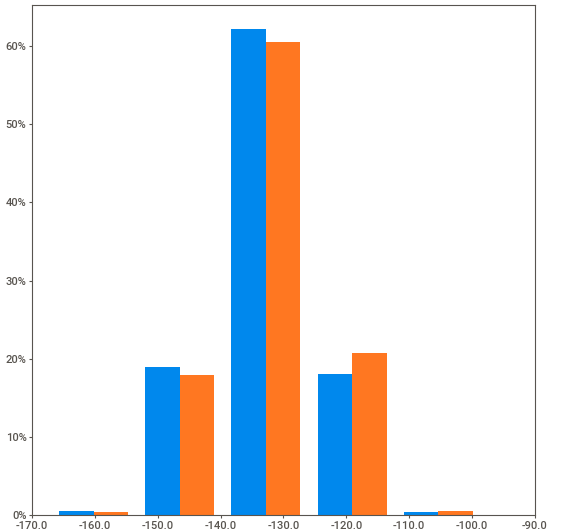
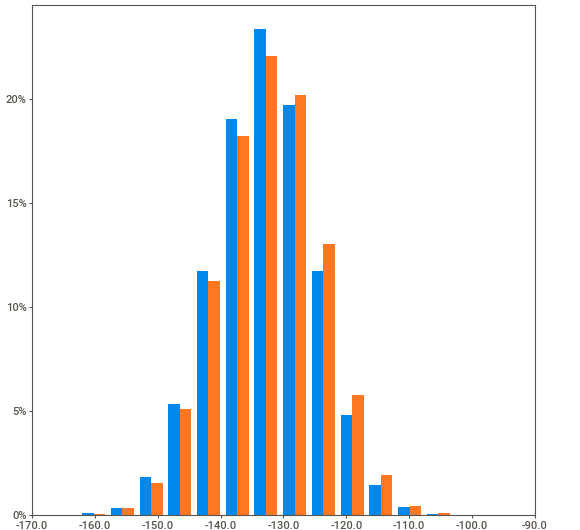
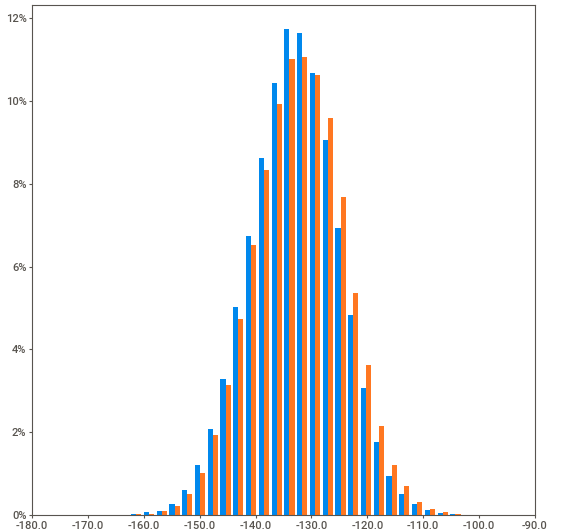
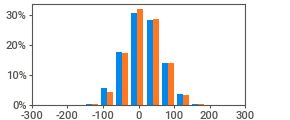
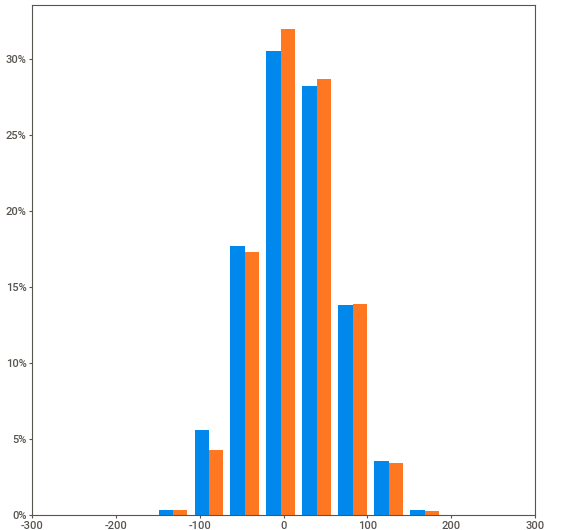
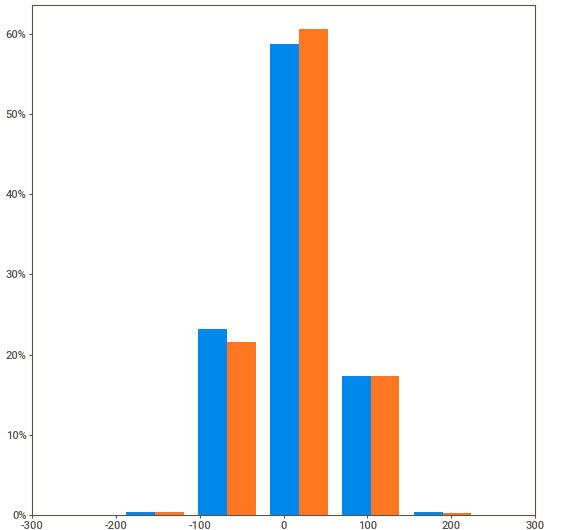
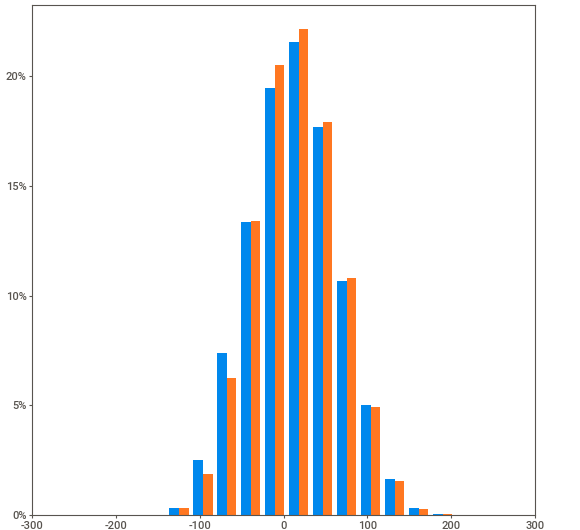
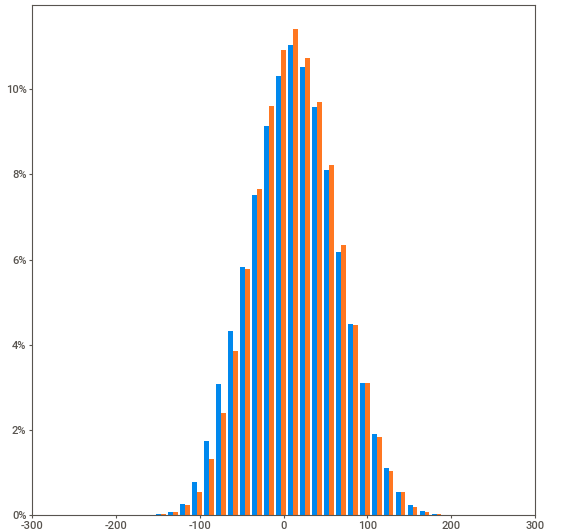
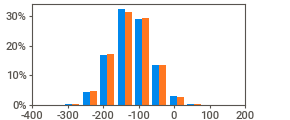
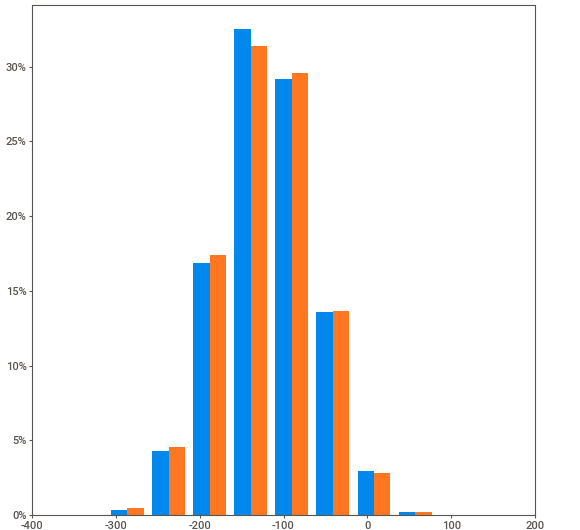
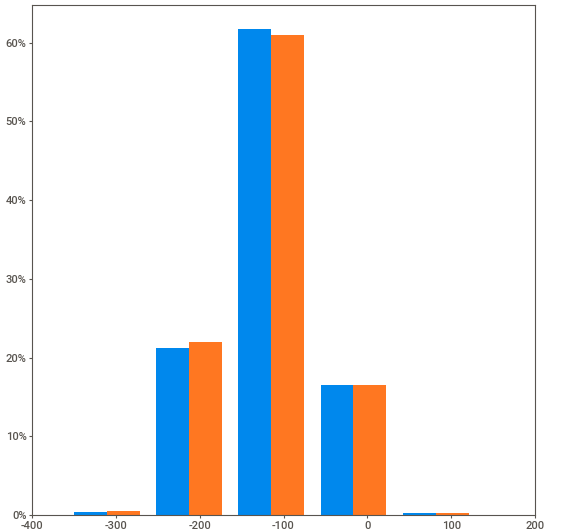
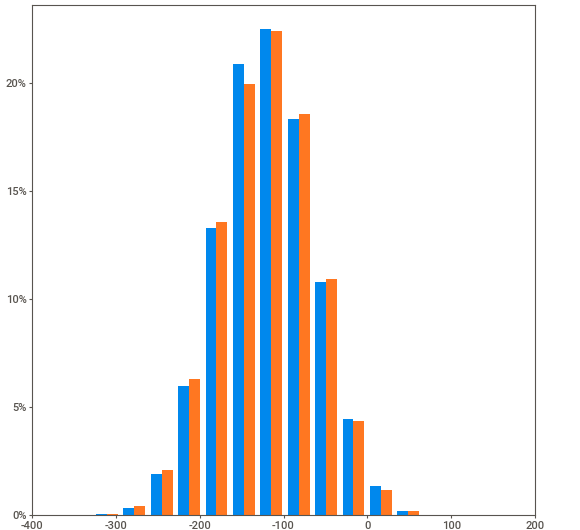
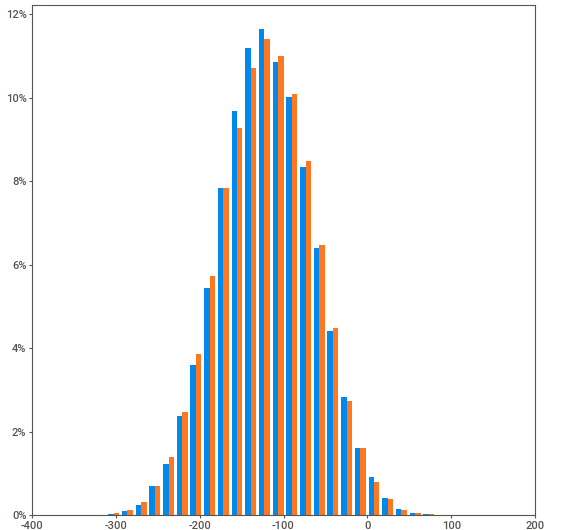
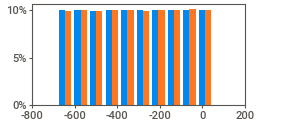
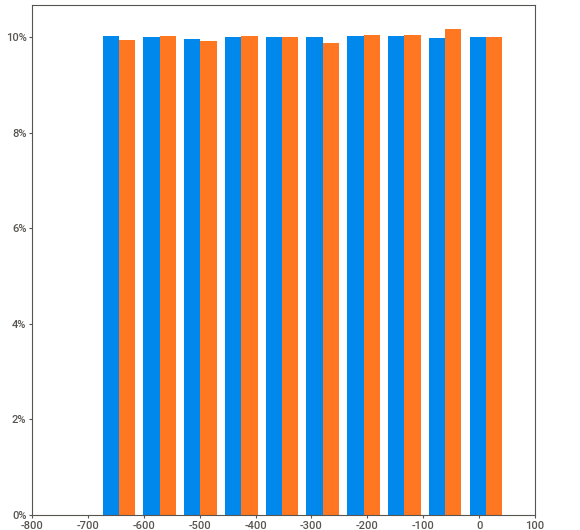
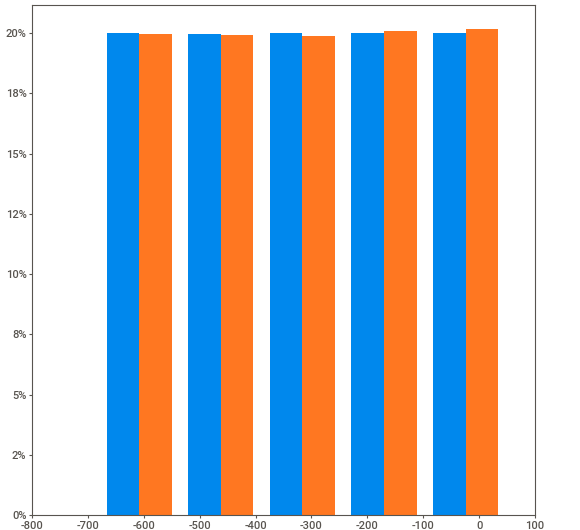
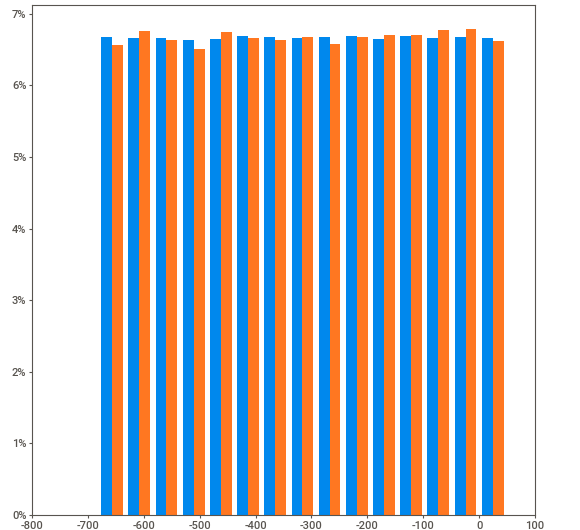
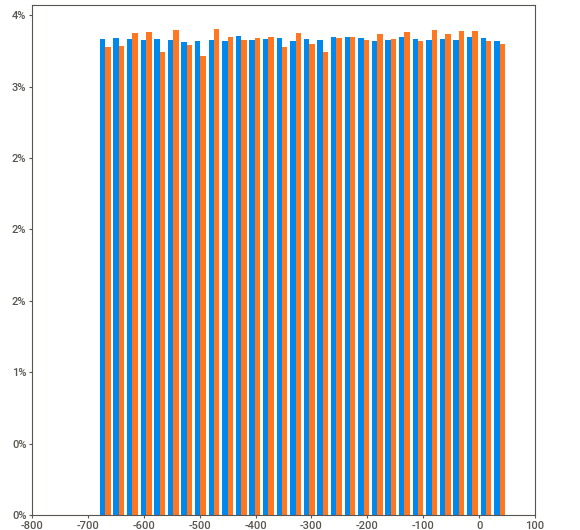
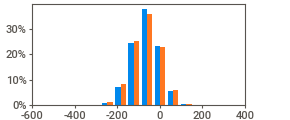
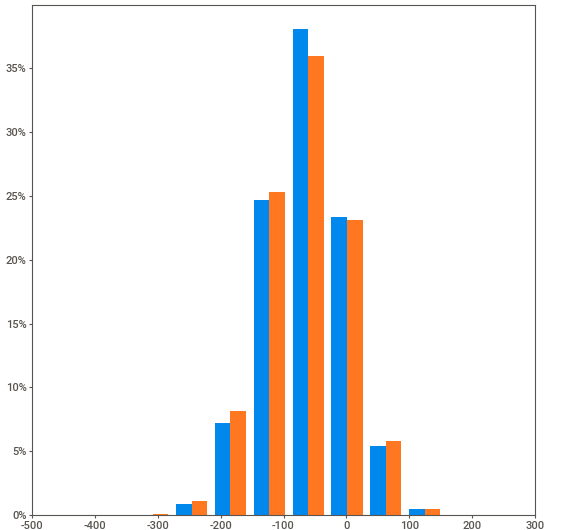
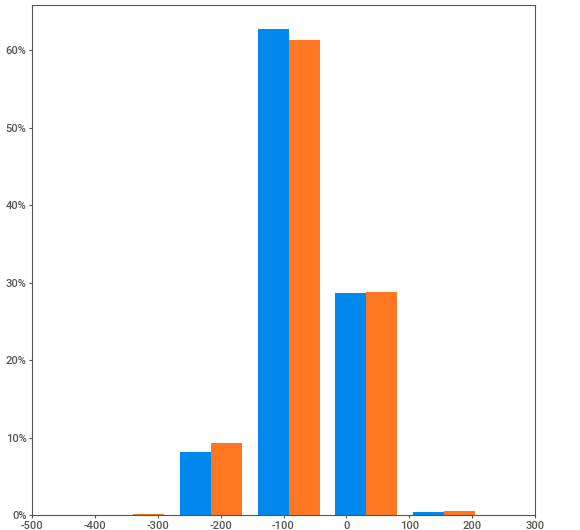
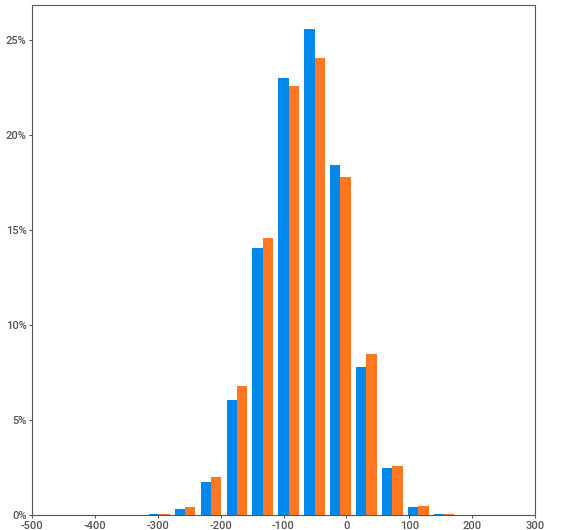
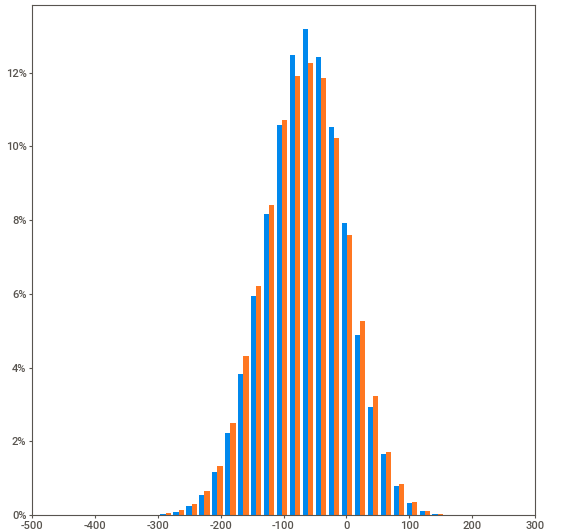
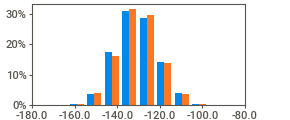
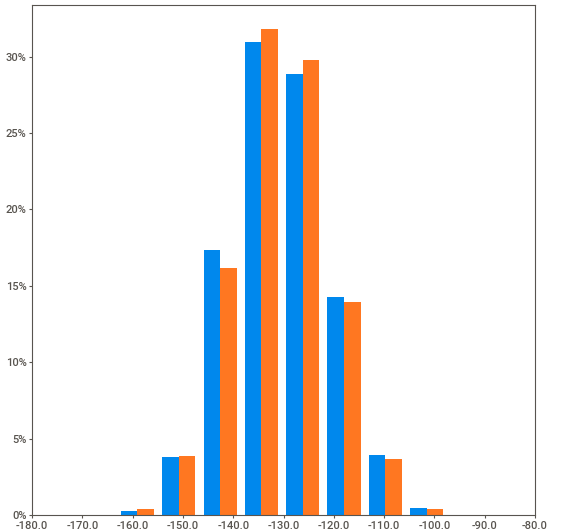
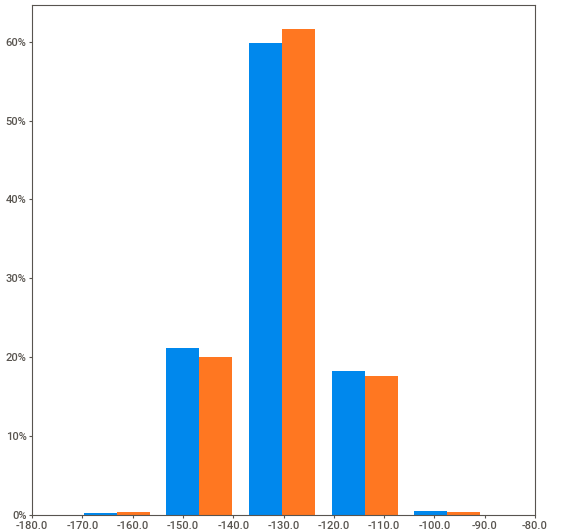
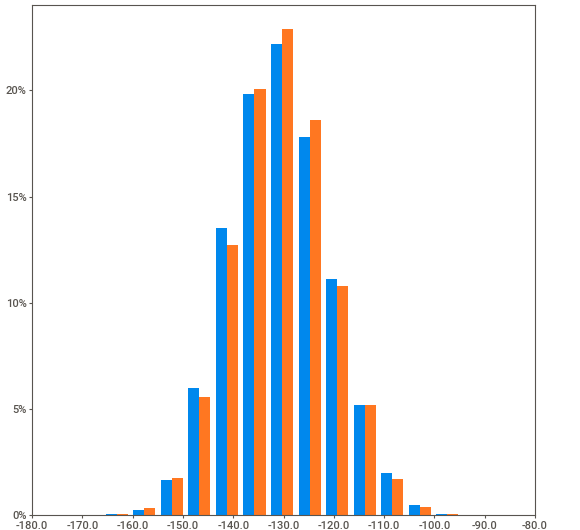
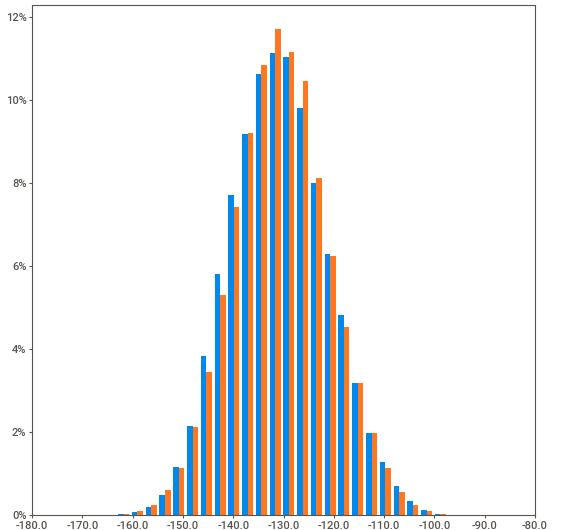
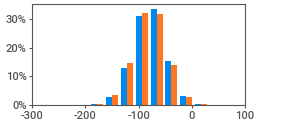
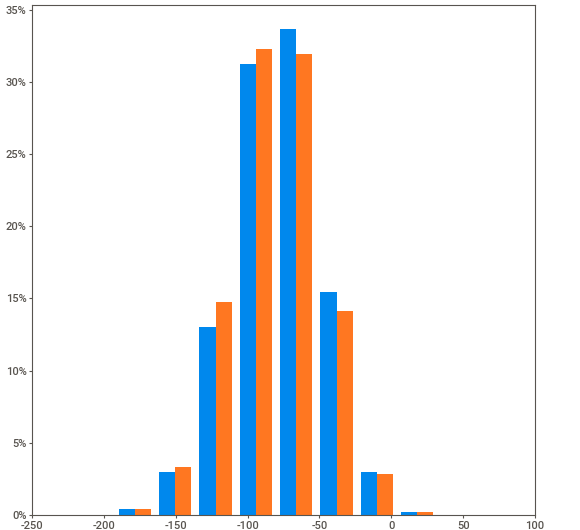
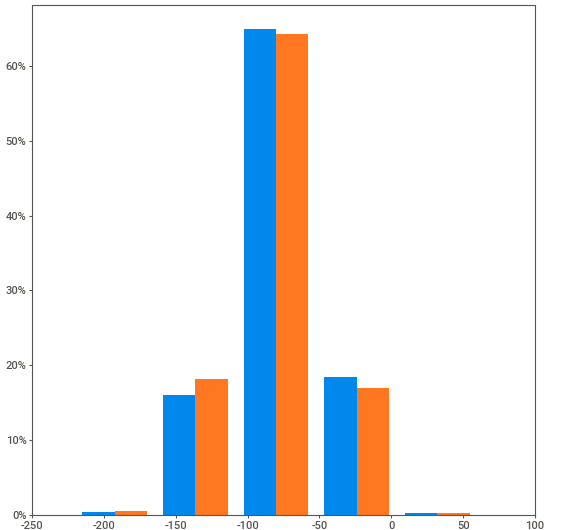
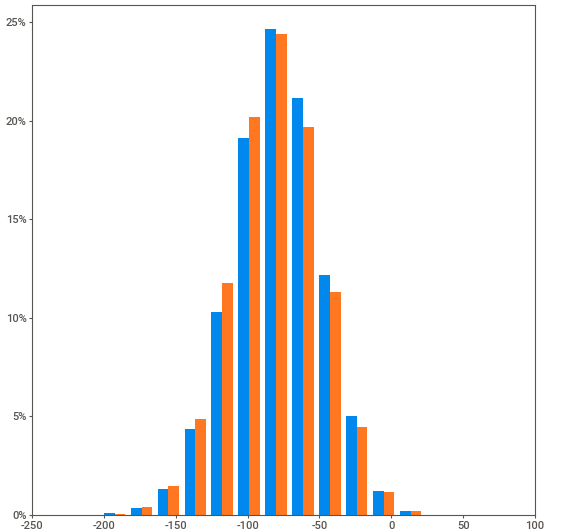
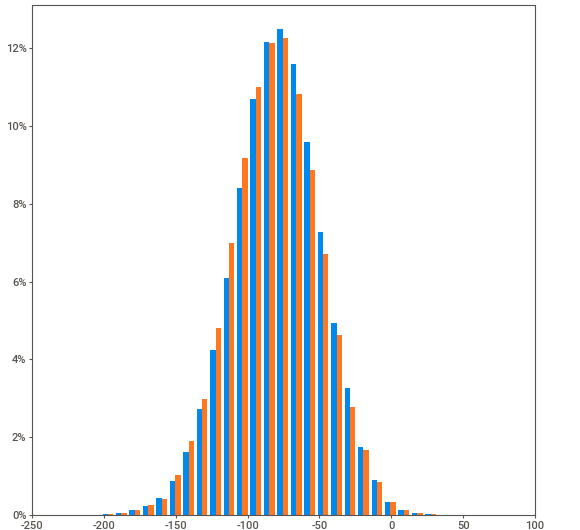
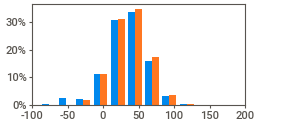
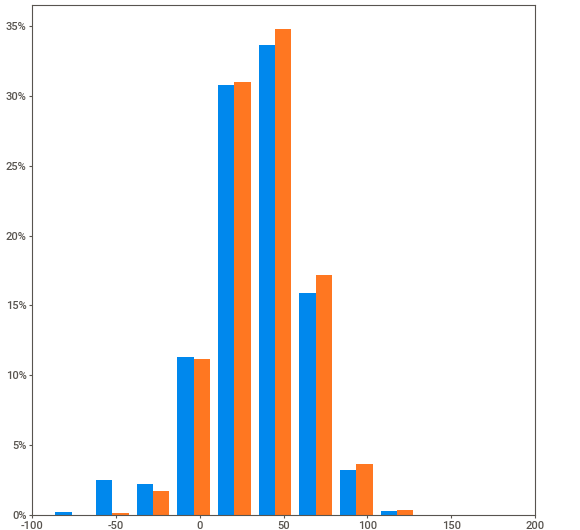
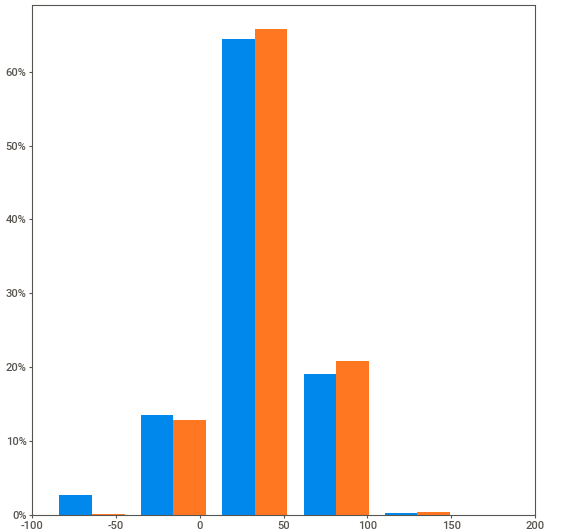
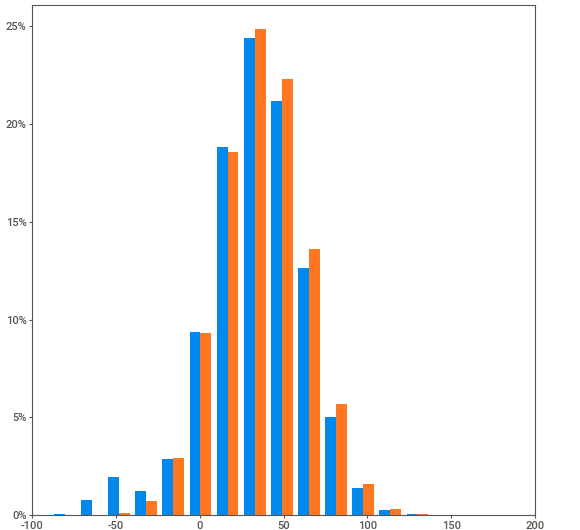
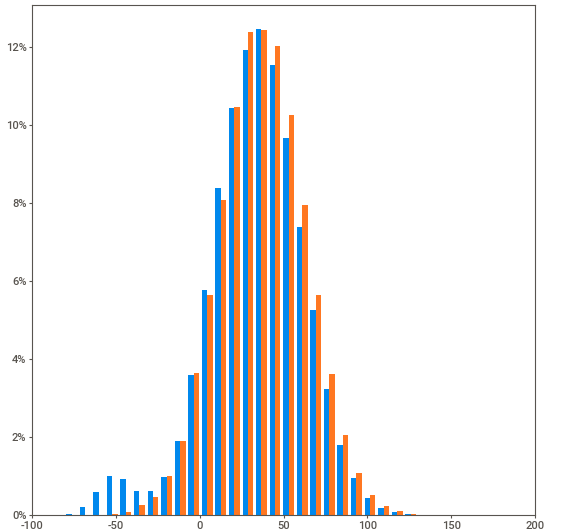
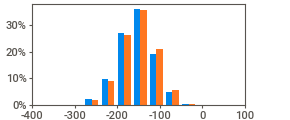
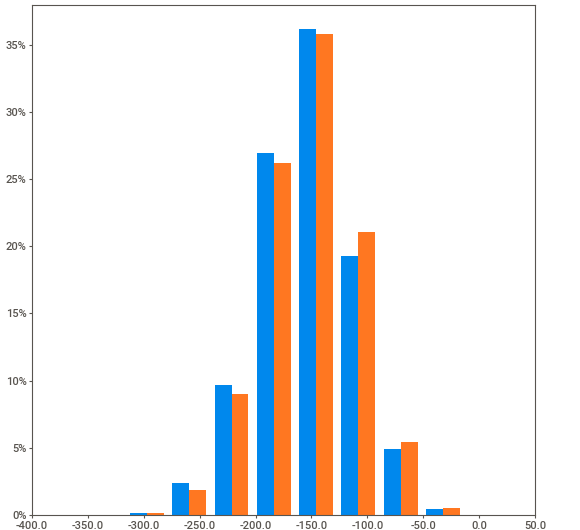
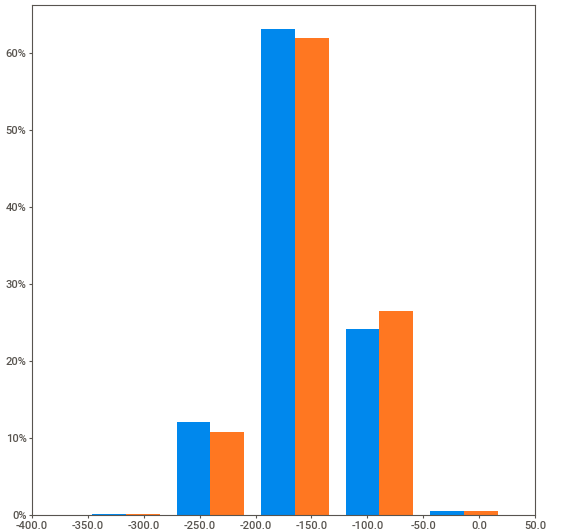
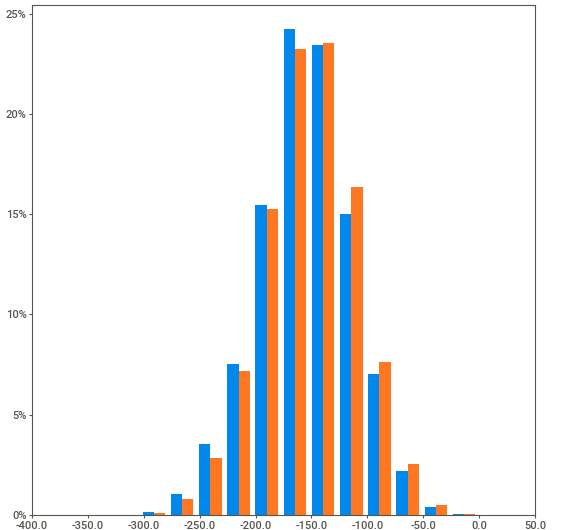
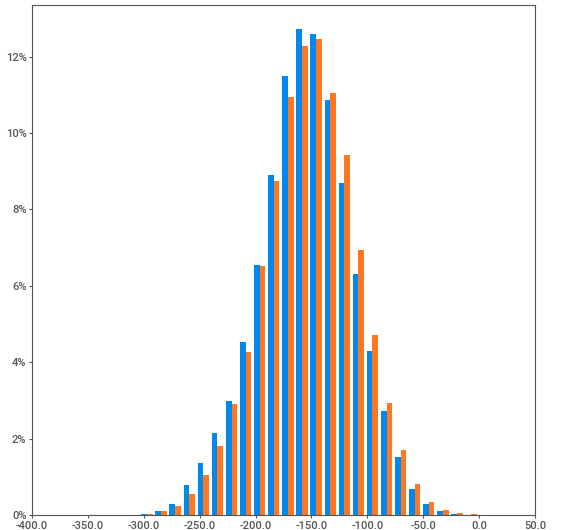
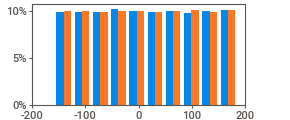
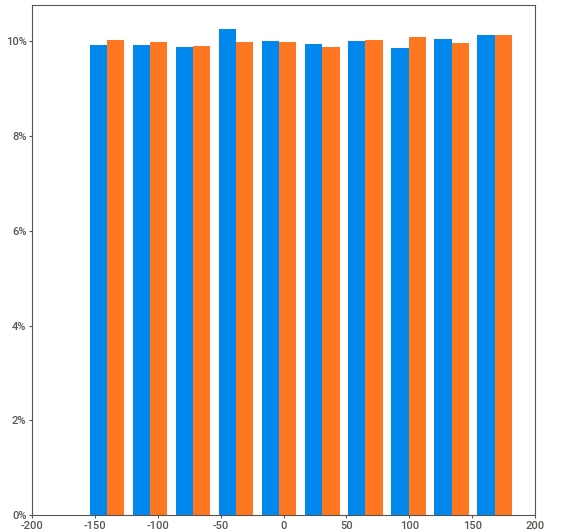
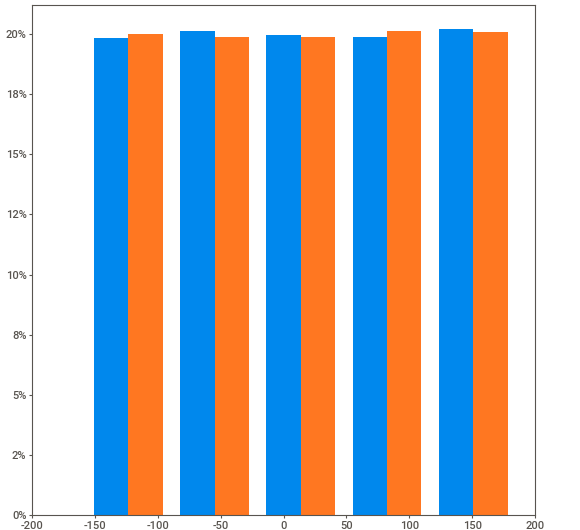
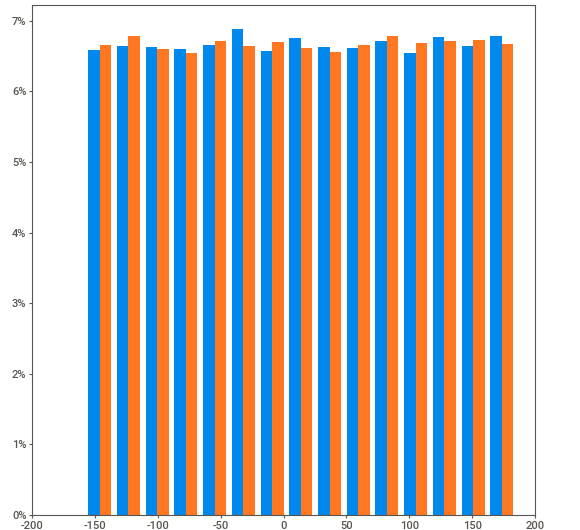
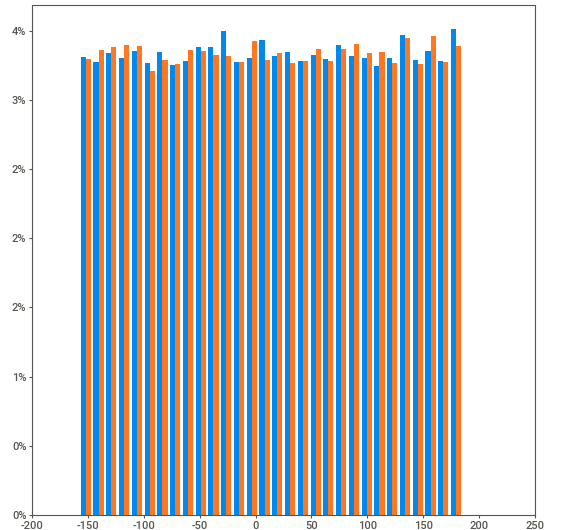
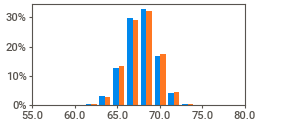
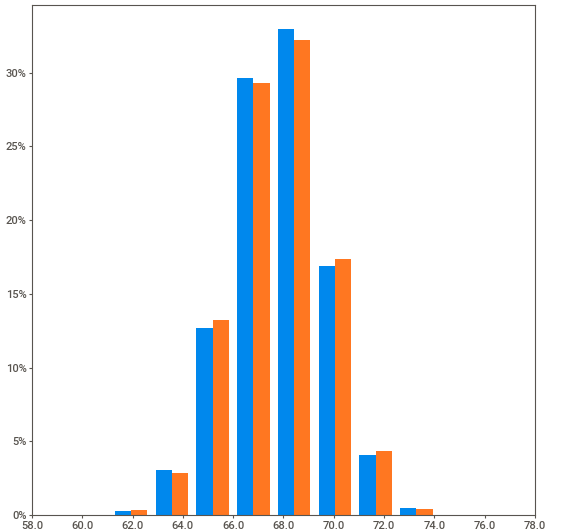
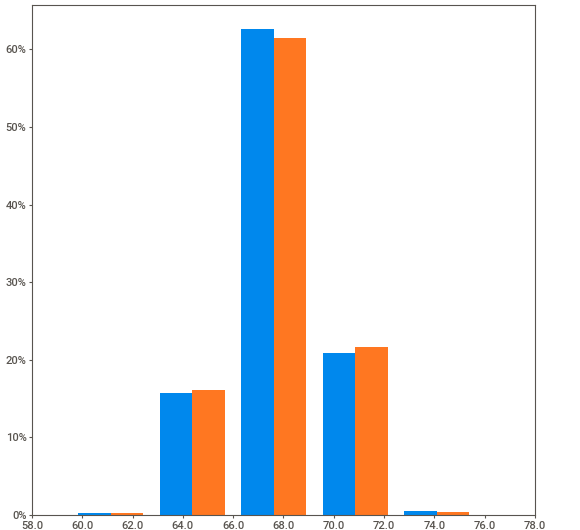
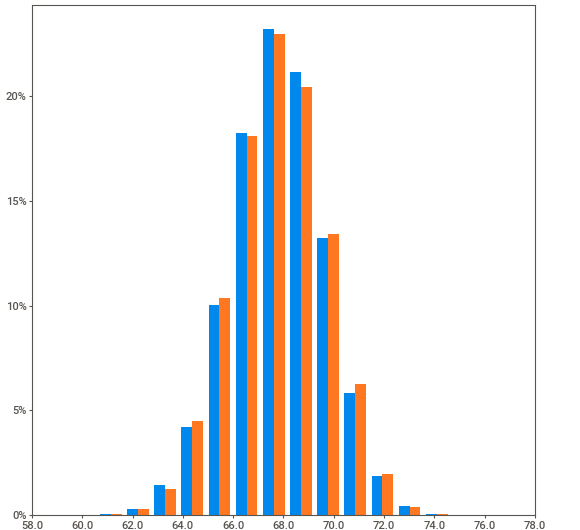
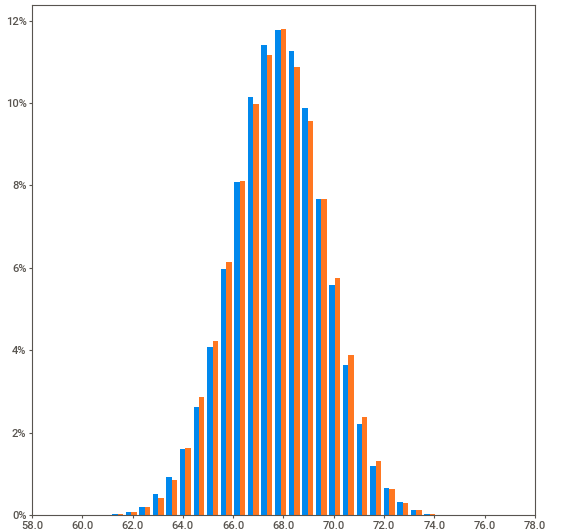
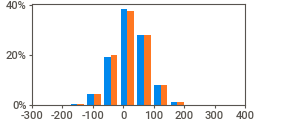
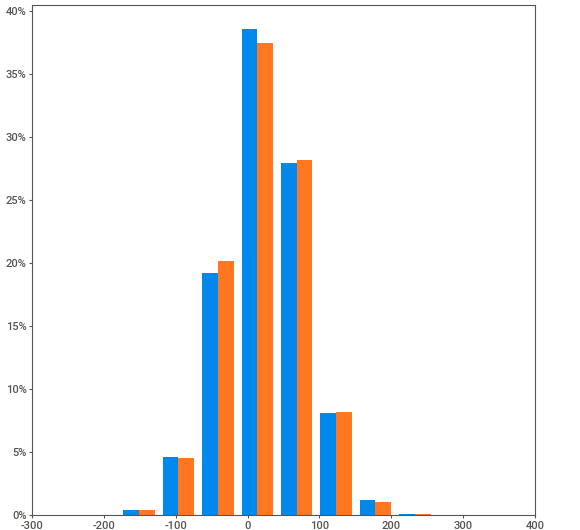
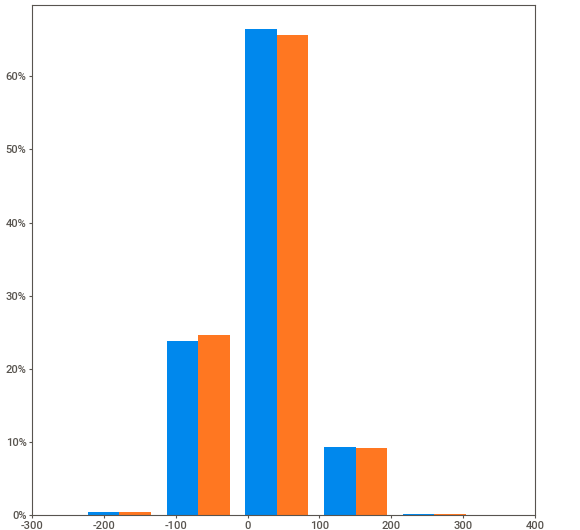
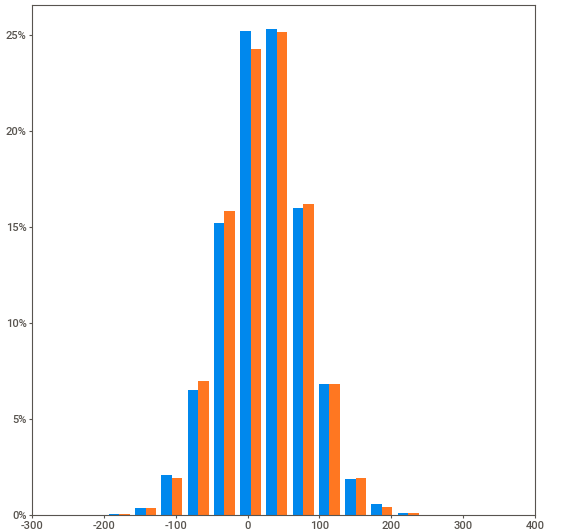
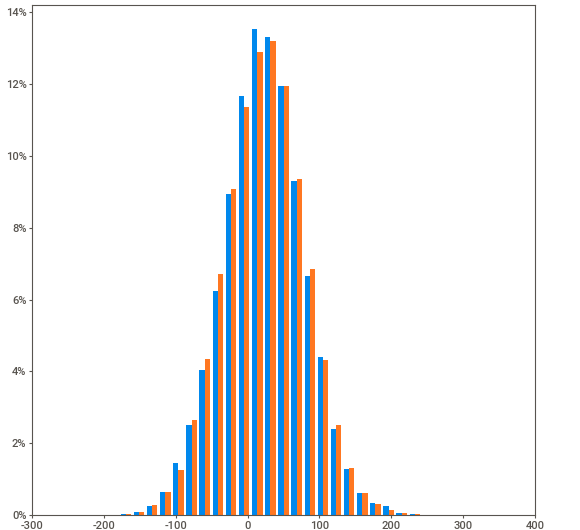
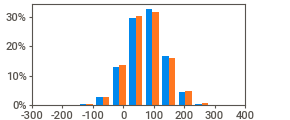
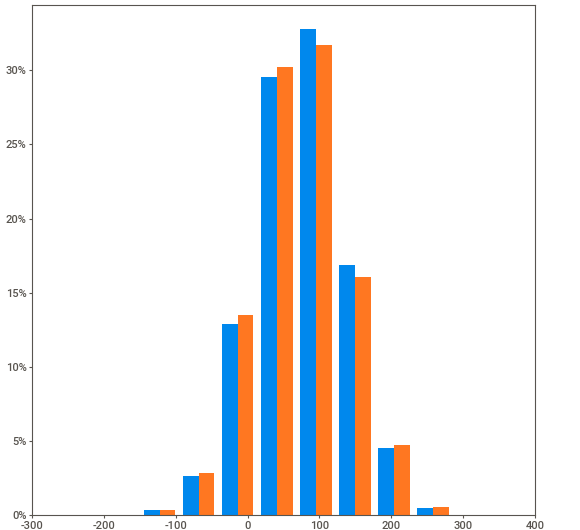
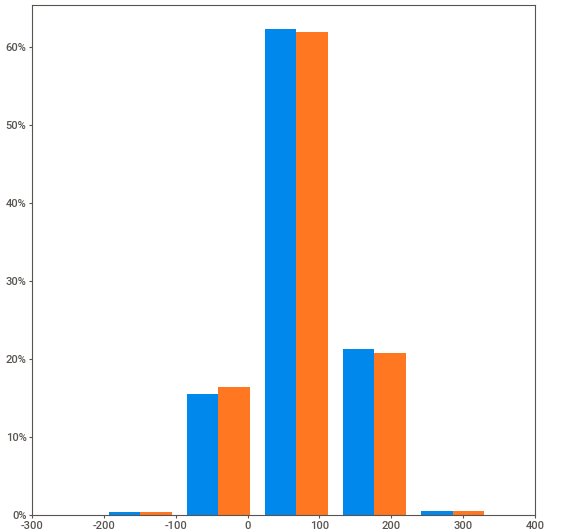
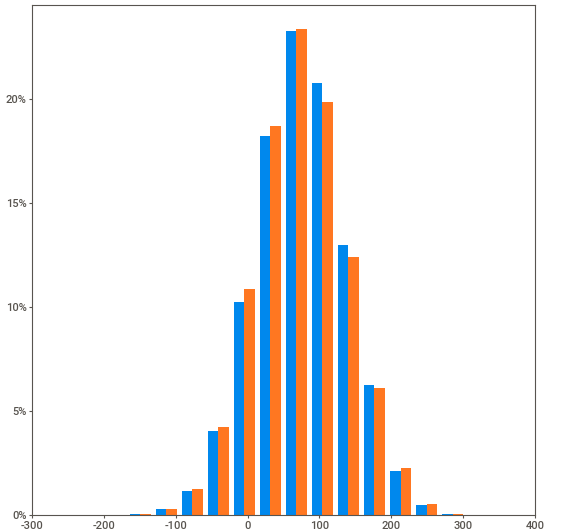
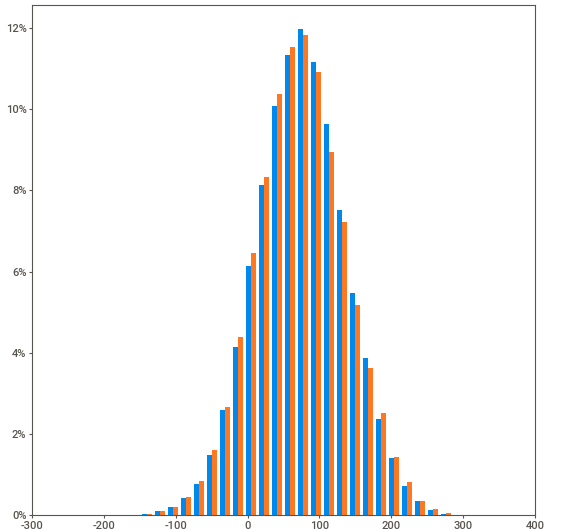
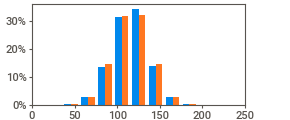
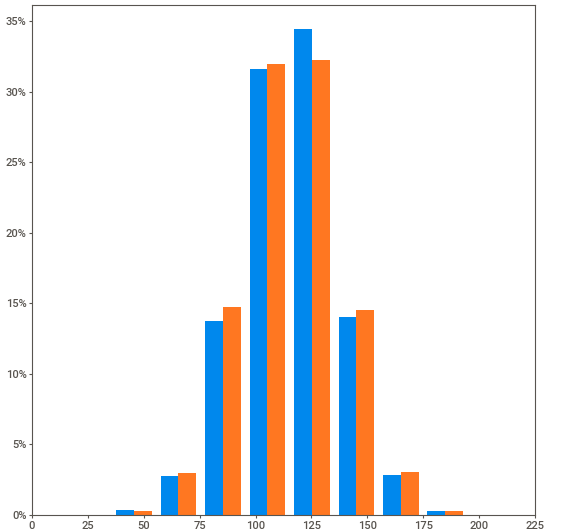
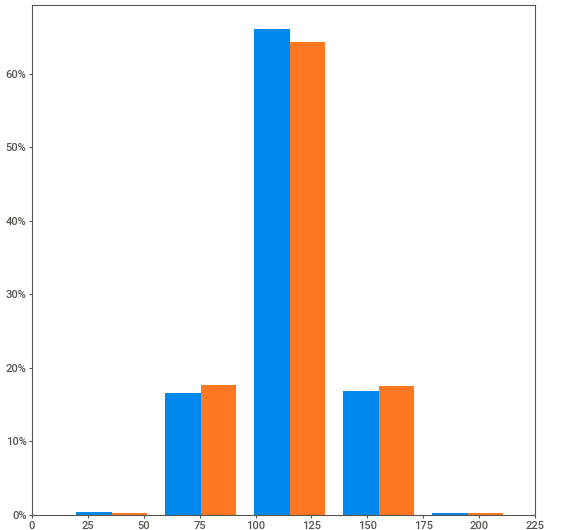
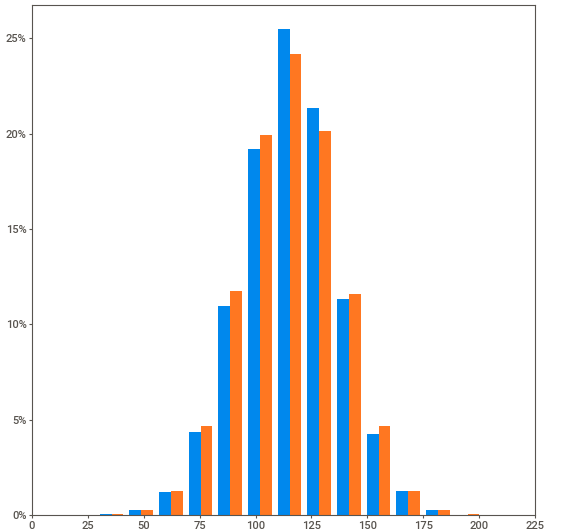
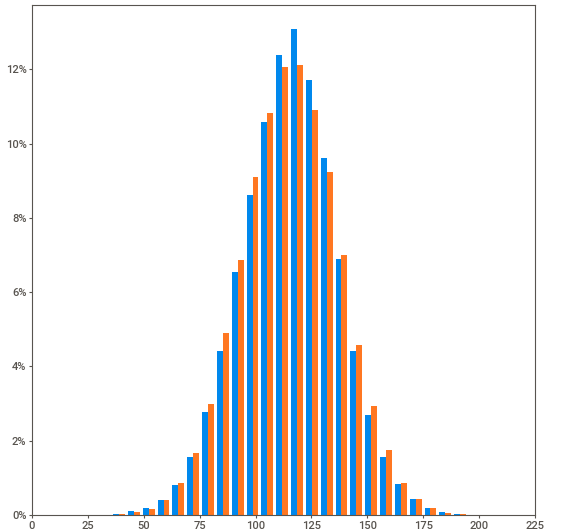
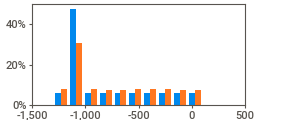
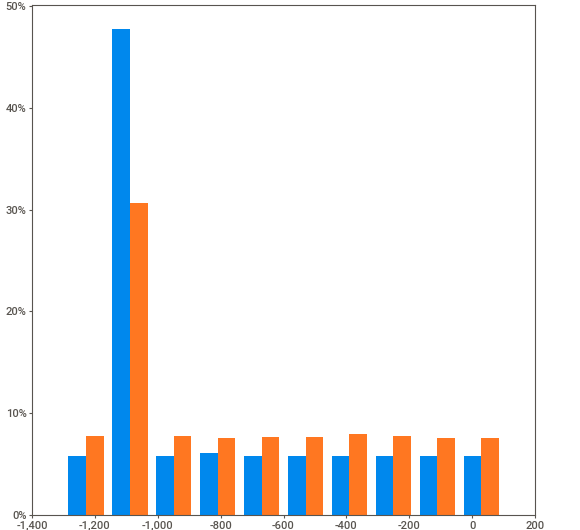
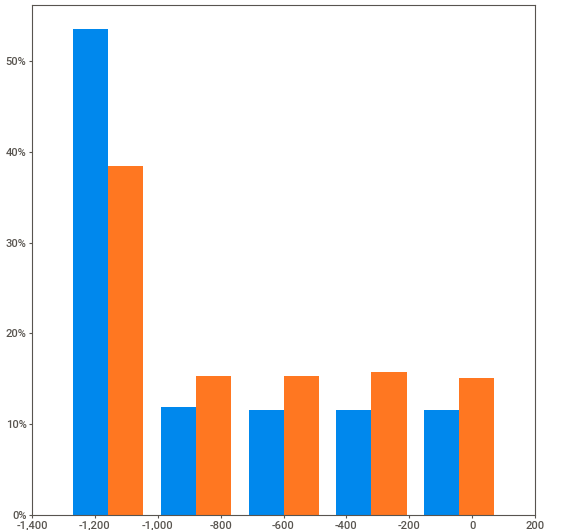
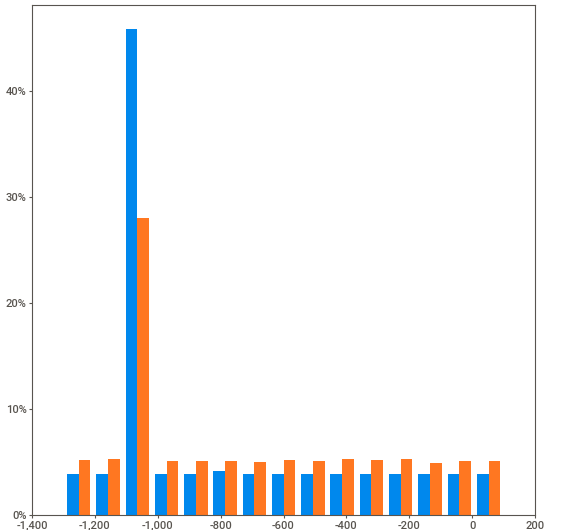
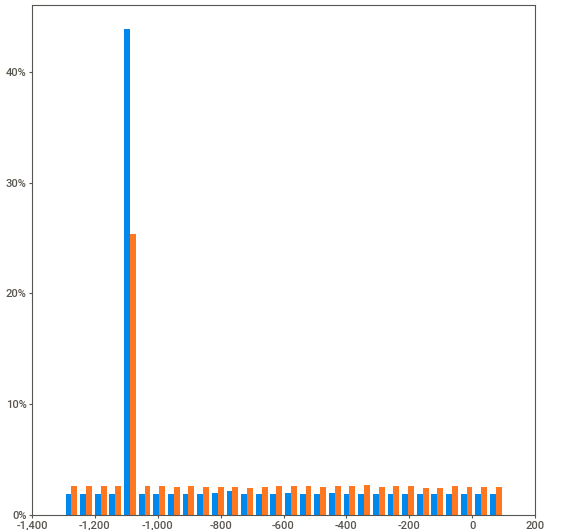
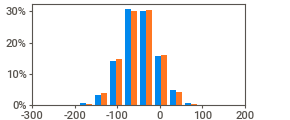
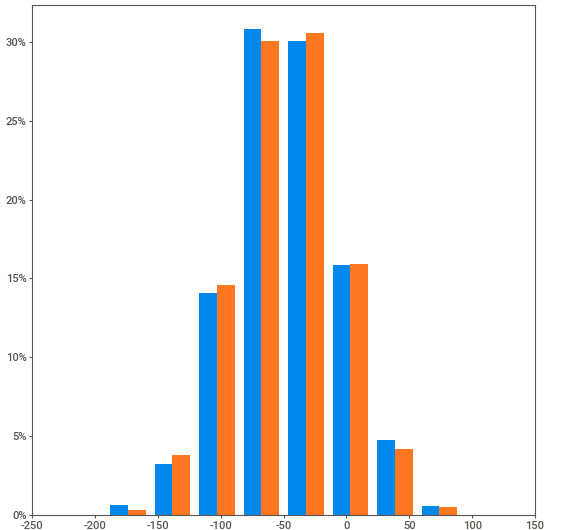
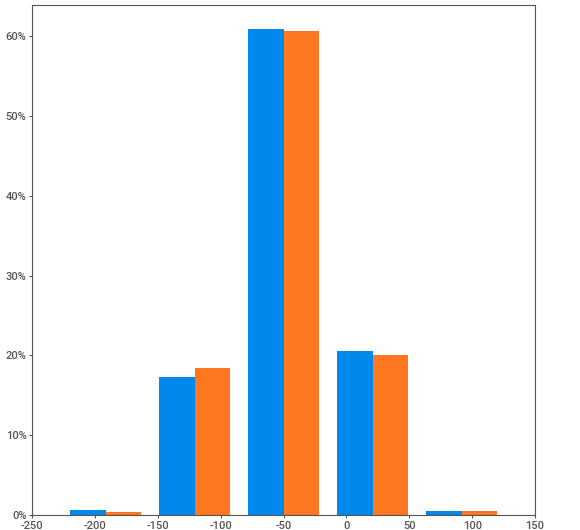
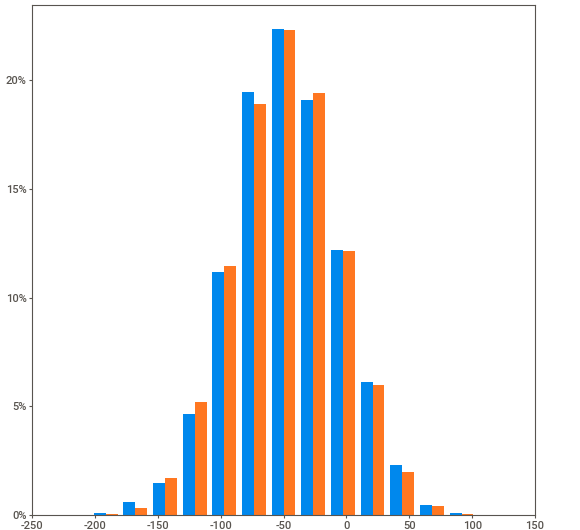
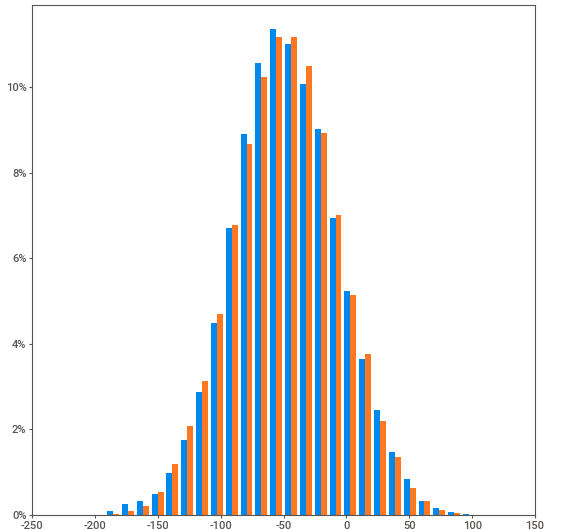
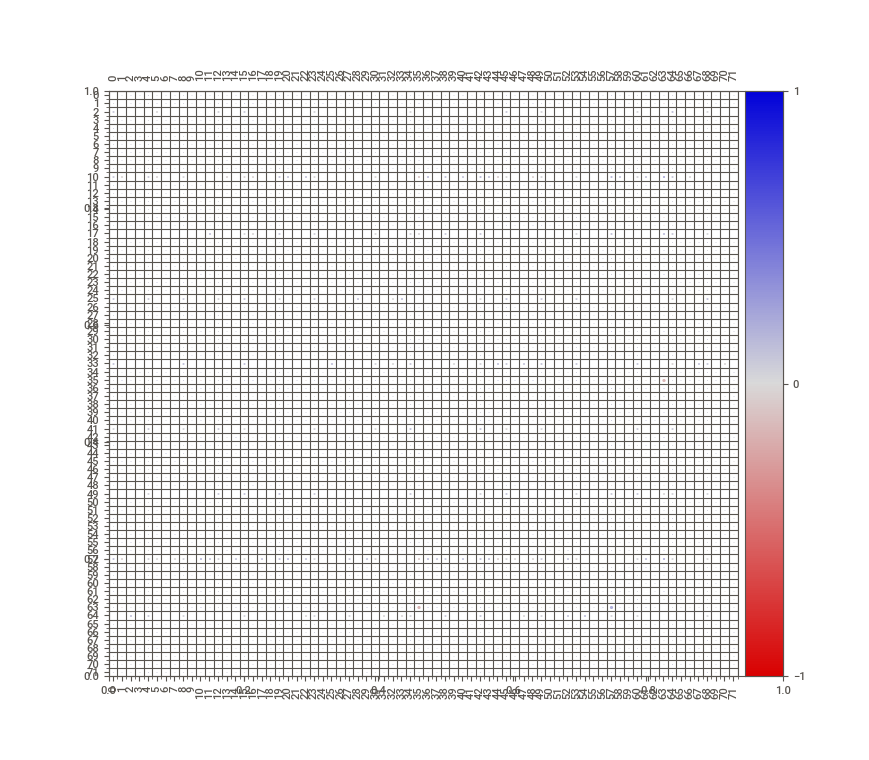
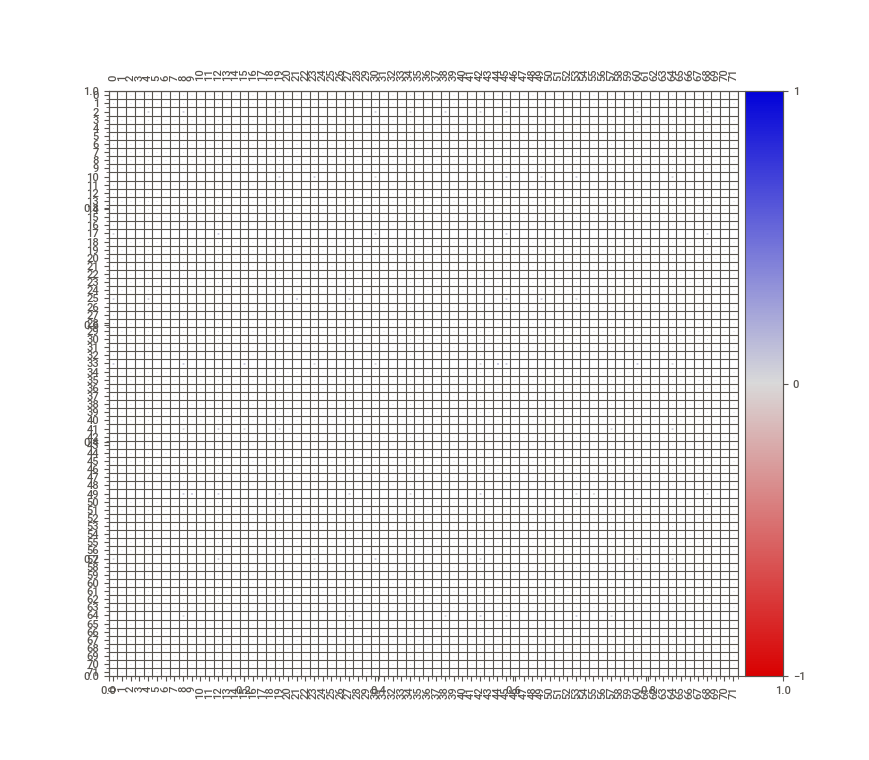

In [9]:
my_report.show_notebook(scale=0.9)

## BaseLine

Проведем стандартизацию числовых данных с помощью  StandardScaler

In [10]:
scaler = StandardScaler()

base_feature = base.iloc[:,1:]
scaler.fit(base_feature)
scaled_features = scaler.transform(base_feature)
base.iloc[:,1:] = scaled_features
base.sample(5)

Id         0         1         2         3         4  \
1949394  2751928-base  0.344131 -0.964144 -0.034346  0.366050  1.015987   
2334593  3491388-base -1.953379 -0.861535  0.847296  0.712731  0.341318   
2376026  3575129-base  0.341101  1.262265 -0.106674 -0.373768 -0.064068   
983078   1187987-base  2.084292 -1.028652 -1.224421  0.138817 -0.642494   
1326879  1698043-base  0.468123 -0.964381 -0.899628 -1.787548  0.344131   

                5         6         7         8  ...        62        63  \
1949394  0.882135  0.246510 -1.119943 -0.006568  ...  1.737254  0.786187   
2334593  0.699207  1.131603  0.058675  0.300616  ...  1.014601 -1.909475   
2376026  0.568819  1.736980  0.859230  0.308831  ... -0.049698 -2.912230   
983078   0.817824 -0.404948  1.021004 -0.635513  ... -0.615612  0.306604   
1326879  1.879773 -0.697723 -0.989692  1.248513  ...  0.815044  1.462177   

               64        65        66        67        68        69        70  \
1949394  1.243502  0.918928  0.259604  0.538905 -0.935520  0.344809 -0.626731   
2334593  1.026763  1.038496  1.032969  0.877732 -1.533576 -0.188181  2.119492   
2376026  0.372757 -1.404565  0.422320 -0.736680  0.582607  0.143498 -1.063126   
983078  -0.897817 -0.640832  2.099443 -0.306628 -0.996155 -0.679888 -0.713847   
1326879 -0.895267 -1.224958  1.043516 -0.380960  0.324169  0.169428 -0.713847   

               71  
1949394  0.353271  
2334593 -0.036165  
2376026 -0.188506  
983078  -0.589080  
1326879 -0.177496  

[5 rows x 73 columns]

In [11]:
train_features = train.iloc[:,1:-1]
scaled_features = scaler.transform(train_features)
train.iloc[:,1:-1] = scaled_features
train.sample(5)

Id         0         1         2         3         4  \
57212  57212-query  1.106304  0.729884  1.492726  1.452963 -1.405192   
28164  28164-query -1.803352  0.485514 -0.364846  1.495669  0.011040   
71680  71680-query  1.338850 -0.547117  0.563407  0.418514 -1.104330   
15381  15381-query -1.139846 -2.017699  0.166246 -0.446208  1.552570   
95254  95254-query  0.939547  1.432655 -0.079437  0.392212  0.004084   

              5         6         7         8  ...        63        64  \
57212  0.565636 -1.352459  0.851566 -0.321220  ...  1.337487  1.200312   
28164  1.978092  0.313006  0.805639 -0.013591  ...  0.684636  0.160727   
71680 -0.696670 -0.374175 -0.282795 -0.337592  ...  0.163528  0.658987   
15381 -0.769159  1.361020  2.860772 -0.387006  ...  0.156098  0.098097   
95254 -0.939562 -0.021258  0.623719 -0.121114  ... -0.133914 -0.936248   

             65        66        67        68        69        70        71  \
57212  0.059000  0.700094  0.618706 -0.148714 -0.983383  1.833997  1.861691   
28164 -0.650070 -0.854649 -1.589469 -0.853748 -3.234559  0.225184 -0.454293   
71680  1.380086  0.566299  0.577312  1.052410 -0.712608  0.275288 -0.901175   
15381  1.096634 -0.178997 -0.754409  0.812453  0.511499  1.834780  0.272212   
95254  0.215341  0.852549 -0.731250  0.504301  0.133521  2.023135 -1.574342   

             Target  
57212   294301-base  
28164   145245-base  
71680   402101-base  
15381  2706918-base  
95254  2213076-base  

[5 rows x 74 columns]

In [12]:
base = base.set_index('Id')
train = train.set_index('Id')

Разделим base на 100 кластеров с помощью kmeans

In [13]:
kmeans = KMeans(n_clusters=100, random_state=RANDOM_STATE) 

%time kmeans.fit(base)

CPU times: total: 4min 52s
Wall time: 1min 14s


KMeans(n_clusters=100, random_state=42)

Посмотрим как распределились данные в кластерах

In [14]:
d = Counter(kmeans.labels_.tolist())
sorted(d.items(), key=lambda kv: - kv[1])

[(10, 105606),
 (14, 86848),
 (53, 86672),
 (90, 59245),
 (77, 51904),
 (96, 51694),
 (92, 51041),
 (31, 50974),
 (69, 50886),
 (17, 48952),
 (51, 46571),
 (8, 46310),
 (20, 45879),
 (13, 45607),
 (82, 45176),
 (34, 43525),
 (29, 43105),
 (26, 42477),
 (75, 41239),
 (55, 39943),
 (57, 39299),
 (67, 39005),
 (28, 38174),
 (47, 37188),
 (32, 37037),
 (35, 36610),
 (39, 35766),
 (76, 35486),
 (62, 35139),
 (3, 34930),
 (85, 34557),
 (79, 34326),
 (50, 33677),
 (27, 33380),
 (94, 33290),
 (84, 32268),
 (91, 32162),
 (45, 31780),
 (0, 31707),
 (22, 31616),
 (99, 31465),
 (2, 31010),
 (24, 30865),
 (5, 30680),
 (58, 30440),
 (71, 30252),
 (49, 29649),
 (4, 29471),
 (6, 29206),
 (37, 28435),
 (1, 28187),
 (56, 27687),
 (52, 27332),
 (65, 26686),
 (25, 26663),
 (46, 26653),
 (64, 25716),
 (89, 24926),
 (72, 24622),
 (95, 24516),
 (83, 24476),
 (80, 24046),
 (70, 22952),
 (16, 22459),
 (19, 22157),
 (60, 21842),
 (54, 20959),
 (97, 19264),
 (36, 19263),
 (44, 18954),
 (74, 18389),
 (78, 17914),

In [15]:
kmeans.labels_

array([57, 25, 53, ..., 10, 99, 32])

In [16]:
base['claster'] = kmeans.labels_
base

0         1         2         3         4         5  \
Id                                                                         
0-base       -1.159216  0.620350 -0.513723  1.398558  2.269043 -1.160385   
1-base        2.075715  1.060423 -0.652491 -1.002705 -1.157244 -0.500495   
2-base        1.285417 -0.343342  0.397878  0.666228  0.853956 -0.973671   
3-base       -0.051852 -0.816047 -1.118829 -1.936660 -0.754014  0.461441   
4-base        0.541780 -0.314538  2.284450  0.303705 -2.276181 -1.422075   
...                ...       ...       ...       ...       ...       ...   
4744755-base -1.561060 -0.675221  2.145022  1.076266  2.124613  0.855791   
4744759-base -0.898663 -0.530123  0.579546 -0.608808  0.049398 -0.597886   
4744762-base -0.433776 -2.064035 -0.690969  0.098481  0.823080  1.788798   
4744763-base -0.024465  0.167939  0.252204  2.024324 -1.490462 -0.858682   
4744766-base -0.632180  0.964880 -0.176341 -1.087603 -0.221185  0.002724   

                     6         7         8         9  ...        63        64  \
Id                                                    ...                       
0-base       -0.282884  0.373663 -0.435627  0.884544  ...  0.190524  0.073589   
1-base        1.130652 -0.871900 -0.623903  1.098487  ...  0.270119 -0.073569   
2-base        1.637293  0.654489  0.828686  0.619635  ...  0.440159 -1.269686   
3-base        0.033281 -0.840347 -0.259958  0.182763  ... -1.372853  0.184217   
4-base       -0.020200  0.386656 -0.238677 -0.191508  ...  0.808178 -0.110496   
...                ...       ...       ...       ...  ...       ...       ...   
4744755-base -0.868394 -1.423783  0.291078 -1.476259  ...  0.766146 -0.891135   
4744759-base  1.012274  1.821418  0.845243  0.625420  ... -0.514378  1.555805   
4744762-base -1.352459 -2.001122  0.177137 -0.088426  ...  1.025621 -0.347378   
4744763-base -0.517876 -0.163629  0.370246 -1.012485  ... -1.393629 -0.467622   
4744766-base  1.571693 -0.400945  1.862701  0.014029  ...  1.373193  0.168266   

                    65        66        67        68        69        70  \
Id                                                                         
0-base       -0.894789 -2.262493 -0.510438  0.293004 -0.014051  1.781420   
1-base       -1.097493  0.225102  0.014491  1.711283  0.059848  1.853726   
2-base        1.143739 -1.220546  0.773022  0.099669  0.048521 -0.713847   
3-base       -0.523936 -0.871349 -0.797073  1.014714  0.090076 -0.713847   
4-base        0.725544 -0.562342 -0.470720 -0.157210  0.920175 -0.713847   
...                ...       ...       ...       ...       ...       ...   
4744755-base  1.099805 -1.248473  1.543466 -2.082561  0.079706  0.475699   
4744759-base -0.431911  0.493593 -0.395871 -1.619490 -1.040661 -0.713847   
4744762-base  0.953011  0.439465  0.355254 -0.096658  0.659732 -0.713847   
4744763-base -1.669100  0.455521 -0.412650  0.317753  0.438073 -0.713847   
4744766-base -0.194364  1.040417 -0.790193  0.155185 -1.073565 -0.712190   

                    71  claster  
Id                               
0-base       -0.312329       57  
1-base       -0.281052       25  
2-base        0.365623       53  
3-base       -0.601807       92  
4-base        1.152406       10  
...                ...      ...  
4744755-base -0.718053       12  
4744759-base -1.030208       85  
4744762-base  1.257774       10  
4744763-base -0.191579       99  
4744766-base  1.498658       32  

[2918139 rows x 73 columns]

In [17]:
pd.DataFrame(kmeans.cluster_centers_)

0         1         2         3         4         5         6   \
0   0.469055  0.262119 -0.155132 -0.858416  0.013616  0.348010 -0.133598   
1  -0.253332  0.034129 -0.740289  0.725657  0.206780  0.033576 -0.110096   
2  -0.268931 -0.078784 -1.137878  0.309528  0.590959 -0.003395  0.020442   
3   0.077183  0.762470  0.716574  1.380698  0.416358  0.878781 -0.037487   
4  -0.115020 -0.207097  0.520230 -0.552315 -0.528149 -0.892358  0.039181   
..       ...       ...       ...       ...       ...       ...       ...   
95 -0.345781 -0.954545  0.350857 -1.241877  0.316510  0.281038  0.023959   
96 -0.192437 -0.234155 -0.041095  0.053685 -0.219712  0.059153 -0.118675   
97  0.542305  0.491841  0.015888  0.486264 -0.750524  0.771531  0.043977   
98  0.601360 -1.462780  1.525405 -0.200627 -0.540525 -0.485937  0.128754   
99  0.085925 -0.312020  0.120128  0.421090  0.216594 -0.238018  0.090146   

          7         8         9   ...        62        63        64        65  \
0   0.378574 -0.564479  0.085991  ...  0.234006 -0.213092 -0.000957  0.058088   
1  -0.050397  0.349409  1.025952  ...  0.395713  0.406250 -0.419352 -0.033926   
2  -0.308573  0.038472 -0.295180  ...  0.483859  0.356983 -0.464313  0.013780   
3  -0.223401  0.376102  0.188616  ... -0.148385 -0.218692  0.171816 -0.015778   
4  -0.159425 -0.624113 -0.358015  ...  0.264161 -0.169265  0.158196 -0.041532   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95  0.235112  0.263559  0.382390  ... -0.221228 -0.710364  1.309867 -0.005039   
96  0.450858 -0.776371 -0.118320  ... -0.072190  0.133201  0.132855  0.024299   
97  0.635105 -0.258956 -0.502210  ... -0.894268 -0.188375  0.071106  0.000011   
98  0.229010 -0.844238  1.454544  ...  0.755841  0.949137 -0.565909  0.001655   
99  0.015263 -0.295534 -1.089440  ...  0.587829 -0.090398 -0.474961 -0.029519   

          66        67        68        69        70        71  
0   0.841060 -0.286965  0.178715  0.416006  0.214017  0.422028  
1  -0.184405  0.189944  0.216220 -0.259384  0.126415  0.339040  
2   0.724763 -0.493004  0.416635 -0.684805  0.057628  0.099164  
3   0.020707  0.161160  0.745907  0.175996  0.037561 -0.259447  
4   0.356046  0.750654  0.738855 -0.579902 -0.202594  0.928782  
..       ...       ...       ...       ...       ...       ...  
95 -1.073648 -0.662052  0.409824  0.020989  0.010779 -0.129854  
96  0.457415 -0.417776 -0.514391 -0.148230  0.356276 -0.522766  
97 -0.482462 -0.157366 -0.509834 -0.846159 -0.025332 -0.612044  
98 -1.007715  1.135451  1.527951 -0.376069 -0.177385 -0.682867  
99 -0.548176 -0.229039  0.005091  0.473147 -0.289014 -0.307738  

[100 rows x 72 columns]

Найдем для каждой записи train ближайший кластер

In [18]:
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(kmeans.cluster_centers_)

NearestNeighbors(n_neighbors=2)

In [19]:
neigh_claster = neigh.kneighbors(train.iloc[:,:-1].values, 1, return_distance=False)

In [20]:
neigh_claster

array([[90],
       [51],
       [70],
       ...,
       [80],
       [19],
       [25]], dtype=int64)

In [21]:
train['predict_claster'] = neigh_claster

In [22]:
train

0         1         2         3         4         5  \
Id                                                                        
0-query      1.299519  1.996888  0.063774 -1.879671  1.644100 -0.537626   
1-query     -0.062146 -0.257159  0.324249 -1.543245  0.204684 -0.419328   
2-query      1.456328 -0.855696 -1.851792 -1.701553  1.700433  0.750504   
3-query      1.543467  0.203199 -1.833235  1.291201 -0.359536 -1.322073   
4-query      0.265046  1.284537 -0.370748 -0.021041 -1.169187  1.977993   
...               ...       ...       ...       ...       ...       ...   
99995-query  0.725110  0.722221 -0.481442 -2.121036  0.427126  0.243597   
99996-query  0.790982 -1.186858 -0.665550  0.023540 -0.722780  0.868008   
99997-query  1.296887 -0.676949  0.396096 -0.027606  3.296232 -1.033995   
99998-query  0.357864  0.411899 -0.502547  1.552935  0.622546 -0.811189   
99999-query -0.113252  0.577083 -0.223273  0.123277  0.693205 -0.521279   

                    6         7         8         9  ...        64        65  \
Id                                                   ...                       
0-query      0.165148  0.279598 -2.296794 -1.459626  ... -0.024410 -1.173481   
1-query      1.095696 -1.538329  0.193777  0.246358  ...  0.075152 -0.159574   
2-query      1.543015 -0.791080  0.328335  1.352615  ... -0.348054  0.687136   
3-query     -1.409605  0.916179  0.050167  1.834418  ...  0.227494  0.806859   
4-query      0.261015  0.399148  0.355099 -0.326947  ... -1.001615 -1.331745   
...               ...       ...       ...       ...  ...       ...       ...   
99995-query -0.449294  1.177860 -0.774538 -2.019131  ...  0.526545 -0.001117   
99996-query  1.005795 -0.709106  1.229618  0.912654  ...  1.072533 -0.996450   
99997-query -0.130019  0.742875 -0.881030  1.055263  ... -0.724428  0.089136   
99998-query -1.047148  1.632550 -0.897114  1.131146  ... -0.772004 -1.091062   
99999-query  1.149390  0.885642 -0.902251 -0.794043  ...  0.485280 -0.940010   

                   66        67        68        69        70        71  \
Id                                                                        
0-query     -1.035388  0.197184 -0.200786  0.906575  0.995267  0.522963   
1-query      0.207972  0.028031  0.244774  0.709459 -0.611690 -0.083491   
2-query     -0.978114 -0.092956  2.240614  0.300576 -0.713847  0.604677   
3-query     -2.007464  1.491032  0.133987  0.128028 -0.713847  0.668019   
4-query     -0.474647  0.341715  0.043401 -1.090276 -0.713847  0.638160   
...               ...       ...       ...       ...       ...       ...   
99995-query -0.720830 -1.078627 -0.216310 -0.402772 -0.713847  0.303320   
99996-query -1.082383 -0.972380  0.958916  1.838433 -0.895797 -1.458088   
99997-query -0.243436  1.570089 -0.638580 -0.186539  0.219093  1.042461   
99998-query -0.880503 -1.145375 -0.294394 -0.229692 -0.713847 -0.759407   
99999-query -0.497456  0.398868  0.897089 -0.704127  1.960963 -0.775166   

                   Target  predict_claster  
Id                                          
0-query       675816-base               90  
1-query       366656-base               51  
2-query      1447819-base               70  
3-query      1472602-base               45  
4-query       717819-base               52  
...                   ...              ...  
99995-query   811868-base               50  
99996-query  1460772-base               84  
99997-query  2366140-base               80  
99998-query     9252-base               19  
99999-query  2769109-base               25  

[100000 rows x 74 columns]

Поиск ближайшего соседа внутри кластера

In [23]:
train['predict_target'] = ''

In [24]:
def neigh_in_claster(claster):
    sc = base[base['claster'] == claster].iloc[:,:-1]
    neigh_in_claster = NearestNeighbors(n_neighbors=5)
    neigh_in_claster.fit(sc.values)

    tr_vec = train[train['predict_claster'] == claster].iloc[:,:-3]

    kneighbors_in_claster = neigh_in_claster.kneighbors(tr_vec.values, 5, return_distance=False)
    tr_vec['predict_target'] = [[sc.iloc[k].name for k in kn]for kn in kneighbors_in_claster.tolist()]
    return tr_vec['predict_target']

In [25]:
for claster in train['predict_claster'].unique():
    train.loc[train['predict_claster'] == claster, 'predict_target'] = neigh_in_claster(claster)

In [26]:
def accuracy_5(targets, predict):
    acc = 0
    for target, el in zip(targets.values.tolist(), predict.values.tolist()):
        acc += int(target in el)

    return(100 * acc / len(predict))    

In [27]:
accuracy_5(train['Target'], train['predict_target'])

56.021

In [28]:
results_compare =  pd.DataFrame(index=['accuracy'] )
results_compare['100_clasters'] = accuracy_5(train['Target'], train['predict_target'])
results_compare

100_clasters
accuracy        56.021

Разделим base на 150 кластеров с помощью kmeans

In [29]:
kmeans = KMeans(n_clusters=150, random_state=RANDOM_STATE) 

%time kmeans.fit(base.iloc[:,:-1])

CPU times: total: 10min 10s
Wall time: 2min 34s


KMeans(n_clusters=150, random_state=42)

In [30]:
base['claster'] = kmeans.labels_
base

0         1         2         3         4         5  \
Id                                                                         
0-base       -1.159216  0.620350 -0.513723  1.398558  2.269043 -1.160385   
1-base        2.075715  1.060423 -0.652491 -1.002705 -1.157244 -0.500495   
2-base        1.285417 -0.343342  0.397878  0.666228  0.853956 -0.973671   
3-base       -0.051852 -0.816047 -1.118829 -1.936660 -0.754014  0.461441   
4-base        0.541780 -0.314538  2.284450  0.303705 -2.276181 -1.422075   
...                ...       ...       ...       ...       ...       ...   
4744755-base -1.561060 -0.675221  2.145022  1.076266  2.124613  0.855791   
4744759-base -0.898663 -0.530123  0.579546 -0.608808  0.049398 -0.597886   
4744762-base -0.433776 -2.064035 -0.690969  0.098481  0.823080  1.788798   
4744763-base -0.024465  0.167939  0.252204  2.024324 -1.490462 -0.858682   
4744766-base -0.632180  0.964880 -0.176341 -1.087603 -0.221185  0.002724   

                     6         7         8         9  ...        63        64  \
Id                                                    ...                       
0-base       -0.282884  0.373663 -0.435627  0.884544  ...  0.190524  0.073589   
1-base        1.130652 -0.871900 -0.623903  1.098487  ...  0.270119 -0.073569   
2-base        1.637293  0.654489  0.828686  0.619635  ...  0.440159 -1.269686   
3-base        0.033281 -0.840347 -0.259958  0.182763  ... -1.372853  0.184217   
4-base       -0.020200  0.386656 -0.238677 -0.191508  ...  0.808178 -0.110496   
...                ...       ...       ...       ...  ...       ...       ...   
4744755-base -0.868394 -1.423783  0.291078 -1.476259  ...  0.766146 -0.891135   
4744759-base  1.012274  1.821418  0.845243  0.625420  ... -0.514378  1.555805   
4744762-base -1.352459 -2.001122  0.177137 -0.088426  ...  1.025621 -0.347378   
4744763-base -0.517876 -0.163629  0.370246 -1.012485  ... -1.393629 -0.467622   
4744766-base  1.571693 -0.400945  1.862701  0.014029  ...  1.373193  0.168266   

                    65        66        67        68        69        70  \
Id                                                                         
0-base       -0.894789 -2.262493 -0.510438  0.293004 -0.014051  1.781420   
1-base       -1.097493  0.225102  0.014491  1.711283  0.059848  1.853726   
2-base        1.143739 -1.220546  0.773022  0.099669  0.048521 -0.713847   
3-base       -0.523936 -0.871349 -0.797073  1.014714  0.090076 -0.713847   
4-base        0.725544 -0.562342 -0.470720 -0.157210  0.920175 -0.713847   
...                ...       ...       ...       ...       ...       ...   
4744755-base  1.099805 -1.248473  1.543466 -2.082561  0.079706  0.475699   
4744759-base -0.431911  0.493593 -0.395871 -1.619490 -1.040661 -0.713847   
4744762-base  0.953011  0.439465  0.355254 -0.096658  0.659732 -0.713847   
4744763-base -1.669100  0.455521 -0.412650  0.317753  0.438073 -0.713847   
4744766-base -0.194364  1.040417 -0.790193  0.155185 -1.073565 -0.712190   

                    71  claster  
Id                               
0-base       -0.312329       32  
1-base       -0.281052      128  
2-base        0.365623       34  
3-base       -0.601807      117  
4-base        1.152406       44  
...                ...      ...  
4744755-base -0.718053       61  
4744759-base -1.030208      120  
4744762-base  1.257774       44  
4744763-base -0.191579       30  
4744766-base  1.498658      110  

[2918139 rows x 73 columns]

In [31]:
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(kmeans.cluster_centers_)

NearestNeighbors(n_neighbors=2)

In [32]:
neigh_claster = neigh.kneighbors(train.iloc[:,:-3].values, 1, return_distance=False)

In [33]:
train['predict_claster'] = neigh_claster

In [34]:
for claster in train['predict_claster'].unique():
    train.loc[train['predict_claster'] == claster, 'predict_target'] = neigh_in_claster(claster)

In [35]:
results_compare['150_clasters'] = accuracy_5(train['Target'], train['predict_target'])
results_compare

100_clasters  150_clasters
accuracy        56.021        56.035

Разделим base на 50 кластеров с помощью kmeans

In [36]:
kmeans = KMeans(n_clusters=50, random_state=RANDOM_STATE) 

%time kmeans.fit(base.iloc[:,:-1])

CPU times: total: 2min 18s
Wall time: 36.2 s


KMeans(n_clusters=50, random_state=42)

Посмотрим как распределились данные в кластерах

In [37]:
d = Counter(kmeans.labels_.tolist())
sorted(d.items(), key=lambda kv: - kv[1])

[(3, 148811),
 (48, 126934),
 (2, 121406),
 (12, 113106),
 (0, 107389),
 (38, 98091),
 (46, 95397),
 (35, 93139),
 (43, 85807),
 (28, 84863),
 (44, 77732),
 (5, 76827),
 (27, 75545),
 (29, 74867),
 (49, 72838),
 (30, 68493),
 (32, 67669),
 (14, 67058),
 (21, 66413),
 (23, 65845),
 (1, 65103),
 (17, 61065),
 (40, 59689),
 (18, 57554),
 (19, 55058),
 (45, 54286),
 (11, 52054),
 (36, 51929),
 (37, 51867),
 (33, 51801),
 (47, 48128),
 (13, 47750),
 (10, 47360),
 (6, 46376),
 (8, 41434),
 (7, 41404),
 (9, 38873),
 (39, 32750),
 (24, 31779),
 (15, 31549),
 (26, 30800),
 (4, 25051),
 (16, 20465),
 (31, 20325),
 (41, 19935),
 (20, 13706),
 (22, 13249),
 (25, 8530),
 (34, 6762),
 (42, 3277)]

In [38]:
base['claster'] = kmeans.labels_
base

0         1         2         3         4         5  \
Id                                                                         
0-base       -1.159216  0.620350 -0.513723  1.398558  2.269043 -1.160385   
1-base        2.075715  1.060423 -0.652491 -1.002705 -1.157244 -0.500495   
2-base        1.285417 -0.343342  0.397878  0.666228  0.853956 -0.973671   
3-base       -0.051852 -0.816047 -1.118829 -1.936660 -0.754014  0.461441   
4-base        0.541780 -0.314538  2.284450  0.303705 -2.276181 -1.422075   
...                ...       ...       ...       ...       ...       ...   
4744755-base -1.561060 -0.675221  2.145022  1.076266  2.124613  0.855791   
4744759-base -0.898663 -0.530123  0.579546 -0.608808  0.049398 -0.597886   
4744762-base -0.433776 -2.064035 -0.690969  0.098481  0.823080  1.788798   
4744763-base -0.024465  0.167939  0.252204  2.024324 -1.490462 -0.858682   
4744766-base -0.632180  0.964880 -0.176341 -1.087603 -0.221185  0.002724   

                     6         7         8         9  ...        63        64  \
Id                                                    ...                       
0-base       -0.282884  0.373663 -0.435627  0.884544  ...  0.190524  0.073589   
1-base        1.130652 -0.871900 -0.623903  1.098487  ...  0.270119 -0.073569   
2-base        1.637293  0.654489  0.828686  0.619635  ...  0.440159 -1.269686   
3-base        0.033281 -0.840347 -0.259958  0.182763  ... -1.372853  0.184217   
4-base       -0.020200  0.386656 -0.238677 -0.191508  ...  0.808178 -0.110496   
...                ...       ...       ...       ...  ...       ...       ...   
4744755-base -0.868394 -1.423783  0.291078 -1.476259  ...  0.766146 -0.891135   
4744759-base  1.012274  1.821418  0.845243  0.625420  ... -0.514378  1.555805   
4744762-base -1.352459 -2.001122  0.177137 -0.088426  ...  1.025621 -0.347378   
4744763-base -0.517876 -0.163629  0.370246 -1.012485  ... -1.393629 -0.467622   
4744766-base  1.571693 -0.400945  1.862701  0.014029  ...  1.373193  0.168266   

                    65        66        67        68        69        70  \
Id                                                                         
0-base       -0.894789 -2.262493 -0.510438  0.293004 -0.014051  1.781420   
1-base       -1.097493  0.225102  0.014491  1.711283  0.059848  1.853726   
2-base        1.143739 -1.220546  0.773022  0.099669  0.048521 -0.713847   
3-base       -0.523936 -0.871349 -0.797073  1.014714  0.090076 -0.713847   
4-base        0.725544 -0.562342 -0.470720 -0.157210  0.920175 -0.713847   
...                ...       ...       ...       ...       ...       ...   
4744755-base  1.099805 -1.248473  1.543466 -2.082561  0.079706  0.475699   
4744759-base -0.431911  0.493593 -0.395871 -1.619490 -1.040661 -0.713847   
4744762-base  0.953011  0.439465  0.355254 -0.096658  0.659732 -0.713847   
4744763-base -1.669100  0.455521 -0.412650  0.317753  0.438073 -0.713847   
4744766-base -0.194364  1.040417 -0.790193  0.155185 -1.073565 -0.712190   

                    71  claster  
Id                               
0-base       -0.312329       32  
1-base       -0.281052       17  
2-base        0.365623        2  
3-base       -0.601807        1  
4-base        1.152406       18  
...                ...      ...  
4744755-base -0.718053       28  
4744759-base -1.030208       14  
4744762-base  1.257774        3  
4744763-base -0.191579       48  
4744766-base  1.498658       47  

[2918139 rows x 73 columns]

In [39]:
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(kmeans.cluster_centers_)

NearestNeighbors(n_neighbors=2)

In [40]:
neigh_claster = neigh.kneighbors(train.iloc[:,:-3].values, 1, return_distance=False)

In [41]:
train['predict_claster'] = neigh_claster

In [42]:
for claster in train['predict_claster'].unique():
    train.loc[train['predict_claster'] == claster, 'predict_target'] = neigh_in_claster(claster)

In [43]:
results_compare['50_clasters'] = accuracy_5(train['Target'], train['predict_target'])
results_compare

100_clasters  150_clasters  50_clasters
accuracy        56.021        56.035       56.519

Выберем разделение на 50 кластеров, т.к. метрики отличаются не очень сильно, а времени на расчет для 50 кластеров в разы мньше 6 минут против 22 минут для 150 кластеров. И сделаем предсказание для validation

In [44]:
validation = pd.read_csv('./data/validation.csv')

In [45]:
validation_features = validation.iloc[:,1:]
scaled_validation = scaler.transform(validation_features)
validation.iloc[:,1:] = scaled_validation
validation.sample(5)

Id         0         1         2         3         4  \
2942   102942-query -0.336268 -0.046147 -0.238743 -1.578972  1.751935   
50232  150232-query -1.153421 -0.268426  0.216545  0.024513 -0.218125   
9217   109217-query  0.123474  1.519647 -0.042004 -1.773120 -1.030445   
60521  160521-query -0.374175 -0.792912 -0.548035 -0.044780  1.678013   
20493  120493-query  1.418077  1.579002 -0.577310  1.357537  0.874214   

              5         6         7         8  ...        62        63  \
2942  -0.338640 -0.634199 -0.506496  1.050277  ... -0.207091 -1.063605   
50232  0.059808 -0.541674  1.266684 -0.450254  ... -0.859001 -0.810291   
9217   0.781299 -0.507632  0.776933 -1.925600  ...  0.080357  0.675528   
60521 -1.018525 -0.599585  0.848457 -0.998396  ...  2.744168  1.833628   
20493 -0.056538 -1.041042 -0.023557 -0.185304  ... -0.253242  1.565536   

             64        65        66        67        68        69        70  \
2942   0.323470 -1.646598 -2.384278  1.211950  1.738162 -0.172443 -0.713847   
50232 -0.699843 -1.375193 -0.093679  0.048245 -0.515662  0.150073 -0.318747   
9217  -0.619200 -0.508577  0.455413  0.341037  0.192707  0.103625 -1.272687   
60521  0.073730 -0.211751 -1.076674  0.146718  1.485315  1.239564 -0.238896   
20493 -1.217620 -1.570431  0.205725  0.821509 -1.657556  0.559984 -0.319979   

             71  
2942  -0.077844  
50232  0.390095  
9217   1.174698  
60521 -0.577895  
20493 -0.958022  

[5 rows x 73 columns]

In [46]:
validation = validation.set_index('Id')

In [47]:
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(kmeans.cluster_centers_)

NearestNeighbors(n_neighbors=2)

In [48]:
neigh_claster = neigh.kneighbors(validation.values, 1, return_distance=False)

In [49]:
validation['predict_claster'] = neigh_claster

In [50]:
validation['predict_target'] = ''

In [51]:
def neigh_in_claster_validate(claster):
    sc = base[base['claster'] == claster].iloc[:,:-1]
    neigh_in_claster = NearestNeighbors(n_neighbors=5)
    neigh_in_claster.fit(sc.values)

    tr_vec = validation[validation['predict_claster'] == claster].iloc[:,:-2]

    kneighbors_in_claster = neigh_in_claster.kneighbors(tr_vec.values, 5, return_distance=False)
    tr_vec['predict_target'] = [[sc.iloc[k].name for k in kn]for kn in kneighbors_in_claster.tolist()]
    return tr_vec['predict_target']

In [52]:
for claster in validation['predict_claster'].unique():
    validation.loc[validation['predict_claster'] == claster, 'predict_target'] = neigh_in_claster_validate(claster)

In [53]:
validation_target = pd.read_csv('./data/validation_answer.csv', index_col = 0)

In [54]:
results_compare['validation'] = accuracy_5(validation_target['Expected'], validation['predict_target'])
results_compare

100_clasters  150_clasters  50_clasters  validation
accuracy        56.021        56.035       56.519      56.245

Разделив base на 50 кластеров на валидационной выборке получили значение accuracy@5 равное 56.245%

## Снижение размерности

In [55]:
pca = PCA(n_components=8)

base_pca_feature = base.iloc[:,:-1]
base_pca_feature = pca.fit_transform(base_pca_feature)
base = base.reset_index().join(pd.DataFrame(data=base_pca_feature, 
                                            columns=['base_pca_1',
                                                     'base_pca_2',
                                                     'base_pca_3',
                                                     'base_pca_4',
                                                     'base_pca_5',
                                                     'base_pca_6',
                                                     'base_pca_7',
                                                     'base_pca_8'])).set_index('Id')

In [56]:
train_pca_feature = train.iloc[:,:-3]
train_pca_feature = pca.transform(train_pca_feature)
train = train.reset_index().join(pd.DataFrame(data=train_pca_feature, 
                                              columns=['train_pca_1',
                                                       'train_pca_2',
                                                       'train_pca_3',
                                                       'train_pca_4',
                                                       'train_pca_5',
                                                       'train_pca_6',
                                                       'train_pca_7',
                                                       'train_pca_8'])).set_index('Id')

In [57]:
kmeans = KMeans(n_clusters=50, random_state=RANDOM_STATE) 

%time kmeans.fit(base.iloc[:,-8:])

CPU times: total: 1min 28s
Wall time: 22.5 s


KMeans(n_clusters=50, random_state=42)

In [58]:
base['claster_pca'] = kmeans.labels_
base

0         1         2         3         4         5  \
Id                                                                         
0-base       -1.159216  0.620350 -0.513723  1.398558  2.269043 -1.160385   
1-base        2.075715  1.060423 -0.652491 -1.002705 -1.157244 -0.500495   
2-base        1.285417 -0.343342  0.397878  0.666228  0.853956 -0.973671   
3-base       -0.051852 -0.816047 -1.118829 -1.936660 -0.754014  0.461441   
4-base        0.541780 -0.314538  2.284450  0.303705 -2.276181 -1.422075   
...                ...       ...       ...       ...       ...       ...   
4744755-base -1.561060 -0.675221  2.145022  1.076266  2.124613  0.855791   
4744759-base -0.898663 -0.530123  0.579546 -0.608808  0.049398 -0.597886   
4744762-base -0.433776 -2.064035 -0.690969  0.098481  0.823080  1.788798   
4744763-base -0.024465  0.167939  0.252204  2.024324 -1.490462 -0.858682   
4744766-base -0.632180  0.964880 -0.176341 -1.087603 -0.221185  0.002724   

                     6         7         8         9  ...  claster  \
Id                                                    ...            
0-base       -0.282884  0.373663 -0.435627  0.884544  ...       32   
1-base        1.130652 -0.871900 -0.623903  1.098487  ...       17   
2-base        1.637293  0.654489  0.828686  0.619635  ...        2   
3-base        0.033281 -0.840347 -0.259958  0.182763  ...        1   
4-base       -0.020200  0.386656 -0.238677 -0.191508  ...       18   
...                ...       ...       ...       ...  ...      ...   
4744755-base -0.868394 -1.423783  0.291078 -1.476259  ...       28   
4744759-base  1.012274  1.821418  0.845243  0.625420  ...       14   
4744762-base -1.352459 -2.001122  0.177137 -0.088426  ...        3   
4744763-base -0.517876 -0.163629  0.370246 -1.012485  ...       48   
4744766-base  1.571693 -0.400945  1.862701  0.014029  ...       47   

              base_pca_1  base_pca_2  base_pca_3  base_pca_4  base_pca_5  \
Id                                                                         
0-base          0.398021   -0.646070    1.777433    1.276544   -0.415533   
1-base         -0.372906   -0.221063    0.682587    0.861766    0.295208   
2-base         -0.623385   -0.473235   -1.739436   -1.500139   -0.134382   
3-base          1.278634    1.107237    0.444264   -0.744788    0.839428   
4-base         -1.346243    0.180485    0.031812   -0.212577    1.644124   
...                  ...         ...         ...         ...         ...   
4744755-base   -1.343379   -1.285879   -1.670446   -0.031896    1.026475   
4744759-base   -0.004902   -0.130955   -1.521141    0.221321    0.295565   
4744762-base   -1.672281    1.173384    1.133338   -0.359202   -1.446720   
4744763-base    0.391215   -0.499451   -0.521202    0.815108    0.802490   
4744766-base   -1.558110    1.672872   -0.328641   -0.080476   -1.205854   

              base_pca_6  base_pca_7  base_pca_8  claster_pca  
Id                                                             
0-base          0.222698   -1.339212    1.811442            0  
1-base         -1.518110   -0.068340   -1.162954           18  
2-base         -0.990754    0.224292    0.849279           22  
3-base          0.496885   -0.229310    1.825546            7  
4-base          0.859856   -0.721908   -1.223811           28  
...                  ...         ...         ...          ...  
4744755-base   -0.260927   -1.882629   -1.326143           22  
4744759-base    0.050571    0.134437    1.469137           46  
4744762-base    1.403233    0.257205   -0.382634           27  
4744763-base    0.295410    0.995527   -0.648458            5  
4744766-base    1.210460    0.089163    0.545144           19  

[2918139 rows x 82 columns]

In [59]:
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(kmeans.cluster_centers_)

NearestNeighbors(n_neighbors=2)

In [60]:
neigh_claster = neigh.kneighbors(train.iloc[:,-8:].values, 1, return_distance=False)

In [61]:
train['predict_claster_pca'] = neigh_claster

In [62]:
train['predict_target_pca'] = ''

In [63]:
def neigh_in_claster_pca(claster):
    sc = base[base['claster_pca'] == claster].iloc[:,-9:-1]
    neigh_in_claster = NearestNeighbors(n_neighbors=5)
    neigh_in_claster.fit(sc.values)

    tr_vec = train[train['predict_claster_pca'] == claster].iloc[:,-10:-2]

    kneighbors_in_claster = neigh_in_claster.kneighbors(tr_vec.values, 5, return_distance=False)
    tr_vec['predict_target'] = [[sc.iloc[k].name for k in kn]for kn in kneighbors_in_claster.tolist()]
    return tr_vec['predict_target']

In [64]:
for claster in train['predict_claster_pca'].unique():
    train.loc[train['predict_claster_pca'] == claster, 'predict_target_pca'] = neigh_in_claster_pca(claster)

In [65]:
results_compare['50_clasters_pca'] = accuracy_5(train['Target'], train['predict_target_pca'])
results_compare

100_clasters  150_clasters  50_clasters  validation  50_clasters_pca
accuracy        56.021        56.035       56.519      56.245           19.811

снижение размерности ожидаемо приводит к сильному уменьшению метрики. Откажемся от снижения размерности

In [66]:
base = base.drop(['base_pca_1', 'base_pca_2', 
                  'base_pca_3', 'base_pca_4',
                  'base_pca_5', 'base_pca_6', 
                  'base_pca_7', 'base_pca_8', 
                  'claster_pca'], axis=1)

In [67]:
train = train.drop(['train_pca_1', 'train_pca_2', 
                  'train_pca_3', 'train_pca_4',
                  'train_pca_5', 'train_pca_6', 
                  'train_pca_7', 'train_pca_8', 
                  'predict_claster_pca', 'predict_target_pca'], axis=1)

## Faiss

Иследуем использование библиотеки Faiss, для поиска товаров. Удалим лишнии колонки из датефреймов, которые мы создали при KMean+KNN

In [68]:
base = base.drop(['claster'], axis=1)
train = train.drop(['predict_claster', 'predict_target'], axis=1)
validation = validation.drop(['predict_claster', 'predict_target'], axis=1)

In [69]:
validation_target

Expected
Id                        
100000-query  2676668-base
100001-query    91606-base
100002-query   472256-base
100003-query  3168654-base
100004-query    75484-base
...                    ...
199995-query   967418-base
199996-query  1344948-base
199997-query  1690782-base
199998-query   341779-base
199999-query   336472-base

[100000 rows x 1 columns]

In [70]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}

In [71]:
def accuracy_5_faiss(targets, idx):
    acc = 0
    for target, el in zip(targets.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])

    return(100 * acc / len(idx))  

In [72]:
def predict_target_faiss(n_cells,
                         df_base,
                         df_train,
                         faiss_index,
                         faiss_metric
                        ):

    dims = df_base.shape[1]
    
    array_df_base = np.ascontiguousarray(df_base.values).astype('float32')
    array_df_train = np.ascontiguousarray(df_train.values).astype('float32')     
    
    if faiss_index == 'IVFFlat':
        quantizer = faiss.IndexFlatL2(dims)
               
        if faiss_metric == 'euclidean':
            idx_fs = faiss.IndexIVFFlat(quantizer, dims, n_cells)
        elif faiss_metric == 'cosine':
            faiss.normalize_L2(array_df_base)
            faiss.normalize_L2(array_df_train)
            idx_fs = faiss.IndexIVFFlat(quantizer, dims, n_cells, faiss.METRIC_INNER_PRODUCT)
        elif faiss_metric == 'mips':
            idx_fs = faiss.IndexIVFFlat(quantizer, dims, n_cells, faiss.METRIC_INNER_PRODUCT)
    elif faiss_index == 'IVF_HNSW':
        idx_fs = faiss.index_factory(dims, f'IVF{n_cells}_HNSW32,Flat')
        idx_fs.nprobe = 8
    
    
    idx_fs.train(array_df_base[:50000,:])
    idx_fs.add(array_df_base)
            
    r, idx = idx_fs.search(array_df_train, 5)

    return r, idx

In [73]:
for claster in [50, 100, 150, 200]:
    for faiss_index in ['IVF_HNSW', 'IVFFlat']:
        if faiss_index == 'IVFFlat':
            for faiss_metric in ['euclidean', 'cosine', 'mips']:
                r, idx = predict_target_faiss(claster, base, train.iloc[:,:-1], faiss_index, faiss_metric)
                results_compare[f'{claster}_Index{faiss_index}_{faiss_metric}'] = accuracy_5_faiss(train["Target"], idx)
        else:
            r, idx = predict_target_faiss(claster, base, train.iloc[:,:-1], faiss_index, '')
            results_compare[f'{claster}_Index{faiss_index}'] = accuracy_5_faiss(train["Target"], idx)

In [74]:
results_compare.T

accuracy
100_clasters                  56.021
150_clasters                  56.035
50_clasters                   56.519
validation                    56.245
50_clasters_pca               19.811
50_IndexIVF_HNSW              64.392
50_IndexIVFFlat_euclidean     54.981
50_IndexIVFFlat_cosine        55.549
50_IndexIVFFlat_mips          53.880
100_IndexIVF_HNSW             64.423
100_IndexIVFFlat_euclidean    55.546
100_IndexIVFFlat_cosine       56.315
100_IndexIVFFlat_mips         54.226
150_IndexIVF_HNSW             64.007
150_IndexIVFFlat_euclidean    55.318
150_IndexIVFFlat_cosine       55.480
150_IndexIVFFlat_mips         53.338
200_IndexIVF_HNSW             63.799
200_IndexIVFFlat_euclidean    55.211
200_IndexIVFFlat_cosine       55.877
200_IndexIVFFlat_mips         53.734

Применение библиотеки faiss существенно снижает время поиска соседей, поиск осуществляется за секунды, а показания метрик получаем такие же как KMeans+KNN. А при использовании индекса 'IVF_HNSW' показатель увеличился и стал равен 64%

Посчитаем для validation c наилучшими параметрами 100 кластеров и индекс IVF_HNSW.

In [81]:
%time r, idx = predict_target_faiss(100, base, validation, 'IVF_HNSW', '')
results_compare['faiss_validation'] = accuracy_5_faiss(validation_target['Expected'], idx)

CPU times: total: 28min 30s
Wall time: 4min 13s


In [83]:
results_compare.T

accuracy
100_clasters                  56.021
150_clasters                  56.035
50_clasters                   56.519
validation                    56.245
50_clasters_pca               19.811
50_IndexIVF_HNSW              64.392
50_IndexIVFFlat_euclidean     54.981
50_IndexIVFFlat_cosine        55.549
50_IndexIVFFlat_mips          53.880
100_IndexIVF_HNSW             64.423
100_IndexIVFFlat_euclidean    55.546
100_IndexIVFFlat_cosine       56.315
100_IndexIVFFlat_mips         54.226
150_IndexIVF_HNSW             64.007
150_IndexIVFFlat_euclidean    55.318
150_IndexIVFFlat_cosine       55.480
150_IndexIVFFlat_mips         53.338
200_IndexIVF_HNSW             63.799
200_IndexIVFFlat_euclidean    55.211
200_IndexIVFFlat_cosine       55.877
200_IndexIVFFlat_mips         53.734
faise_validation              64.214
faise_validation_drop         68.894

## Удаление колонок с ненормальным распределением

При анализе данных мы обнаружили ряд колонок с ненормальным распределение - это признаки 21, 25, 33, 44, 66, удалим их и проверим метрику без данных колонок

In [77]:
base_drop = base.drop(['21','25','33','44','66'], axis=1)

In [78]:
validation_drop = validation.drop(['21','25','33','44','66'], axis=1)

In [79]:
%time r, idx = predict_target_faiss(100, base_drop, validation_drop, 'IVF_HNSW', '')
results_compare['faiss_validation_drop'] = accuracy_5_faiss(validation_target['Expected'], idx)

CPU times: total: 25min 43s
Wall time: 3min 54s


In [82]:
results_compare.T

accuracy
100_clasters                  56.021
150_clasters                  56.035
50_clasters                   56.519
validation                    56.245
50_clasters_pca               19.811
50_IndexIVF_HNSW              64.392
50_IndexIVFFlat_euclidean     54.981
50_IndexIVFFlat_cosine        55.549
50_IndexIVFFlat_mips          53.880
100_IndexIVF_HNSW             64.423
100_IndexIVFFlat_euclidean    55.546
100_IndexIVFFlat_cosine       56.315
100_IndexIVFFlat_mips         54.226
150_IndexIVF_HNSW             64.007
150_IndexIVFFlat_euclidean    55.318
150_IndexIVFFlat_cosine       55.480
150_IndexIVFFlat_mips         53.338
200_IndexIVF_HNSW             63.799
200_IndexIVFFlat_euclidean    55.211
200_IndexIVFFlat_cosine       55.877
200_IndexIVFFlat_mips         53.734
faise_validation              64.214
faise_validation_drop         68.894

Получили метрику равную = 68.894

## Общий вывод

Необходимо разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base, оценить качество алгоритма по метрике accuracy@5.

* Base содержит 2918139 строк и 73 колонки: индификатор строки - `Id` и 72 числовых признака.  
Train - обучающая выкладка содержит 100000 строк и 74 колонки: индификатор строки - `Id`, 72 числовых признака и `Target` - размеченный наиболее похожий товар из base.  
Validation - список товаров для которыйх нужно подобрать похожий.  
Пропусков в данных нет. Провели иследование данных с помощью библиотеки sweetviz. Выявили ряд числовых признаков с ненормальным распределением это признаки 21, 25, 33, 44, 66 - при дальнейшей работе посмотрим возможно эти признаки нужно просто удалить.
  
Просто искать KNN наиболее похожий товар в base, будет занимать очень много времени и ресурсов. Нужно подобрать более подходящий алгоритм.

* За базовый метод взяли следующий алгоритм:
    1) Разбили base на кластеры с помощью KMeans, нашли центроиды данных кластеров.
    2) С помощью KNN для каждой строки Train, нашли наиболее ближайший центроид, и соответственно кластер.
    3) С помощью KNN для каждой строки Train, нашли 5 наиболее ближайших товаров, внутри кластера который для этой строки определили на 2 шаге.
      
    Разделили на 100, 150 и 50 кластеров и сделали замеры метрики accuracy@5, получили следующие результаты метрики: 56.021, 56.035, 56.519. Выберем разделение на 50 кластеров, т.к. метрики отличаются не очень сильно, а времени на расчет для 50 кластеров в разы меньше чем для 150 кластеров. И сделаем предсказание для validation. Получили значение 56.245


| KMeans + KNN    | 100_clasters | 150_clasters | 50_clasters | validation  |
|-----------------|--------------|--------------|-------------|-------------|
| accuracy@5      | 56.021       | 56.035       | 56.519      | 56.245      |
    
* Попробовал с помощью PCA снизить размерность данных, чтобы увеличить скорость. При снижении размерности до 10, показатель accuracy@5 получился сильно плохой = 19.055, а скорость при этом не сильно отличается от той которая была при разбиении на 50 кластеров. Отказываемся от снижение размерности.

* Для ускорения попробуем использовать библиотеку Faiss. Данная библиотека значительно ускорила выполнение, подбор похожего товара занимал секунды.
    1) Попробовали разное количество кластеров [50, 100, 150, 200]
    2) разные индексы ['IVF_HNSW', 'IVFFlat']
    3) разные метрики для индекса 'IVFFlat' ['euclidean', 'cosine', 'mips']  
Полученные результаты сведены в таблицу:

| Faiss               |  50    | 100    | 150   | 200    | 
|---------------------|--------|--------|-------|--------|
| IVF_HNSW            | 64.392 | 64.423 | 63.996| 63.735 |
| IVFFlat_euclidean   | 54.981 | 55.546 | 55.318| 55.211 |
| IVFFlat_cosine      | 55.549 | 56.315 | 55.480| 55.877 |
| IVFFlat_mips        | 53.880 | 54.226 | 53.338| 53.734 |





      Наилучший результат показало разделение на 100 кластеров и индекс IVF_HNSW, для него и сделали предсказание на validation получили 63.536 %.

* Удалили ненормальные признаки 21, 25, 33, 44, 66. И сделали предсказания для validation получили метрику accuracy@5 равную 68.894